# CRNN 23x under-sampling


# This was done in  Google cloud, using V100 GPUs

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preparation

Note that I had to deal with several data coming from different places in different formats. I used Jupyter notebook to prepare the data and then run the network also using the jupyter notebook.

In [2]:
#Used to prepare the data in the the appropriate tensor format
def complex_to_real(x, axis=1):
    """
    Converts complex data to a data with 2 channels with real data
    x: input
    axis: representst the real and complex channel.
    """
    shape = x.shape
    if x.dtype == np.complex64:
        dtype = np.float32
    else:
        dtype = np.float64
    
    x = np.ascontiguousarray(x).view(dtype=dtype).reshape(shape+(2,))
    n = x.ndim
    if axis < 0:
        axis = n + axis
    if axis < n:
        x = x.transpose(tuple([i for i in range(0, axis)]) + (n-1,) \
                   + tuple([i for i in range(axis, n-1)]))
    return x


def to_tensor_format(x, fake_imaginary=False):
    """"
    Takes the data as of shape (N [,T], x, y), T is the sequence times
    reshapse to (n, N_channels, x, t, T)
    """
    if x.ndim == 4:
        x = np.transpose(x, (0,2,3,1))

    if fake_imaginary:
        # Add zero as the imaginary parts
        x = x*(1+0j)

    x = complex_to_real(x)
    return x

In [3]:
data_recon = scipy.io.loadmat('data/Training_23und_recon.mat')
data_truth = scipy.io.loadmat('data/Training_23und_truth.mat')

data_truth = data_truth['imagesTruth']
data_recon = data_recon['imagesResampled']

In [4]:
data_recon = data_recon.transpose()
data_truth = data_truth.transpose()
print(data_recon.shape)
print(data_truth.shape)

(1200, 20, 128, 128)
(1200, 20, 128, 128)


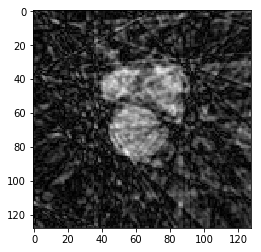

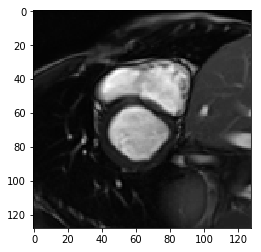

In [5]:
plt.imshow(data_recon[0,0,:,:], cmap='gray')
plt.show()
plt.imshow(data_truth[0,0,:,:], cmap='gray')
plt.show()

In [7]:
data_k1 = scipy.io.loadmat('data/Training_23und_K1.mat')
data_k2 = scipy.io.loadmat('data/Training_23und_K2.mat')

In [8]:
data_k1 = data_k1['k_data_1']
data_k2 = data_k2['k_data_2']

In [9]:
data_k2.shape

(128, 128, 20, 600)

In [10]:
data_k = np.ndarray((128, 128, 20, 1200), dtype='complex64')

In [12]:
data_k[:,:,:,0:600] = data_k1
data_k[:,:,:,600:1200] = data_k2[:,:,:,0:600]

In [13]:
data_k = data_k.transpose()

In [14]:
del data_k1, data_k2
print(data_k.shape)

(1200, 20, 128, 128)


In [15]:
mask = scipy.io.loadmat('data/Training_23und_mask.mat')
mask = mask['mask_data']

In [16]:
print(mask.shape)
mask = mask.transpose()
print(mask.shape)

(128, 128, 20, 1200)
(1200, 20, 128, 128)


In [20]:
data_test =scipy.io.loadmat('data/Test_23und_truth.mat')
test_truth = data_test['imagesTruth']

data_test =scipy.io.loadmat('data/Test_23und_recon.mat')
test_recon = data_test['imagesResampled']

del data_test

In [21]:
print(test_truth.shape)
print(test_recon.shape)
test_truth = test_truth.transpose()
test_recon = test_recon.transpose()
print(test_truth.shape)
print(test_recon.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [22]:
k_test =scipy.io.loadmat('data/Test_23und_K.mat')

In [23]:
test_mask = k_test['mask_data']
k_test = k_test['k_data']

In [24]:
print(test_mask.shape)
print(k_test.shape)
test_mask = test_mask.transpose()
k_test = k_test.transpose()
print(test_mask.shape)
print(k_test.shape)

(128, 128, 20, 222)
(128, 128, 20, 222)
(222, 20, 128, 128)
(222, 20, 128, 128)


In [25]:
test_mask = to_tensor_format(test_mask, True)
k_test = to_tensor_format(k_test)

In [26]:
test_recon = to_tensor_format(test_recon, True)
test_truth = to_tensor_format(test_truth, True)

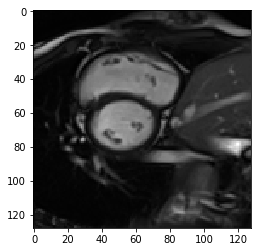

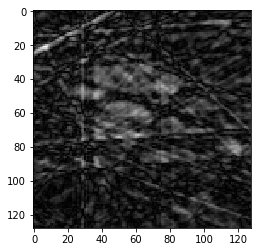

In [27]:
plt.imshow(test_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(test_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [28]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)
(222, 2, 128, 128, 20)


In [29]:
k_test = torch.from_numpy(k_test)
test_mask = torch.from_numpy(test_mask)
test_truth = torch.from_numpy(test_truth)
test_recon = torch.from_numpy(test_recon)

In [30]:
print(k_test.shape)
print(test_mask.shape)
print(test_truth.shape)
print(test_recon.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


In [31]:
print(k_test.dtype)
print(test_mask.dtype)
print(test_truth.dtype)
print(test_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [32]:
mask = to_tensor_format(mask, True)

In [33]:
data_k = to_tensor_format(data_k)

In [34]:
data_recon = to_tensor_format(data_recon, True)

In [35]:
data_truth = to_tensor_format(data_truth, True)

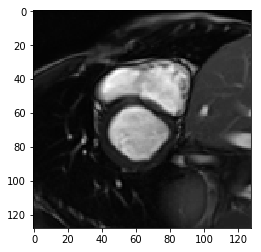

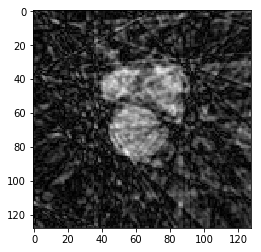

In [36]:
plt.imshow(data_truth[0,0,:,:,0], cmap='gray')
plt.show()
plt.imshow(data_recon[0,0,:,:,0], cmap='gray')
plt.show()

In [37]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)
(1200, 2, 128, 128, 20)


In [38]:
data_k = torch.from_numpy(data_k)
mask = torch.from_numpy(mask)
data_truth = torch.from_numpy(data_truth)
data_recon = torch.from_numpy(data_recon)

In [39]:
print(data_k.shape)
print(mask.shape)
print(data_truth.shape)
print(data_recon.shape)

torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])
torch.Size([1200, 2, 128, 128, 20])


In [40]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


In [41]:
data_recon = data_recon.type(torch.float)
data_truth = data_truth.type(torch.float)

In [42]:
print(data_k.dtype)
print(mask.dtype)
print(data_truth.dtype)
print(data_recon.dtype)

torch.float32
torch.float32
torch.float32
torch.float32


# Defining the CRNN

In [43]:
def data_consistency(k, k_0, mask, tau=None):
    """
    k    - input in k-space
    k0   - initially sampled elements in k-space
    mask - corresponding nonzero location
    """
    if tau:  
        output = (1 - mask) * k + mask * (k + tau * k_0) / (1 + tau)
    else:  
        output = (1 - mask) * k + mask * k_0
    return output

class Data_Consistency(nn.Module):
    """
    Data Consistency layer
    See the reference for the details of this operation.
    The basic idea is that if a point is smapled, we take the linear combination
    between the CNN prediction and the original measurements, weighted by the levle of noise.
    If the point is not sampled then we use the output of the network.
    """

    def __init__(self, tau=None, norm='ortho'):
        super(Data_Consistency, self).__init__()
        self.tau = tau
        self.normalized = norm == 'ortho' # needed for FFT

    def forward(self, *input, **kwargs):
        return self.perform(*input)

    def perform(self, x, k_0, mask):
        """
        x: input in the image domain, shape: (N, 2, x, y, T)
        k_0: initially sampled k-space data
        mask: the mask we use which tells which points were sampled which were not
        """
        #2D data
        if x.dim() == 4:
            x    = x.permute(0, 2, 3, 1)
            k_0   = k_0.permute(0, 2, 3, 1)
            mask = mask.permute(0, 2, 3, 1)
        #3D data    
        elif x.dim() == 5: 
            x    = x.permute(0, 4, 2, 3, 1)
            k_0   = k_0.permute(0, 4, 2, 3, 1)
            mask = mask.permute(0, 4, 2, 3, 1)

        # See the paper for more information
        # F^T * diagoanl matrix * F * x
        k = torch.fft(x, 2, normalized=self.normalized)
        out = data_consistency(k, k_0, mask, self.tau)
        output = torch.ifft(out, 2, normalized=self.normalized)

        if x.dim() == 4:
            output = output.permute(0, 3, 1, 2)
        elif x.dim() == 5:
            output = output.permute(0, 4, 2, 3, 1)

        return output

class CRNN(nn.Module):
    """
    Convolutional recurrent units evolving over iterations only
    Parameters
    -----------------
    inputs = input of the cell, 4D tensor, shape: (N_batch, channel, width, height)
    hiddenIteration = hidden states in the iteration dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    hiddenTempral = hidden states in the tmeporal dimension, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    -----------------
    output ---> hidden = our hidden representation, 4D tensor, shape: (N_batch, hidden_channel, width, height)
    """

    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(CRNN, self).__init__()
        self.kernel_size = kernel_size
        self.iteration_to_hidden = nn.Conv2d(input_channel, hidden_channel, kernel_size, padding=1)
        self.hidden_to_hidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        # add iteration hidden connection
        self.iterationHidden_to_iterationHidden = nn.Conv2d(hidden_channel, hidden_channel, kernel_size, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(hidden_channel)

    def forward(self, input, hiddenIteration, hiddenTemporal):
        """
        This performs the following operation, giving out H_l^i which is the
        hidden representation at layer l and at iteration i.
        ---------------
        H_l^i = ReLU(W_l * H_{l-1}^i + W_i * H_l^{i-1} + B_l)
        where ReLU is the non-linearity
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        B_l is the bias term
        * is Convolution operation
        ---------------
        Also, output is batch-normalised at the end
        """
        input_to_hidden = self.iteration_to_hidden(input)
        hidden_to_hidden = self.hidden_to_hidden(hiddenTemporal)
        iterationHidden = self.iterationHidden_to_iterationHidden(hiddenIteration)

        hidden = self.relu(input_to_hidden + hidden_to_hidden + iterationHidden)
        #print(hidden.shape)
        hidden = self.batchnorm(hidden)

        return hidden

class BCRNN(nn.Module):
    """
    Bidirectional convolutional recurrent units evolving over time and iterations
    ---------------------
    inputs = input data, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    inputIteration = hidden states form the previous iteration, 5D tensor, shape: (time_steps, N_batch, channel, width, height)
    mode = If in test mode to remove the grad. False (training) or True (testing)
    ---------------------
    output---> output,
    """
    def __init__(self, input_channel, hidden_channel, kernel_size):
        super(BCRNN, self).__init__()
        self.hidden_channel = hidden_channel
        self.kernel_size = kernel_size
        self.input_channel = input_channel
        self.CRNN_model = CRNN(self.input_channel, self.hidden_channel, self.kernel_size)

    def forward(self, input, input_iteration, mode=False):
        """
        This performs the following operation, giving out H_l_t^i which is the
        hidden representation at layer l, time-step t and at iteration i.
        ---------------
        forward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * forward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + forward_B_l)
        backward_H_l_t^i = ReLU(W_l * H_{l-1}_t^i + W_t * backward_H_l_{t-1}^{i}+ W_i * H_l_t^{i-1} + backward_B_l)
        H_l_t^i = forward_H_l_t^i + backward_H_l_t^i
        where ReLU is the non-linearity
        B_l is the bias term
        * is Convolution operation
        W_l and W_i are the filters of input_to_hidden convolutions and hidden_to_hidden convolutions respectively
        and W_t represents the filters of recurrent convolutions evolving over time.
        forward and backward is the direction of the hidden representation.
        ---------------
        """


        T, N_batch, channels, X, Y = input.shape # T, N_batch, channels, x, y
        hidden_size = [N_batch, self.hidden_channel, X, Y]
        if mode:
            with torch.no_grad():
                initial_hidden = Variable(torch.zeros(hidden_size)).cuda()
        else:
            initial_hidden = Variable(torch.zeros(hidden_size)).cuda()

        forward = []
        backward = []
        # forward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[i], input_iteration[i], hidden)
            forward.append(hidden)

        forward = torch.cat(forward)

        # backward
        hidden = initial_hidden
        for i in range(T):
            hidden = self.CRNN_model(input[T - i - 1], input_iteration[T - i -1], hidden)

            backward.append(hidden)
        backward = torch.cat(backward[::-1])

        output = forward + backward

        if N_batch == 1:
            output = output.view(T, 1, self.hidden_channel, X, Y)

        return output


class CRNN_MRI(nn.Module):
    """
    Model for Dynamic MRI Reconstruction using Convolutional Neural Networks
    Parameters. See the paper for more information
    -----------------------
         N_channels: number of channels
         N_filters: number of filters
         kernel_size: kernel size
         N_iterations: number of iterations
         N_units: number of CRNN/BCRNN/CNN layers in each iteration
    """
    def __init__(self, N_channels=2, N_filters=64, kernel_size=3, N_iterations=10, N_units=5):

        super(CRNN_MRI, self).__init__()
        self.N_iterations = N_iterations
        self.N_units = N_units
        self.N_filters = N_filters
        self.kernel_size = kernel_size

        self.bcrnn = BCRNN(N_channels, N_filters, kernel_size)
        self.conv1_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv1_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv2_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv2_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv3_x = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)
        self.conv3_h = nn.Conv2d(N_filters, N_filters, kernel_size, padding = 1)

        self.conv4_x = nn.Conv2d(N_filters, N_channels, kernel_size, padding = 1)
        self.relu = nn.ReLU(inplace=True)
        self.batchnorm = nn.BatchNorm2d(N_filters)
        self.batchnorm3 = nn.BatchNorm3d(N_channels)

        DC = []
        for i in range(N_iterations):
            DC.append(Data_Consistency(norm='ortho', tau=0.2))
        self.DC = DC

    def forward(self, x, k, m, mode=False):
        """
        x, y, m: input image, k-spce data, mask, shape: (N_batch, 2, x, y, T)
        mode - True: the model is in test mode, False: train mode
        """
        net = {}
        n_batch, N_channels, width, height, n_seq = x.size()
        size_h = [n_seq*n_batch, self.N_filters, width, height]
        if mode:
            with torch.no_grad():
                hid_init = Variable(torch.zeros(size_h)).cuda()
        else:
            hid_init = Variable(torch.zeros(size_h)).cuda()

        for j in range(self.N_units-1):
            net['t0_x%d'%j]=hid_init

        for i in range(1,self.N_iterations+1):

            x = x.permute(4,0,1,2,3)
            x = x.contiguous()
            net['t%d_x0' % (i - 1)] = net['t%d_x0' % (i - 1)].view(n_seq, n_batch,self.N_filters,width, height)
            net['t%d_x0'%i] = self.bcrnn(x, net['t%d_x0'%(i-1)], mode)
            net['t%d_x0'%i] = net['t%d_x0'%i].view(-1,self.N_filters,width, height)


            net['t%d_x1'%i] = self.conv1_x(net['t%d_x0'%i])
            net['t%d_h1'%i] = self.conv1_h(net['t%d_x1'%(i-1)])
            net['t%d_x1'%i] = self.relu(net['t%d_h1'%i]+net['t%d_x1'%i])
            net['t%d_x1'%i] = self.batchnorm(net['t%d_x1'%i])

            net['t%d_x2'%i] = self.conv2_x(net['t%d_x1'%i])
            net['t%d_h2'%i] = self.conv2_h(net['t%d_x2'%(i-1)])
            net['t%d_x2'%i] = self.relu(net['t%d_h2'%i]+net['t%d_x2'%i])
            net['t%d_x2'%i] = self.batchnorm(net['t%d_x2'%i])

            net['t%d_x3'%i] = self.conv3_x(net['t%d_x2'%i])
            net['t%d_h3'%i] = self.conv3_h(net['t%d_x3'%(i-1)])
            net['t%d_x3'%i] = self.relu(net['t%d_h3'%i]+net['t%d_x3'%i])
            net['t%d_x3'%i] = self.batchnorm(net['t%d_x3'%i])

            net['t%d_x4'%i] = self.conv4_x(net['t%d_x3'%i])

            x = x.view(-1,N_channels,width, height)
            net['t%d_out'%i] = x + net['t%d_x4'%i]

            net['t%d_out'%i] = net['t%d_out'%i].view(-1,n_batch, N_channels, width, height)
            net['t%d_out'%i] = net['t%d_out'%i].permute(1,2,3,4,0)
            net['t%d_out'%i].contiguous()
            net['t%d_out'%i] = self.DC[i-1].perform(net['t%d_out'%i], k, m)
            x = net['t%d_out'%i]
            #x = self.batchnorm3(x)

            # clean up i-1
            if mode:
                to_delete = [ key for key in net if ('t%d'%(i-1)) in key ]

                for elt in to_delete:
                    del net[elt]

                torch.cuda.empty_cache()

        return net['t%d_out'%i]

In [44]:
model = CRNN_MRI().to(device)

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
datasets = torch.utils.data.TensorDataset(data_recon[0:120], data_truth[0:120], 
                                          data_k[0:120], mask[0:120])
train_loader = DataLoader(datasets, batch_size=1, shuffle=True)


In [50]:
datasets = torch.utils.data.TensorDataset(data_recon, data_truth, 
                                          data_k, mask)
train_loader = DataLoader(datasets, batch_size=1, shuffle=True)

In [46]:
test_point = test_recon[0:1]
k_point = k_test[0:1]
mask_point = test_mask[0:1]

test_point = test_point.to(device)
k_point = k_point.to(device)
mask_point = mask_point.to(device)

In [54]:
import datetime

loss_vec = []
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    print('saving epoch {%d}'%0)
    checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'checkpoint_crnn_23und_epoch__%d.pth'%0)
    for epoch in range(1, n_epochs + 1):
        i = 0
        loss_train = 0
        for imgs, labels, k, m in train_loader:
            
            #print("started")
            #imgs = imgs.float()
            #labels = labels.float()
            #print("===")
            #print(imgs.shape)
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            k = k.to(device)
            m = m.to(device)
            
            #print(imgs.dtype)
            #print(k.dtype)
            #print(m.dtype)
            
            outputs = model(imgs, k, m)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            
            optimizer.step()
            
            loss_train += loss.item()
            
            if i%100 == 0:
                print("Epoch: {}, Iteration: {}, Loss: {}, time: {}".format(epoch, i+1, loss_train, datetime.datetime.now()))
            i +=1
        loss_vec.append(loss_train)
        print(i)
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, float(loss_train)))
        prediction = model(test_point, k_point, mask_point, mode=True)
        prediction = prediction.to('cpu')
        prediction = prediction.detach()
        prediction = prediction.float()
        print(prediction.shape)
        plt.imshow(np.sqrt(prediction[0,0,:,:,0]**2 + prediction[0,1,:,:,0]**2), cmap='gray')
        plt.show()
        
        del prediction
        
        print('saving epoch {%d}'%epoch)
        checkpoint = {'model': CRNN_MRI(), 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        torch.save(checkpoint, 'ckp_crnn_23und_epoch_%d.pth'%epoch)
        
    

saving epoch {0}
Epoch: 1, Iteration: 1, Loss: 0.007485334761440754, time: 2019-08-03 17:01:24.599358
Epoch: 1, Iteration: 101, Loss: 0.6670966341625899, time: 2019-08-03 17:03:22.581032
Epoch: 1, Iteration: 201, Loss: 1.1961901306640357, time: 2019-08-03 17:05:20.407986
Epoch: 1, Iteration: 301, Loss: 1.7024347679689527, time: 2019-08-03 17:07:18.327727
Epoch: 1, Iteration: 401, Loss: 2.138105686986819, time: 2019-08-03 17:09:16.222821
Epoch: 1, Iteration: 501, Loss: 2.5405152873136103, time: 2019-08-03 17:11:13.983067
Epoch: 1, Iteration: 601, Loss: 2.9538464380893856, time: 2019-08-03 17:13:12.092426
Epoch: 1, Iteration: 701, Loss: 3.3427626295015216, time: 2019-08-03 17:15:09.929052
Epoch: 1, Iteration: 801, Loss: 3.7189526986330748, time: 2019-08-03 17:17:07.622936
Epoch: 1, Iteration: 901, Loss: 4.063758828910068, time: 2019-08-03 17:19:05.423450
Epoch: 1, Iteration: 1001, Loss: 4.40038755373098, time: 2019-08-03 17:21:02.955808
Epoch: 1, Iteration: 1101, Loss: 4.756113262148574,

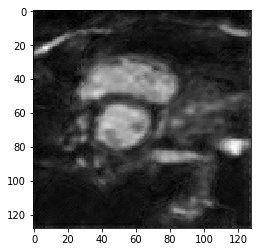

saving epoch {1}
Epoch: 2, Iteration: 1, Loss: 0.003377997549250722, time: 2019-08-03 17:24:59.309147
Epoch: 2, Iteration: 101, Loss: 0.32825122214853764, time: 2019-08-03 17:26:56.711991
Epoch: 2, Iteration: 201, Loss: 0.6388712206389755, time: 2019-08-03 17:28:54.020517
Epoch: 2, Iteration: 301, Loss: 0.9354837130522355, time: 2019-08-03 17:30:51.152391
Epoch: 2, Iteration: 401, Loss: 1.2385721873724833, time: 2019-08-03 17:32:48.291826
Epoch: 2, Iteration: 501, Loss: 1.529240008443594, time: 2019-08-03 17:34:45.499218
Epoch: 2, Iteration: 601, Loss: 1.8157635073876008, time: 2019-08-03 17:36:42.682841
Epoch: 2, Iteration: 701, Loss: 2.103825334692374, time: 2019-08-03 17:38:39.866963
Epoch: 2, Iteration: 801, Loss: 2.384975082008168, time: 2019-08-03 17:40:37.375668
Epoch: 2, Iteration: 901, Loss: 2.6749131832038984, time: 2019-08-03 17:42:34.921072
Epoch: 2, Iteration: 1001, Loss: 2.9411976408446208, time: 2019-08-03 17:44:32.807682
Epoch: 2, Iteration: 1101, Loss: 3.20908270578365

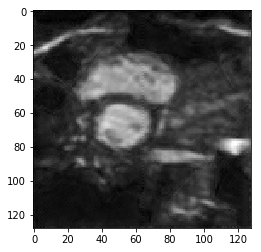

saving epoch {2}
Epoch: 3, Iteration: 1, Loss: 0.0016609091544523835, time: 2019-08-03 17:48:29.505331
Epoch: 3, Iteration: 101, Loss: 0.2669154673349112, time: 2019-08-03 17:50:27.495584
Epoch: 3, Iteration: 201, Loss: 0.5130413589067757, time: 2019-08-03 17:52:25.418003
Epoch: 3, Iteration: 301, Loss: 0.7559935100725852, time: 2019-08-03 17:54:23.348151
Epoch: 3, Iteration: 401, Loss: 1.0380277116200887, time: 2019-08-03 17:56:21.901603
Epoch: 3, Iteration: 501, Loss: 1.3164258293691091, time: 2019-08-03 17:58:20.283152
Epoch: 3, Iteration: 601, Loss: 1.5771069553447887, time: 2019-08-03 18:00:18.770337
Epoch: 3, Iteration: 701, Loss: 1.802742077037692, time: 2019-08-03 18:02:16.966719
Epoch: 3, Iteration: 801, Loss: 2.075498538906686, time: 2019-08-03 18:04:15.192530
Epoch: 3, Iteration: 901, Loss: 2.3022337818983942, time: 2019-08-03 18:06:13.719490
Epoch: 3, Iteration: 1001, Loss: 2.5532443637494, time: 2019-08-03 18:08:12.163126
Epoch: 3, Iteration: 1101, Loss: 2.792464587604627,

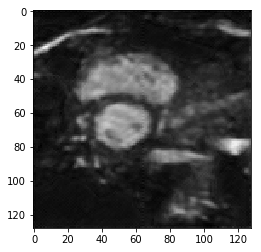

saving epoch {3}
Epoch: 4, Iteration: 1, Loss: 0.0019715188536792994, time: 2019-08-03 18:12:10.124733
Epoch: 4, Iteration: 101, Loss: 0.24939314858056605, time: 2019-08-03 18:14:08.561875
Epoch: 4, Iteration: 201, Loss: 0.48188130906783044, time: 2019-08-03 18:16:07.180271
Epoch: 4, Iteration: 301, Loss: 0.7018438476370648, time: 2019-08-03 18:18:05.736351
Epoch: 4, Iteration: 401, Loss: 0.9333335383562371, time: 2019-08-03 18:20:04.405104
Epoch: 4, Iteration: 501, Loss: 1.1524694912368432, time: 2019-08-03 18:22:03.138404
Epoch: 4, Iteration: 601, Loss: 1.3960984532022849, time: 2019-08-03 18:24:01.629628
Epoch: 4, Iteration: 701, Loss: 1.6224606144241989, time: 2019-08-03 18:26:00.063838
Epoch: 4, Iteration: 801, Loss: 1.840522312792018, time: 2019-08-03 18:27:58.412594
Epoch: 4, Iteration: 901, Loss: 2.097348724375479, time: 2019-08-03 18:29:56.888721
Epoch: 4, Iteration: 1001, Loss: 2.3336176222073846, time: 2019-08-03 18:31:55.562853
Epoch: 4, Iteration: 1101, Loss: 2.57032396609

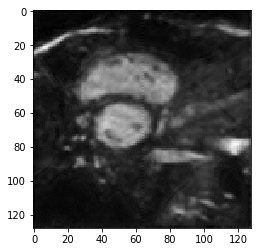

saving epoch {4}
Epoch: 5, Iteration: 1, Loss: 0.004479503259062767, time: 2019-08-03 18:35:53.343686
Epoch: 5, Iteration: 101, Loss: 0.24046846327837557, time: 2019-08-03 18:37:51.951729
Epoch: 5, Iteration: 201, Loss: 0.4650416426011361, time: 2019-08-03 18:39:50.138362
Epoch: 5, Iteration: 301, Loss: 0.6928009245893918, time: 2019-08-03 18:41:48.575097
Epoch: 5, Iteration: 401, Loss: 0.9074323422391899, time: 2019-08-03 18:43:47.017541
Epoch: 5, Iteration: 501, Loss: 1.1239264748292044, time: 2019-08-03 18:45:45.461339
Epoch: 5, Iteration: 701, Loss: 1.552835738984868, time: 2019-08-03 18:49:42.353334
Epoch: 5, Iteration: 801, Loss: 1.760137157922145, time: 2019-08-03 18:51:40.883835
Epoch: 5, Iteration: 901, Loss: 1.9512327000848018, time: 2019-08-03 18:53:39.332897
Epoch: 5, Iteration: 1001, Loss: 2.1575307990424335, time: 2019-08-03 18:55:37.733982
Epoch: 5, Iteration: 1101, Loss: 2.368700381310191, time: 2019-08-03 18:57:36.139897
1200
2019-08-03 18:59:33.502456 Epoch 5, Trainin

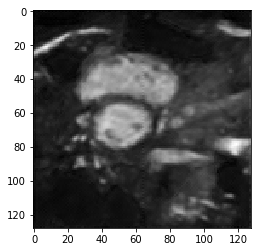

saving epoch {5}
Epoch: 6, Iteration: 1, Loss: 0.0008902999688871205, time: 2019-08-03 18:59:35.582192
Epoch: 6, Iteration: 101, Loss: 0.21037890436127782, time: 2019-08-03 19:01:34.146424
Epoch: 6, Iteration: 201, Loss: 0.42510808864608407, time: 2019-08-03 19:03:32.525740
Epoch: 6, Iteration: 301, Loss: 0.6279733466217294, time: 2019-08-03 19:05:30.881954
Epoch: 6, Iteration: 401, Loss: 0.8639184811036102, time: 2019-08-03 19:07:29.266747
Epoch: 6, Iteration: 501, Loss: 1.0912556037656032, time: 2019-08-03 19:09:27.783305
Epoch: 6, Iteration: 601, Loss: 1.318918973847758, time: 2019-08-03 19:11:26.224073
Epoch: 6, Iteration: 701, Loss: 1.513406387588475, time: 2019-08-03 19:13:24.669875
Epoch: 6, Iteration: 801, Loss: 1.728865749842953, time: 2019-08-03 19:15:23.439472
Epoch: 6, Iteration: 901, Loss: 1.90173373935977, time: 2019-08-03 19:17:21.846074
Epoch: 6, Iteration: 1001, Loss: 2.0892757743713446, time: 2019-08-03 19:19:20.416926
Epoch: 6, Iteration: 1101, Loss: 2.29190871736500

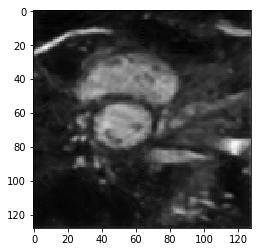

saving epoch {6}
Epoch: 7, Iteration: 1, Loss: 0.0014349950943142176, time: 2019-08-03 19:23:17.959412
Epoch: 7, Iteration: 101, Loss: 0.2042215011897497, time: 2019-08-03 19:25:16.145107
Epoch: 7, Iteration: 201, Loss: 0.4112417277065106, time: 2019-08-03 19:27:14.146848
Epoch: 7, Iteration: 301, Loss: 0.6200990182696842, time: 2019-08-03 19:29:12.415544
Epoch: 7, Iteration: 401, Loss: 0.8126717522973195, time: 2019-08-03 19:31:10.537762
Epoch: 7, Iteration: 501, Loss: 1.0231338469893672, time: 2019-08-03 19:33:08.675754
Epoch: 7, Iteration: 601, Loss: 1.2159109924687073, time: 2019-08-03 19:35:06.981426
Epoch: 7, Iteration: 701, Loss: 1.4171751477988437, time: 2019-08-03 19:37:05.237331
Epoch: 7, Iteration: 801, Loss: 1.5865603628917597, time: 2019-08-03 19:39:03.840676
Epoch: 7, Iteration: 901, Loss: 1.7777178466203623, time: 2019-08-03 19:41:02.389456
Epoch: 7, Iteration: 1001, Loss: 1.9578708291519433, time: 2019-08-03 19:43:00.946012
Epoch: 7, Iteration: 1101, Loss: 2.13048150227

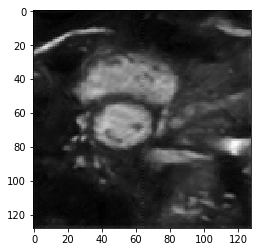

saving epoch {7}
Epoch: 8, Iteration: 1, Loss: 0.002456269459798932, time: 2019-08-03 19:46:58.906275
Epoch: 8, Iteration: 101, Loss: 0.18476330250268802, time: 2019-08-03 19:48:57.524517
Epoch: 8, Iteration: 201, Loss: 0.3686165495309979, time: 2019-08-03 19:50:55.912068
Epoch: 8, Iteration: 301, Loss: 0.5424147517187521, time: 2019-08-03 19:52:54.193945
Epoch: 8, Iteration: 401, Loss: 0.7414368480094709, time: 2019-08-03 19:54:52.792576
Epoch: 8, Iteration: 501, Loss: 0.9204026267398149, time: 2019-08-03 19:56:51.306909
Epoch: 8, Iteration: 601, Loss: 1.0964641915052198, time: 2019-08-03 19:58:49.968202
Epoch: 8, Iteration: 701, Loss: 1.2950399825931527, time: 2019-08-03 20:00:48.449868
Epoch: 8, Iteration: 801, Loss: 1.46755012543872, time: 2019-08-03 20:02:47.063298
Epoch: 8, Iteration: 901, Loss: 1.6419620040105656, time: 2019-08-03 20:04:45.671642
Epoch: 8, Iteration: 1001, Loss: 1.823731026146561, time: 2019-08-03 20:06:44.345245
Epoch: 8, Iteration: 1101, Loss: 1.99946831521810

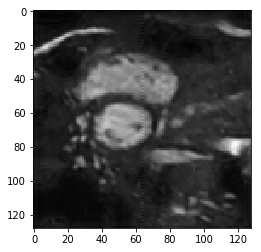

saving epoch {8}
Epoch: 9, Iteration: 1, Loss: 0.0009421055437996984, time: 2019-08-03 20:10:42.765114
Epoch: 9, Iteration: 101, Loss: 0.17300977621925995, time: 2019-08-03 20:12:41.247665
Epoch: 9, Iteration: 201, Loss: 0.34789316792739555, time: 2019-08-03 20:14:39.795242
Epoch: 9, Iteration: 301, Loss: 0.531008850375656, time: 2019-08-03 20:16:38.328355
Epoch: 9, Iteration: 401, Loss: 0.7034160923212767, time: 2019-08-03 20:18:36.810844
Epoch: 9, Iteration: 501, Loss: 0.8773851676960476, time: 2019-08-03 20:20:35.483981
Epoch: 9, Iteration: 601, Loss: 1.0343520815949887, time: 2019-08-03 20:22:34.120695
Epoch: 9, Iteration: 701, Loss: 1.2088945544674061, time: 2019-08-03 20:24:32.740132
Epoch: 9, Iteration: 801, Loss: 1.3741634333855473, time: 2019-08-03 20:26:31.326288
Epoch: 9, Iteration: 901, Loss: 1.5398577969754115, time: 2019-08-03 20:28:29.578458
Epoch: 9, Iteration: 1001, Loss: 1.7027524086879566, time: 2019-08-03 20:30:28.212985
Epoch: 9, Iteration: 1101, Loss: 1.8917411714

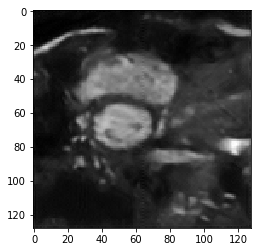

saving epoch {9}
Epoch: 10, Iteration: 1, Loss: 0.003441969631239772, time: 2019-08-03 20:34:26.168045
Epoch: 10, Iteration: 101, Loss: 0.16862250020494685, time: 2019-08-03 20:36:24.664553
Epoch: 10, Iteration: 201, Loss: 0.3328923816443421, time: 2019-08-03 20:38:23.046174
Epoch: 10, Iteration: 301, Loss: 0.5051964840095025, time: 2019-08-03 20:40:21.785560
Epoch: 10, Iteration: 401, Loss: 0.6677877138426993, time: 2019-08-03 20:42:20.610461
Epoch: 10, Iteration: 501, Loss: 0.8174965195066761, time: 2019-08-03 20:44:19.181000
Epoch: 10, Iteration: 601, Loss: 0.9657599545607809, time: 2019-08-03 20:46:18.169560
Epoch: 10, Iteration: 701, Loss: 1.1129210470244288, time: 2019-08-03 20:48:16.698391
Epoch: 10, Iteration: 801, Loss: 1.2850792177487165, time: 2019-08-03 20:50:14.949614
Epoch: 10, Iteration: 901, Loss: 1.4448047446785495, time: 2019-08-03 20:52:13.437214
Epoch: 10, Iteration: 1001, Loss: 1.5841228680801578, time: 2019-08-03 20:54:11.861041
Epoch: 10, Iteration: 1101, Loss: 1

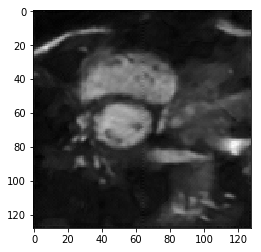

saving epoch {10}
Epoch: 11, Iteration: 1, Loss: 0.0012802624842152, time: 2019-08-03 20:58:09.845988
Epoch: 11, Iteration: 101, Loss: 0.175444646156393, time: 2019-08-03 21:00:08.167108
Epoch: 11, Iteration: 201, Loss: 0.3352011365350336, time: 2019-08-03 21:02:06.383917
Epoch: 11, Iteration: 301, Loss: 0.47098620259203017, time: 2019-08-03 21:04:04.397955
Epoch: 11, Iteration: 401, Loss: 0.6427115265396424, time: 2019-08-03 21:06:02.292492
Epoch: 11, Iteration: 501, Loss: 0.786352509225253, time: 2019-08-03 21:08:00.345422
Epoch: 11, Iteration: 601, Loss: 0.9147669914818835, time: 2019-08-03 21:09:58.481262
Epoch: 11, Iteration: 701, Loss: 1.04749856426497, time: 2019-08-03 21:11:56.658388
Epoch: 11, Iteration: 801, Loss: 1.170225062087411, time: 2019-08-03 21:13:54.611621
Epoch: 11, Iteration: 901, Loss: 1.3198007468308788, time: 2019-08-03 21:15:52.703472
Epoch: 11, Iteration: 1001, Loss: 1.446806688734796, time: 2019-08-03 21:17:50.617429
Epoch: 11, Iteration: 1101, Loss: 1.581691

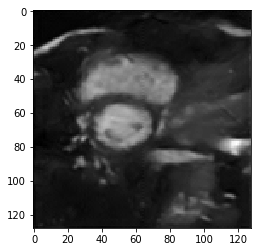

saving epoch {11}
Epoch: 12, Iteration: 1, Loss: 0.0009168010437861085, time: 2019-08-03 21:21:47.427629
Epoch: 12, Iteration: 101, Loss: 0.13737291225697845, time: 2019-08-03 21:23:45.338968
Epoch: 12, Iteration: 201, Loss: 0.26840566290775314, time: 2019-08-03 21:25:43.415114
Epoch: 12, Iteration: 301, Loss: 0.39532689144834876, time: 2019-08-03 21:27:41.685157
Epoch: 12, Iteration: 401, Loss: 0.5271112476475537, time: 2019-08-03 21:29:39.982081
Epoch: 12, Iteration: 501, Loss: 0.6825700563495047, time: 2019-08-03 21:31:38.268034
Epoch: 12, Iteration: 601, Loss: 0.8267764535266906, time: 2019-08-03 21:33:36.728870
Epoch: 12, Iteration: 701, Loss: 0.9380540310230572, time: 2019-08-03 21:35:35.387015
Epoch: 12, Iteration: 801, Loss: 1.0743768520478625, time: 2019-08-03 21:37:33.717277
Epoch: 12, Iteration: 901, Loss: 1.2060222130676266, time: 2019-08-03 21:39:32.035537
Epoch: 12, Iteration: 1001, Loss: 1.3317788983986247, time: 2019-08-03 21:41:30.505550
Epoch: 12, Iteration: 1101, Los

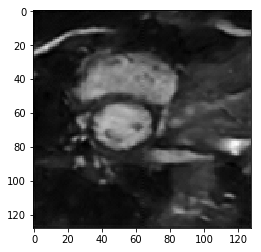

saving epoch {12}
Epoch: 13, Iteration: 1, Loss: 0.0019177275244146585, time: 2019-08-03 21:45:28.215585
Epoch: 13, Iteration: 101, Loss: 0.12272032344480976, time: 2019-08-03 21:47:26.777913
Epoch: 13, Iteration: 201, Loss: 0.2523770255211275, time: 2019-08-03 21:49:25.537070
Epoch: 13, Iteration: 301, Loss: 0.37280485301744193, time: 2019-08-03 21:51:24.255330
Epoch: 13, Iteration: 401, Loss: 0.48108474334003404, time: 2019-08-03 21:53:22.815011
Epoch: 13, Iteration: 501, Loss: 0.6012482258374803, time: 2019-08-03 21:55:21.457056
Epoch: 13, Iteration: 601, Loss: 0.7093843031907454, time: 2019-08-03 21:57:20.167102
Epoch: 13, Iteration: 701, Loss: 0.819078018568689, time: 2019-08-03 21:59:18.804373
Epoch: 13, Iteration: 801, Loss: 0.9545804792142007, time: 2019-08-03 22:01:17.468590
Epoch: 13, Iteration: 901, Loss: 1.0872264668287244, time: 2019-08-03 22:03:16.216394
Epoch: 13, Iteration: 1001, Loss: 1.2058626623183955, time: 2019-08-03 22:05:15.062663
Epoch: 13, Iteration: 1101, Loss

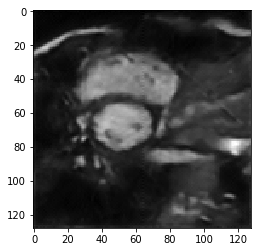

saving epoch {13}
Epoch: 14, Iteration: 1, Loss: 0.0011520652333274484, time: 2019-08-03 22:09:13.618705
Epoch: 14, Iteration: 101, Loss: 0.11741429826361127, time: 2019-08-03 22:11:12.557419
Epoch: 14, Iteration: 201, Loss: 0.22414099113666452, time: 2019-08-03 22:13:11.226016
Epoch: 14, Iteration: 301, Loss: 0.3448516938078683, time: 2019-08-03 22:15:10.160495
Epoch: 14, Iteration: 401, Loss: 0.4600370378466323, time: 2019-08-03 22:17:08.995664
Epoch: 14, Iteration: 501, Loss: 0.567073256126605, time: 2019-08-03 22:19:07.763203
Epoch: 14, Iteration: 601, Loss: 0.6601790335553233, time: 2019-08-03 22:21:06.489106
Epoch: 14, Iteration: 701, Loss: 0.7718612121243495, time: 2019-08-03 22:23:05.271056
Epoch: 14, Iteration: 801, Loss: 0.8990084236429539, time: 2019-08-03 22:25:04.081658
Epoch: 14, Iteration: 901, Loss: 1.0103294630534947, time: 2019-08-03 22:27:02.866635
Epoch: 14, Iteration: 1001, Loss: 1.1208896971074864, time: 2019-08-03 22:29:01.651335
Epoch: 14, Iteration: 1101, Loss:

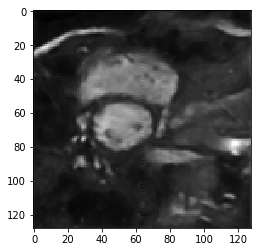

saving epoch {14}
Epoch: 15, Iteration: 1, Loss: 0.000626104767434299, time: 2019-08-03 22:33:00.177663
Epoch: 15, Iteration: 101, Loss: 0.11225668905535713, time: 2019-08-03 22:34:59.019787
Epoch: 15, Iteration: 201, Loss: 0.22869043902028352, time: 2019-08-03 22:36:57.712003
Epoch: 15, Iteration: 301, Loss: 0.33437072235392407, time: 2019-08-03 22:38:56.635834
Epoch: 15, Iteration: 401, Loss: 0.4594146998715587, time: 2019-08-03 22:40:55.514856
Epoch: 15, Iteration: 501, Loss: 0.5779213451605756, time: 2019-08-03 22:42:54.295020
Epoch: 15, Iteration: 601, Loss: 0.6862784560071304, time: 2019-08-03 22:44:53.023205
Epoch: 15, Iteration: 701, Loss: 0.7938133393763565, time: 2019-08-03 22:46:51.709046
Epoch: 15, Iteration: 801, Loss: 0.9016866966267116, time: 2019-08-03 22:48:50.524447
Epoch: 15, Iteration: 901, Loss: 1.0056930610735435, time: 2019-08-03 22:50:49.460306
Epoch: 15, Iteration: 1001, Loss: 1.115209938987391, time: 2019-08-03 22:52:48.145406
Epoch: 15, Iteration: 1101, Loss:

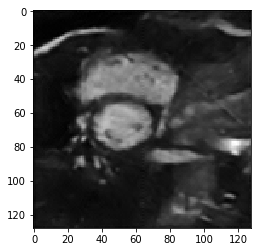

saving epoch {15}
Epoch: 16, Iteration: 1, Loss: 0.0007807723595760763, time: 2019-08-03 22:56:46.698842
Epoch: 16, Iteration: 101, Loss: 0.1226124707609415, time: 2019-08-03 22:58:45.624956
Epoch: 16, Iteration: 201, Loss: 0.2551058279641438, time: 2019-08-03 23:00:44.542855
Epoch: 16, Iteration: 301, Loss: 0.3585065008082893, time: 2019-08-03 23:02:43.590539
Epoch: 16, Iteration: 401, Loss: 0.4605362818983849, time: 2019-08-03 23:04:42.477604
Epoch: 16, Iteration: 501, Loss: 0.5602847314439714, time: 2019-08-03 23:06:41.490098
Epoch: 16, Iteration: 601, Loss: 0.6729281470470596, time: 2019-08-03 23:08:40.332513
Epoch: 16, Iteration: 701, Loss: 0.7863531413022429, time: 2019-08-03 23:10:39.173081
Epoch: 16, Iteration: 801, Loss: 0.9172897758544423, time: 2019-08-03 23:12:37.768034
Epoch: 16, Iteration: 901, Loss: 1.0308417156047653, time: 2019-08-03 23:14:36.372173
Epoch: 16, Iteration: 1001, Loss: 1.1308937601570506, time: 2019-08-03 23:16:35.355241
Epoch: 16, Iteration: 1101, Loss: 

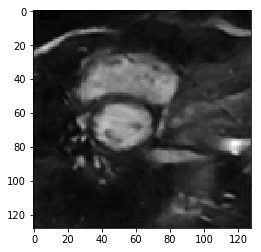

saving epoch {16}
Epoch: 17, Iteration: 1, Loss: 0.0011318965116515756, time: 2019-08-03 23:20:33.414013
Epoch: 17, Iteration: 101, Loss: 0.09807125761290081, time: 2019-08-03 23:22:32.098212
Epoch: 17, Iteration: 201, Loss: 0.19677857379429042, time: 2019-08-03 23:24:30.660818
Epoch: 17, Iteration: 301, Loss: 0.29842294938862324, time: 2019-08-03 23:26:29.430558
Epoch: 17, Iteration: 401, Loss: 0.39620697786449455, time: 2019-08-03 23:28:27.986413
Epoch: 17, Iteration: 501, Loss: 0.49156448038411327, time: 2019-08-03 23:30:26.491192
Epoch: 17, Iteration: 601, Loss: 0.5842885318561457, time: 2019-08-03 23:32:25.079536
Epoch: 17, Iteration: 701, Loss: 0.6805513122526463, time: 2019-08-03 23:34:23.730313
Epoch: 17, Iteration: 801, Loss: 0.7947040261060465, time: 2019-08-03 23:36:22.300416
Epoch: 17, Iteration: 901, Loss: 0.8969769323593937, time: 2019-08-03 23:38:20.761186
Epoch: 17, Iteration: 1001, Loss: 0.9926664702943526, time: 2019-08-03 23:40:19.308699
Epoch: 17, Iteration: 1101, L

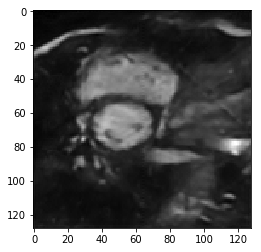

saving epoch {17}
Epoch: 18, Iteration: 1, Loss: 0.0008694272255524993, time: 2019-08-03 23:44:17.756435
Epoch: 18, Iteration: 101, Loss: 0.0970438863732852, time: 2019-08-03 23:46:16.352362
Epoch: 18, Iteration: 201, Loss: 0.22504453541478142, time: 2019-08-03 23:48:14.981636
Epoch: 18, Iteration: 301, Loss: 0.3208771271747537, time: 2019-08-03 23:50:13.737339
Epoch: 18, Iteration: 401, Loss: 0.42128515071817674, time: 2019-08-03 23:52:12.663413
Epoch: 18, Iteration: 501, Loss: 0.5176196535176132, time: 2019-08-03 23:54:11.489551
Epoch: 18, Iteration: 601, Loss: 0.6184733504487667, time: 2019-08-03 23:56:10.125250
Epoch: 18, Iteration: 701, Loss: 0.7199536017433275, time: 2019-08-03 23:58:08.650367
Epoch: 18, Iteration: 801, Loss: 0.8222647061338648, time: 2019-08-04 00:00:07.218626
Epoch: 18, Iteration: 901, Loss: 0.9156097849481739, time: 2019-08-04 00:02:05.898362
Epoch: 18, Iteration: 1001, Loss: 1.003033009241335, time: 2019-08-04 00:04:04.491048
Epoch: 18, Iteration: 1101, Loss:

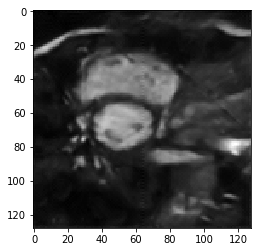

saving epoch {18}
Epoch: 19, Iteration: 1, Loss: 0.001397829269990325, time: 2019-08-04 00:08:02.745414
Epoch: 19, Iteration: 101, Loss: 0.0961622454051394, time: 2019-08-04 00:10:01.427279
Epoch: 19, Iteration: 201, Loss: 0.2018359575595241, time: 2019-08-04 00:12:00.078507
Epoch: 19, Iteration: 301, Loss: 0.2874159496277571, time: 2019-08-04 00:13:58.826078
Epoch: 19, Iteration: 401, Loss: 0.3785015968605876, time: 2019-08-04 00:15:57.655076
Epoch: 19, Iteration: 501, Loss: 0.46798859132104553, time: 2019-08-04 00:17:56.457189
Epoch: 19, Iteration: 601, Loss: 0.5635108203568961, time: 2019-08-04 00:19:54.939799
Epoch: 19, Iteration: 701, Loss: 0.6570122406410519, time: 2019-08-04 00:21:53.636833
Epoch: 19, Iteration: 801, Loss: 0.7559973380703013, time: 2019-08-04 00:23:52.392396
Epoch: 19, Iteration: 901, Loss: 0.8644281709857751, time: 2019-08-04 00:25:51.012803
Epoch: 19, Iteration: 1001, Loss: 0.9610673080023844, time: 2019-08-04 00:27:49.727101
Epoch: 19, Iteration: 1101, Loss: 

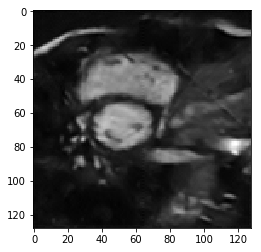

saving epoch {19}
Epoch: 20, Iteration: 1, Loss: 0.0010068070841953158, time: 2019-08-04 00:31:47.951233
Epoch: 20, Iteration: 101, Loss: 0.09940679126884788, time: 2019-08-04 00:33:46.581170
Epoch: 20, Iteration: 201, Loss: 0.18905397021444514, time: 2019-08-04 00:35:45.337806
Epoch: 20, Iteration: 301, Loss: 0.3036300366802607, time: 2019-08-04 00:37:44.033419
Epoch: 20, Iteration: 401, Loss: 0.39891949188313447, time: 2019-08-04 00:39:42.655737
Epoch: 20, Iteration: 501, Loss: 0.484100247209426, time: 2019-08-04 00:41:41.346682
Epoch: 20, Iteration: 601, Loss: 0.566511840937892, time: 2019-08-04 00:43:40.061703
Epoch: 20, Iteration: 701, Loss: 0.6499084307870362, time: 2019-08-04 00:45:38.994132
Epoch: 20, Iteration: 801, Loss: 0.7438343237736262, time: 2019-08-04 00:47:37.791693
Epoch: 20, Iteration: 901, Loss: 0.8299103723838925, time: 2019-08-04 00:49:36.664616
Epoch: 20, Iteration: 1001, Loss: 0.9192455348675139, time: 2019-08-04 00:51:35.421647
Epoch: 20, Iteration: 1101, Loss:

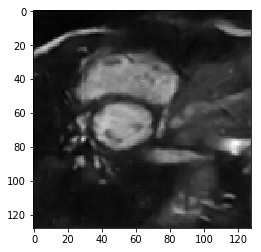

saving epoch {20}
Epoch: 21, Iteration: 1, Loss: 0.000639228499494493, time: 2019-08-04 00:55:34.230852
Epoch: 21, Iteration: 101, Loss: 0.0881723609927576, time: 2019-08-04 00:57:33.069402
Epoch: 21, Iteration: 201, Loss: 0.1750465850927867, time: 2019-08-04 00:59:32.018082
Epoch: 21, Iteration: 301, Loss: 0.25798138772370294, time: 2019-08-04 01:01:30.794158
Epoch: 21, Iteration: 401, Loss: 0.34710951181477867, time: 2019-08-04 01:03:29.503326
Epoch: 21, Iteration: 501, Loss: 0.4463877822854556, time: 2019-08-04 01:05:28.471987
Epoch: 21, Iteration: 601, Loss: 0.5467909766884986, time: 2019-08-04 01:07:27.287228
Epoch: 21, Iteration: 701, Loss: 0.6294252546213102, time: 2019-08-04 01:09:26.092975
Epoch: 21, Iteration: 801, Loss: 0.718402761471225, time: 2019-08-04 01:11:24.826544
Epoch: 21, Iteration: 901, Loss: 0.8188878390647005, time: 2019-08-04 01:13:23.744970
Epoch: 21, Iteration: 1001, Loss: 0.9049213658436202, time: 2019-08-04 01:15:22.622845
Epoch: 21, Iteration: 1101, Loss: 

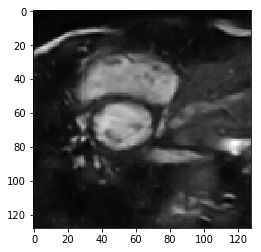

saving epoch {21}
Epoch: 22, Iteration: 1, Loss: 0.000614233547821641, time: 2019-08-04 01:19:20.978119
Epoch: 22, Iteration: 101, Loss: 0.09667460934724659, time: 2019-08-04 01:21:19.845912
Epoch: 22, Iteration: 201, Loss: 0.18172798315936234, time: 2019-08-04 01:23:18.774901
Epoch: 22, Iteration: 301, Loss: 0.27084633268532343, time: 2019-08-04 01:25:17.615033
Epoch: 22, Iteration: 401, Loss: 0.3593497368565295, time: 2019-08-04 01:27:16.410969
Epoch: 22, Iteration: 501, Loss: 0.4525284229021054, time: 2019-08-04 01:29:15.143406
Epoch: 22, Iteration: 601, Loss: 0.5450064670585562, time: 2019-08-04 01:31:13.937455
Epoch: 22, Iteration: 701, Loss: 0.6341187710349914, time: 2019-08-04 01:33:12.607050
Epoch: 22, Iteration: 801, Loss: 0.7128430728625972, time: 2019-08-04 01:35:11.392799
Epoch: 22, Iteration: 901, Loss: 0.8029338517808355, time: 2019-08-04 01:37:10.176532
Epoch: 22, Iteration: 1001, Loss: 0.8990131985337939, time: 2019-08-04 01:39:08.940096
Epoch: 22, Iteration: 1101, Loss

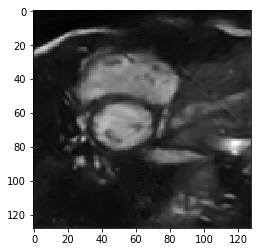

saving epoch {22}
Epoch: 23, Iteration: 1, Loss: 0.0008479147218167782, time: 2019-08-04 01:43:07.534933
Epoch: 23, Iteration: 101, Loss: 0.09081723215058446, time: 2019-08-04 01:45:06.165828
Epoch: 23, Iteration: 201, Loss: 0.2088936257059686, time: 2019-08-04 01:47:04.854133
Epoch: 23, Iteration: 301, Loss: 0.2915645616594702, time: 2019-08-04 01:49:03.779779
Epoch: 23, Iteration: 401, Loss: 0.37298500011092983, time: 2019-08-04 01:51:02.595293
Epoch: 23, Iteration: 501, Loss: 0.45464686187915504, time: 2019-08-04 01:53:01.302111
Epoch: 23, Iteration: 601, Loss: 0.5336633842089213, time: 2019-08-04 01:54:59.911916
Epoch: 23, Iteration: 701, Loss: 0.618035378283821, time: 2019-08-04 01:56:58.830067
Epoch: 23, Iteration: 801, Loss: 0.7040383783460129, time: 2019-08-04 01:58:57.555705
Epoch: 23, Iteration: 901, Loss: 0.7815860941191204, time: 2019-08-04 02:00:56.428083
Epoch: 23, Iteration: 1001, Loss: 0.8563720769889187, time: 2019-08-04 02:02:55.138939
Epoch: 23, Iteration: 1101, Loss

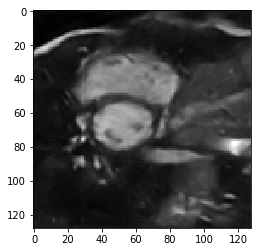

saving epoch {23}
Epoch: 24, Iteration: 1, Loss: 0.0010863470379263163, time: 2019-08-04 02:06:53.473635
Epoch: 24, Iteration: 101, Loss: 0.08954311278648674, time: 2019-08-04 02:08:52.205538
Epoch: 24, Iteration: 201, Loss: 0.17543665820267051, time: 2019-08-04 02:10:51.041508
Epoch: 24, Iteration: 301, Loss: 0.26360378437675536, time: 2019-08-04 02:12:49.637224
Epoch: 24, Iteration: 401, Loss: 0.3429186898865737, time: 2019-08-04 02:14:48.465984
Epoch: 24, Iteration: 501, Loss: 0.41536156364600174, time: 2019-08-04 02:16:47.379631
Epoch: 24, Iteration: 601, Loss: 0.4943861273059156, time: 2019-08-04 02:18:45.993441
Epoch: 24, Iteration: 701, Loss: 0.5827723531692754, time: 2019-08-04 02:20:44.700826
Epoch: 24, Iteration: 801, Loss: 0.6662655070831534, time: 2019-08-04 02:22:43.488179
Epoch: 24, Iteration: 901, Loss: 0.7521549209195655, time: 2019-08-04 02:24:42.086373
Epoch: 24, Iteration: 1001, Loss: 0.8360678467724938, time: 2019-08-04 02:26:40.804693
Epoch: 24, Iteration: 1101, Lo

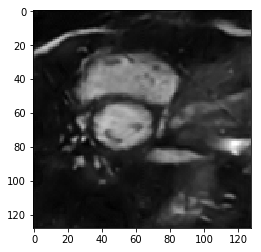

saving epoch {24}
Epoch: 25, Iteration: 1, Loss: 0.000723299162928015, time: 2019-08-04 02:30:39.106586
Epoch: 25, Iteration: 101, Loss: 0.08006995290634222, time: 2019-08-04 02:32:37.810625
Epoch: 25, Iteration: 201, Loss: 0.16393308641272597, time: 2019-08-04 02:34:36.591227
Epoch: 25, Iteration: 301, Loss: 0.2490971779334359, time: 2019-08-04 02:36:35.324931
Epoch: 25, Iteration: 401, Loss: 0.32859984881361015, time: 2019-08-04 02:38:34.185823
Epoch: 25, Iteration: 501, Loss: 0.4002676437376067, time: 2019-08-04 02:40:32.955324
Epoch: 25, Iteration: 601, Loss: 0.48492412868654355, time: 2019-08-04 02:42:31.686369
Epoch: 25, Iteration: 701, Loss: 0.559414071001811, time: 2019-08-04 02:44:30.479514
Epoch: 25, Iteration: 801, Loss: 0.6468453840061557, time: 2019-08-04 02:46:29.166665
Epoch: 25, Iteration: 901, Loss: 0.7249361644790042, time: 2019-08-04 02:48:27.904772
Epoch: 25, Iteration: 1001, Loss: 0.8094013242516667, time: 2019-08-04 02:50:26.544125
Epoch: 25, Iteration: 1101, Loss

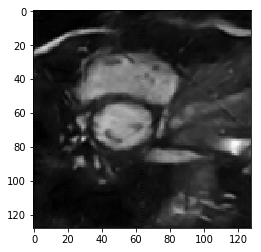

saving epoch {25}
Epoch: 26, Iteration: 1, Loss: 0.0005511234630830586, time: 2019-08-04 02:54:24.987433
Epoch: 26, Iteration: 101, Loss: 0.08142409293213859, time: 2019-08-04 02:56:23.658695
Epoch: 26, Iteration: 201, Loss: 0.16365755017613992, time: 2019-08-04 02:58:22.422446
Epoch: 26, Iteration: 301, Loss: 0.25100359634961933, time: 2019-08-04 03:00:20.899739
Epoch: 26, Iteration: 401, Loss: 0.3292627830815036, time: 2019-08-04 03:02:19.334886
Epoch: 26, Iteration: 501, Loss: 0.40772227745037526, time: 2019-08-04 03:04:18.046044
Epoch: 26, Iteration: 601, Loss: 0.4850766084564384, time: 2019-08-04 03:06:16.738673
Epoch: 26, Iteration: 701, Loss: 0.5627010641619563, time: 2019-08-04 03:08:15.690631
Epoch: 26, Iteration: 801, Loss: 0.6454538549587596, time: 2019-08-04 03:10:14.439927
Epoch: 26, Iteration: 901, Loss: 0.7300688341492787, time: 2019-08-04 03:12:13.125090
Epoch: 26, Iteration: 1001, Loss: 0.8170394388725981, time: 2019-08-04 03:14:12.058400
Epoch: 26, Iteration: 1101, Lo

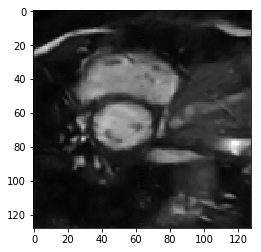

saving epoch {26}
Epoch: 27, Iteration: 1, Loss: 0.0008794291061349213, time: 2019-08-04 03:18:10.597434
Epoch: 27, Iteration: 101, Loss: 0.0677959265303798, time: 2019-08-04 03:20:09.591379
Epoch: 27, Iteration: 201, Loss: 0.14314066132646985, time: 2019-08-04 03:22:08.404800
Epoch: 27, Iteration: 301, Loss: 0.22147402336122468, time: 2019-08-04 03:24:07.274571
Epoch: 27, Iteration: 401, Loss: 0.3022531448514201, time: 2019-08-04 03:26:05.904458
Epoch: 27, Iteration: 501, Loss: 0.38796964558423497, time: 2019-08-04 03:28:04.780613
Epoch: 27, Iteration: 601, Loss: 0.472089391638292, time: 2019-08-04 03:30:03.556876
Epoch: 27, Iteration: 701, Loss: 0.5447046579793096, time: 2019-08-04 03:32:02.093616
Epoch: 27, Iteration: 801, Loss: 0.6149334372021258, time: 2019-08-04 03:34:00.866801
Epoch: 27, Iteration: 901, Loss: 0.6999108003801666, time: 2019-08-04 03:35:59.687988
Epoch: 27, Iteration: 1001, Loss: 0.7814078933733981, time: 2019-08-04 03:37:58.615529
Epoch: 27, Iteration: 1101, Loss

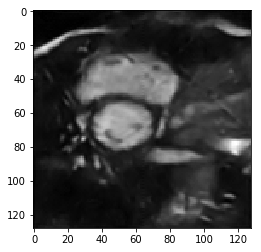

saving epoch {27}
Epoch: 28, Iteration: 1, Loss: 0.0007404921343550086, time: 2019-08-04 03:41:57.438580
Epoch: 28, Iteration: 101, Loss: 0.08130661756149493, time: 2019-08-04 03:43:56.267527
Epoch: 28, Iteration: 201, Loss: 0.15896236183471046, time: 2019-08-04 03:45:55.285835
Epoch: 28, Iteration: 301, Loss: 0.23719375801738352, time: 2019-08-04 03:47:54.246664
Epoch: 28, Iteration: 401, Loss: 0.31388434607652016, time: 2019-08-04 03:49:52.998353
Epoch: 28, Iteration: 501, Loss: 0.3848628487321548, time: 2019-08-04 03:51:51.876821
Epoch: 28, Iteration: 601, Loss: 0.4629409261397086, time: 2019-08-04 03:53:50.696665
Epoch: 28, Iteration: 701, Loss: 0.5443148206104524, time: 2019-08-04 03:55:49.570142
Epoch: 28, Iteration: 801, Loss: 0.6193478671921184, time: 2019-08-04 03:57:48.484225
Epoch: 28, Iteration: 901, Loss: 0.6938889160664985, time: 2019-08-04 03:59:47.196345
Epoch: 28, Iteration: 1001, Loss: 0.7657642857375322, time: 2019-08-04 04:01:46.002265
Epoch: 28, Iteration: 1101, Lo

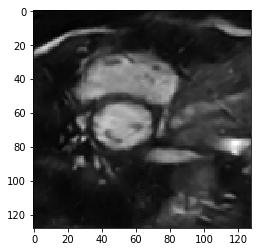

saving epoch {28}
Epoch: 29, Iteration: 1, Loss: 0.0008090742630884051, time: 2019-08-04 04:05:44.402987
Epoch: 29, Iteration: 101, Loss: 0.08298820810159668, time: 2019-08-04 04:07:43.448715
Epoch: 29, Iteration: 201, Loss: 0.15963813438429497, time: 2019-08-04 04:09:42.274591
Epoch: 29, Iteration: 301, Loss: 0.24303369788685814, time: 2019-08-04 04:11:41.162132
Epoch: 29, Iteration: 401, Loss: 0.32278824620880187, time: 2019-08-04 04:13:39.918978
Epoch: 29, Iteration: 501, Loss: 0.39184194451081567, time: 2019-08-04 04:15:38.798356
Epoch: 29, Iteration: 601, Loss: 0.468336250007269, time: 2019-08-04 04:17:37.762346
Epoch: 29, Iteration: 701, Loss: 0.5486839713266818, time: 2019-08-04 04:19:36.565753
Epoch: 29, Iteration: 801, Loss: 0.6219225603417726, time: 2019-08-04 04:21:35.224386
Epoch: 29, Iteration: 901, Loss: 0.699288841089583, time: 2019-08-04 04:23:33.868974
Epoch: 29, Iteration: 1001, Loss: 0.774264470601338, time: 2019-08-04 04:25:32.540690
Epoch: 29, Iteration: 1101, Loss

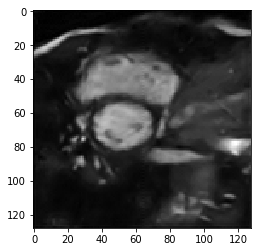

saving epoch {29}
Epoch: 30, Iteration: 1, Loss: 0.0011705792276188731, time: 2019-08-04 04:29:30.706162
Epoch: 30, Iteration: 101, Loss: 0.07962875397060998, time: 2019-08-04 04:31:29.368706
Epoch: 30, Iteration: 201, Loss: 0.15453567329677753, time: 2019-08-04 04:33:27.862498
Epoch: 30, Iteration: 301, Loss: 0.23174991802079603, time: 2019-08-04 04:35:26.299208
Epoch: 30, Iteration: 401, Loss: 0.3071770023962017, time: 2019-08-04 04:37:25.023964
Epoch: 30, Iteration: 501, Loss: 0.38430118176620454, time: 2019-08-04 04:39:23.619370
Epoch: 30, Iteration: 601, Loss: 0.45828004108625464, time: 2019-08-04 04:41:22.260347
Epoch: 30, Iteration: 701, Loss: 0.5317298766749445, time: 2019-08-04 04:43:20.966541
Epoch: 30, Iteration: 801, Loss: 0.605743955806247, time: 2019-08-04 04:45:19.659130
Epoch: 30, Iteration: 901, Loss: 0.6885052235011244, time: 2019-08-04 04:47:18.290088
Epoch: 30, Iteration: 1001, Loss: 0.7613113793922821, time: 2019-08-04 04:49:16.724322
Epoch: 30, Iteration: 1101, Lo

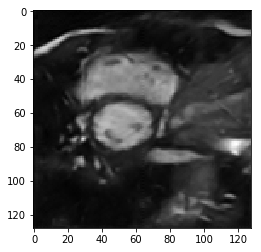

saving epoch {30}
Epoch: 31, Iteration: 1, Loss: 0.0008537870598956943, time: 2019-08-04 04:53:14.992399
Epoch: 31, Iteration: 101, Loss: 0.0666653243242763, time: 2019-08-04 04:55:13.617869
Epoch: 31, Iteration: 201, Loss: 0.13460291604860686, time: 2019-08-04 04:57:12.496323
Epoch: 31, Iteration: 301, Loss: 0.20731433694891166, time: 2019-08-04 04:59:11.310071
Epoch: 31, Iteration: 401, Loss: 0.2814414313615998, time: 2019-08-04 05:01:10.163253
Epoch: 31, Iteration: 501, Loss: 0.35201375601172913, time: 2019-08-04 05:03:09.035621
Epoch: 31, Iteration: 601, Loss: 0.44414353456522804, time: 2019-08-04 05:05:07.876071
Epoch: 31, Iteration: 701, Loss: 0.5240076317713829, time: 2019-08-04 05:07:06.656638
Epoch: 31, Iteration: 801, Loss: 0.6046054487669608, time: 2019-08-04 05:09:05.399684
Epoch: 31, Iteration: 901, Loss: 0.6790670695918379, time: 2019-08-04 05:11:04.089782
Epoch: 31, Iteration: 1001, Loss: 0.7526656015397748, time: 2019-08-04 05:13:02.937349
Epoch: 31, Iteration: 1101, Lo

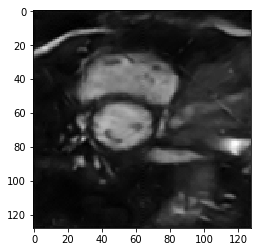

saving epoch {31}
Epoch: 32, Iteration: 1, Loss: 0.0005922641139477491, time: 2019-08-04 05:17:01.593078
Epoch: 32, Iteration: 101, Loss: 0.07567011726496276, time: 2019-08-04 05:19:00.301315
Epoch: 32, Iteration: 201, Loss: 0.1389606095617637, time: 2019-08-04 05:20:59.031472
Epoch: 32, Iteration: 301, Loss: 0.20743557886453345, time: 2019-08-04 05:22:57.775000
Epoch: 32, Iteration: 401, Loss: 0.27981784802977927, time: 2019-08-04 05:24:56.506159
Epoch: 32, Iteration: 501, Loss: 0.3534986868617125, time: 2019-08-04 05:26:55.258734
Epoch: 32, Iteration: 601, Loss: 0.42251500600832514, time: 2019-08-04 05:28:54.022200
Epoch: 32, Iteration: 701, Loss: 0.5018036642577499, time: 2019-08-04 05:30:52.716115
Epoch: 32, Iteration: 801, Loss: 0.5750009186740499, time: 2019-08-04 05:32:51.498100
Epoch: 32, Iteration: 901, Loss: 0.6484181546256877, time: 2019-08-04 05:34:50.229489
Epoch: 32, Iteration: 1001, Loss: 0.7149774400168099, time: 2019-08-04 05:36:48.992761
Epoch: 32, Iteration: 1101, Lo

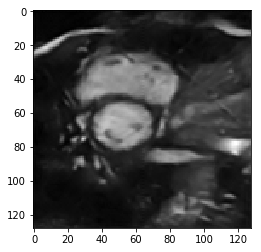

saving epoch {32}
Epoch: 33, Iteration: 1, Loss: 0.0008634869009256363, time: 2019-08-04 05:40:47.262390
Epoch: 33, Iteration: 101, Loss: 0.06550704466644675, time: 2019-08-04 05:42:46.158432
Epoch: 33, Iteration: 201, Loss: 0.13932299937005155, time: 2019-08-04 05:44:44.970228
Epoch: 33, Iteration: 301, Loss: 0.21324449581152294, time: 2019-08-04 05:46:43.696726
Epoch: 33, Iteration: 401, Loss: 0.29050223030208144, time: 2019-08-04 05:48:42.563869
Epoch: 33, Iteration: 501, Loss: 0.35729558060120326, time: 2019-08-04 05:50:41.437016
Epoch: 33, Iteration: 601, Loss: 0.4280743611889193, time: 2019-08-04 05:52:40.302387
Epoch: 33, Iteration: 701, Loss: 0.5012207898398628, time: 2019-08-04 05:54:39.146257
Epoch: 33, Iteration: 801, Loss: 0.5706917672796408, time: 2019-08-04 05:56:37.938602
Epoch: 33, Iteration: 901, Loss: 0.6421193784626666, time: 2019-08-04 05:58:36.946573
Epoch: 33, Iteration: 1001, Loss: 0.7070728001272073, time: 2019-08-04 06:00:36.055080
Epoch: 33, Iteration: 1101, L

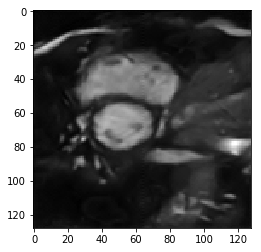

saving epoch {33}
Epoch: 34, Iteration: 1, Loss: 0.0003982513735536486, time: 2019-08-04 06:04:34.932237
Epoch: 34, Iteration: 101, Loss: 0.06794880289817229, time: 2019-08-04 06:06:33.921342
Epoch: 34, Iteration: 201, Loss: 0.13753741633263417, time: 2019-08-04 06:08:32.864543
Epoch: 34, Iteration: 301, Loss: 0.20752284993068315, time: 2019-08-04 06:10:31.772765
Epoch: 34, Iteration: 401, Loss: 0.27864531220984645, time: 2019-08-04 06:12:30.767934
Epoch: 34, Iteration: 501, Loss: 0.34511261063744314, time: 2019-08-04 06:14:29.651920
Epoch: 34, Iteration: 601, Loss: 0.40861798921832815, time: 2019-08-04 06:16:28.395486
Epoch: 34, Iteration: 701, Loss: 0.48647662697476335, time: 2019-08-04 06:18:27.088785
Epoch: 34, Iteration: 801, Loss: 0.5551603772037197, time: 2019-08-04 06:20:25.838618
Epoch: 34, Iteration: 901, Loss: 0.6311138286691858, time: 2019-08-04 06:22:24.762185
Epoch: 34, Iteration: 1001, Loss: 0.7160462149040541, time: 2019-08-04 06:24:23.665939
Epoch: 34, Iteration: 1101,

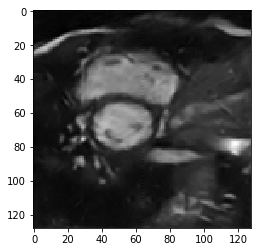

saving epoch {34}
Epoch: 35, Iteration: 1, Loss: 0.0005185735644772649, time: 2019-08-04 06:28:22.085784
Epoch: 35, Iteration: 101, Loss: 0.06610125253791921, time: 2019-08-04 06:30:20.834515
Epoch: 35, Iteration: 201, Loss: 0.13536919295438565, time: 2019-08-04 06:32:19.564002
Epoch: 35, Iteration: 301, Loss: 0.19416723381436896, time: 2019-08-04 06:34:18.190173
Epoch: 35, Iteration: 401, Loss: 0.2695728546095779, time: 2019-08-04 06:36:16.997626
Epoch: 35, Iteration: 501, Loss: 0.34442205766390543, time: 2019-08-04 06:38:15.665821
Epoch: 35, Iteration: 601, Loss: 0.4186104461696232, time: 2019-08-04 06:40:14.418935
Epoch: 35, Iteration: 701, Loss: 0.5012363004061626, time: 2019-08-04 06:42:13.262253
Epoch: 35, Iteration: 801, Loss: 0.5710863487765891, time: 2019-08-04 06:44:12.231910
Epoch: 35, Iteration: 901, Loss: 0.6388277061778354, time: 2019-08-04 06:46:11.185793
Epoch: 35, Iteration: 1001, Loss: 0.7080117284640437, time: 2019-08-04 06:48:10.080998
Epoch: 35, Iteration: 1101, Lo

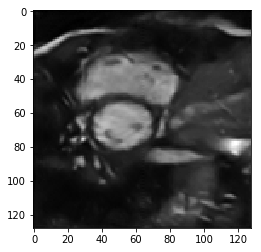

saving epoch {35}
Epoch: 36, Iteration: 1, Loss: 0.00033869847538881004, time: 2019-08-04 06:52:08.662801
Epoch: 36, Iteration: 101, Loss: 0.06974170284229331, time: 2019-08-04 06:54:07.414949
Epoch: 36, Iteration: 201, Loss: 0.13751349652011413, time: 2019-08-04 06:56:06.101410
Epoch: 36, Iteration: 301, Loss: 0.20554185590299312, time: 2019-08-04 06:58:04.912629
Epoch: 36, Iteration: 401, Loss: 0.27242110659426544, time: 2019-08-04 07:00:03.701037
Epoch: 36, Iteration: 501, Loss: 0.34633228088205215, time: 2019-08-04 07:02:02.526171
Epoch: 36, Iteration: 601, Loss: 0.42057560627290513, time: 2019-08-04 07:04:01.350761
Epoch: 36, Iteration: 701, Loss: 0.48817924231116194, time: 2019-08-04 07:06:00.209697
Epoch: 36, Iteration: 801, Loss: 0.5551187693781685, time: 2019-08-04 07:07:59.063476
Epoch: 36, Iteration: 901, Loss: 0.6184598366962746, time: 2019-08-04 07:09:58.006265
Epoch: 36, Iteration: 1001, Loss: 0.6883615557453595, time: 2019-08-04 07:11:56.982068
Epoch: 36, Iteration: 1101

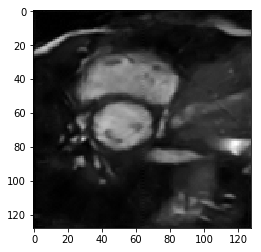

saving epoch {36}
Epoch: 37, Iteration: 1, Loss: 0.0008380965446121991, time: 2019-08-04 07:15:55.799924
Epoch: 37, Iteration: 101, Loss: 0.06324715309892781, time: 2019-08-04 07:17:54.688596
Epoch: 37, Iteration: 201, Loss: 0.13036413173540495, time: 2019-08-04 07:19:53.501763
Epoch: 37, Iteration: 301, Loss: 0.1991087353671901, time: 2019-08-04 07:21:52.632258
Epoch: 37, Iteration: 401, Loss: 0.26775307733623777, time: 2019-08-04 07:23:51.548719
Epoch: 37, Iteration: 501, Loss: 0.3457527622958878, time: 2019-08-04 07:25:50.632271
Epoch: 37, Iteration: 601, Loss: 0.421301486712764, time: 2019-08-04 07:27:49.497077
Epoch: 37, Iteration: 701, Loss: 0.4851711147784954, time: 2019-08-04 07:29:48.400016
Epoch: 37, Iteration: 801, Loss: 0.5481450694933301, time: 2019-08-04 07:31:47.350700
Epoch: 37, Iteration: 901, Loss: 0.6131803465104895, time: 2019-08-04 07:33:46.554566
Epoch: 37, Iteration: 1001, Loss: 0.6861350915132789, time: 2019-08-04 07:35:45.419585
Epoch: 37, Iteration: 1101, Loss

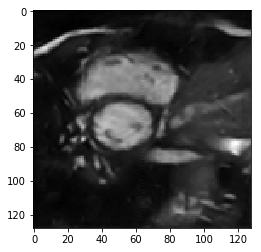

saving epoch {37}
Epoch: 38, Iteration: 1, Loss: 0.0005444757407531142, time: 2019-08-04 07:39:44.251786
Epoch: 38, Iteration: 101, Loss: 0.06707220408134162, time: 2019-08-04 07:41:43.231002
Epoch: 38, Iteration: 201, Loss: 0.13210514582169708, time: 2019-08-04 07:43:42.196970
Epoch: 38, Iteration: 301, Loss: 0.2012327570846537, time: 2019-08-04 07:45:40.934530
Epoch: 38, Iteration: 401, Loss: 0.2718590895674424, time: 2019-08-04 07:47:39.918255
Epoch: 38, Iteration: 501, Loss: 0.3383493839210132, time: 2019-08-04 07:49:39.019645
Epoch: 38, Iteration: 601, Loss: 0.41000622349383775, time: 2019-08-04 07:51:37.867054
Epoch: 38, Iteration: 701, Loss: 0.4767941407772014, time: 2019-08-04 07:53:36.892517
Epoch: 38, Iteration: 801, Loss: 0.5496587116358569, time: 2019-08-04 07:55:35.600185
Epoch: 38, Iteration: 901, Loss: 0.6157387937564636, time: 2019-08-04 07:57:34.577847
Epoch: 38, Iteration: 1001, Loss: 0.6835355187795358, time: 2019-08-04 07:59:33.477679
Epoch: 38, Iteration: 1101, Los

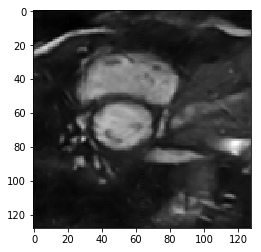

saving epoch {38}
Epoch: 39, Iteration: 1, Loss: 0.0010367634240537882, time: 2019-08-04 08:03:32.230816
Epoch: 39, Iteration: 101, Loss: 0.05958306284446735, time: 2019-08-04 08:05:31.258545
Epoch: 39, Iteration: 201, Loss: 0.12377740662486758, time: 2019-08-04 08:07:30.320690
Epoch: 39, Iteration: 301, Loss: 0.19568361226993147, time: 2019-08-04 08:09:29.245915
Epoch: 39, Iteration: 401, Loss: 0.26709754652983975, time: 2019-08-04 08:11:28.214782
Epoch: 39, Iteration: 501, Loss: 0.339759941372904, time: 2019-08-04 08:13:27.210623
Epoch: 39, Iteration: 601, Loss: 0.41739427657739725, time: 2019-08-04 08:15:26.398355
Epoch: 39, Iteration: 701, Loss: 0.48729757298133336, time: 2019-08-04 08:17:25.549354
Epoch: 39, Iteration: 801, Loss: 0.5504532910272246, time: 2019-08-04 08:19:24.426158
Epoch: 39, Iteration: 901, Loss: 0.6149855501571437, time: 2019-08-04 08:21:23.478907
Epoch: 39, Iteration: 1001, Loss: 0.6853020633134292, time: 2019-08-04 08:23:22.486452
Epoch: 39, Iteration: 1101, L

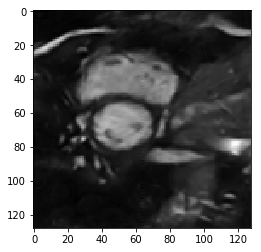

saving epoch {39}
Epoch: 40, Iteration: 1, Loss: 0.0006104650674387813, time: 2019-08-04 08:27:21.175682
Epoch: 40, Iteration: 101, Loss: 0.07216518640052527, time: 2019-08-04 08:29:19.989199
Epoch: 40, Iteration: 201, Loss: 0.13899832300376147, time: 2019-08-04 08:31:18.769781
Epoch: 40, Iteration: 301, Loss: 0.21336061744659673, time: 2019-08-04 08:33:17.669857
Epoch: 40, Iteration: 401, Loss: 0.2791015894181328, time: 2019-08-04 08:35:16.692311
Epoch: 40, Iteration: 501, Loss: 0.3417608650488546, time: 2019-08-04 08:37:15.244839
Epoch: 40, Iteration: 601, Loss: 0.4101284937351011, time: 2019-08-04 08:39:13.764093
Epoch: 40, Iteration: 701, Loss: 0.4765724148019217, time: 2019-08-04 08:41:12.617024
Epoch: 40, Iteration: 801, Loss: 0.5419034509686753, time: 2019-08-04 08:43:11.341866
Epoch: 40, Iteration: 901, Loss: 0.6040381749917287, time: 2019-08-04 08:45:10.210166
Epoch: 40, Iteration: 1001, Loss: 0.6746348194137681, time: 2019-08-04 08:47:09.024069
Epoch: 40, Iteration: 1101, Los

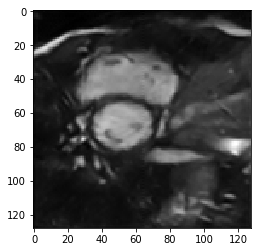

saving epoch {40}
Epoch: 41, Iteration: 1, Loss: 0.0006957957521080971, time: 2019-08-04 08:51:07.514527
Epoch: 41, Iteration: 101, Loss: 0.06471190400770865, time: 2019-08-04 08:53:06.267846
Epoch: 41, Iteration: 201, Loss: 0.126741756539559, time: 2019-08-04 08:55:04.875012
Epoch: 41, Iteration: 301, Loss: 0.18989269793382846, time: 2019-08-04 08:57:03.526694
Epoch: 41, Iteration: 401, Loss: 0.25682856800267473, time: 2019-08-04 08:59:02.222394
Epoch: 41, Iteration: 501, Loss: 0.3192407332826406, time: 2019-08-04 09:01:00.902235
Epoch: 41, Iteration: 601, Loss: 0.3868736334552523, time: 2019-08-04 09:02:59.398324
Epoch: 41, Iteration: 701, Loss: 0.45560234441654757, time: 2019-08-04 09:04:57.820893
Epoch: 41, Iteration: 801, Loss: 0.5245300477836281, time: 2019-08-04 09:06:56.545574
Epoch: 41, Iteration: 901, Loss: 0.5940536288253497, time: 2019-08-04 09:08:55.301533
Epoch: 41, Iteration: 1101, Loss: 0.7205214897112455, time: 2019-08-04 09:12:52.808333
1200
2019-08-04 09:14:50.307923

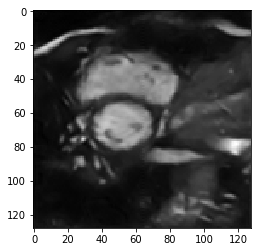

saving epoch {41}
Epoch: 42, Iteration: 1, Loss: 0.0013276699464768171, time: 2019-08-04 09:14:52.411920
Epoch: 42, Iteration: 101, Loss: 0.06300108590221498, time: 2019-08-04 09:16:51.614261
Epoch: 42, Iteration: 201, Loss: 0.13020160484302323, time: 2019-08-04 09:18:50.762851
Epoch: 42, Iteration: 301, Loss: 0.1960693561268272, time: 2019-08-04 09:20:49.537485
Epoch: 42, Iteration: 401, Loss: 0.2539662250346737, time: 2019-08-04 09:22:48.352196
Epoch: 42, Iteration: 501, Loss: 0.3169441234349506, time: 2019-08-04 09:24:47.398499
Epoch: 42, Iteration: 601, Loss: 0.38278203720983583, time: 2019-08-04 09:26:46.191084
Epoch: 42, Iteration: 701, Loss: 0.4435122445138404, time: 2019-08-04 09:28:44.758889
Epoch: 42, Iteration: 801, Loss: 0.5119478926499141, time: 2019-08-04 09:30:43.576686
Epoch: 42, Iteration: 901, Loss: 0.5788093928276794, time: 2019-08-04 09:32:42.308378
Epoch: 42, Iteration: 1001, Loss: 0.6466260314919055, time: 2019-08-04 09:34:41.019024
Epoch: 42, Iteration: 1101, Los

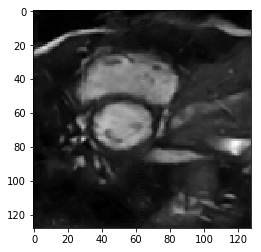

saving epoch {42}
Epoch: 43, Iteration: 1, Loss: 0.0007069922867231071, time: 2019-08-04 09:38:39.238635
Epoch: 43, Iteration: 101, Loss: 0.06941804784582928, time: 2019-08-04 09:40:38.174902
Epoch: 43, Iteration: 201, Loss: 0.1268570193060441, time: 2019-08-04 09:42:36.860891
Epoch: 43, Iteration: 301, Loss: 0.19009405985707417, time: 2019-08-04 09:44:35.712576
Epoch: 43, Iteration: 401, Loss: 0.25443877451471053, time: 2019-08-04 09:46:34.557281
Epoch: 43, Iteration: 501, Loss: 0.3203851699072402, time: 2019-08-04 09:48:33.315284
Epoch: 43, Iteration: 601, Loss: 0.3879883004410658, time: 2019-08-04 09:50:32.337697
Epoch: 43, Iteration: 701, Loss: 0.45150026348710526, time: 2019-08-04 09:52:31.219327
Epoch: 43, Iteration: 801, Loss: 0.5293098288966576, time: 2019-08-04 09:54:30.134527
Epoch: 43, Iteration: 901, Loss: 0.6001459060935304, time: 2019-08-04 09:56:28.835647
Epoch: 43, Iteration: 1001, Loss: 0.6613454216567334, time: 2019-08-04 09:58:27.744761
Epoch: 43, Iteration: 1101, Lo

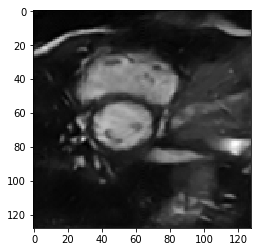

saving epoch {43}
Epoch: 44, Iteration: 1, Loss: 0.0005119076813571155, time: 2019-08-04 10:02:25.932009
Epoch: 44, Iteration: 101, Loss: 0.06398080234066583, time: 2019-08-04 10:04:24.327910
Epoch: 44, Iteration: 201, Loss: 0.12766347694559954, time: 2019-08-04 10:06:22.617976
Epoch: 44, Iteration: 301, Loss: 0.1926808891876135, time: 2019-08-04 10:08:21.222236
Epoch: 44, Iteration: 401, Loss: 0.2533518085256219, time: 2019-08-04 10:10:19.637170
Epoch: 44, Iteration: 501, Loss: 0.32335351037909277, time: 2019-08-04 10:12:18.101518
Epoch: 44, Iteration: 601, Loss: 0.3884038096002769, time: 2019-08-04 10:14:16.701482
Epoch: 44, Iteration: 701, Loss: 0.45317757554585114, time: 2019-08-04 10:16:15.326798
Epoch: 44, Iteration: 801, Loss: 0.5164927262521815, time: 2019-08-04 10:18:13.616444
Epoch: 44, Iteration: 901, Loss: 0.5812227289425209, time: 2019-08-04 10:20:12.129496
Epoch: 44, Iteration: 1001, Loss: 0.6441956646885956, time: 2019-08-04 10:22:10.522817
Epoch: 44, Iteration: 1101, Lo

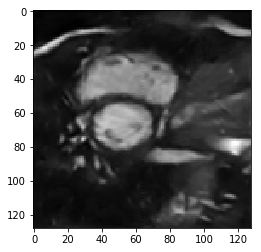

saving epoch {44}
Epoch: 45, Iteration: 1, Loss: 0.0005219955346547067, time: 2019-08-04 10:26:08.772054
Epoch: 45, Iteration: 101, Loss: 0.06250821624416858, time: 2019-08-04 10:28:07.568500
Epoch: 45, Iteration: 201, Loss: 0.11519424286962021, time: 2019-08-04 10:30:06.188404
Epoch: 45, Iteration: 301, Loss: 0.17951957150944509, time: 2019-08-04 10:32:04.884465
Epoch: 45, Iteration: 401, Loss: 0.24787106036092155, time: 2019-08-04 10:34:03.721001
Epoch: 45, Iteration: 501, Loss: 0.3130820449150633, time: 2019-08-04 10:36:02.461727
Epoch: 45, Iteration: 601, Loss: 0.37477888326975517, time: 2019-08-04 10:38:01.512230
Epoch: 45, Iteration: 701, Loss: 0.4346984751173295, time: 2019-08-04 10:40:00.435598
Epoch: 45, Iteration: 801, Loss: 0.4951748983730795, time: 2019-08-04 10:41:59.382785
Epoch: 45, Iteration: 901, Loss: 0.5625685073173372, time: 2019-08-04 10:43:58.304433
Epoch: 45, Iteration: 1001, Loss: 0.6301165432814742, time: 2019-08-04 10:45:57.338952
Epoch: 45, Iteration: 1101, L

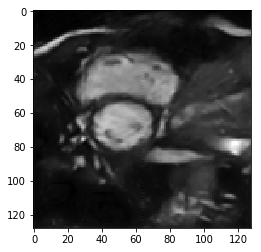

saving epoch {45}
Epoch: 46, Iteration: 1, Loss: 0.0007678495021536946, time: 2019-08-04 10:49:56.162883
Epoch: 46, Iteration: 101, Loss: 0.061905149355879985, time: 2019-08-04 10:51:54.927269
Epoch: 46, Iteration: 201, Loss: 0.11901583801954985, time: 2019-08-04 10:53:53.613515
Epoch: 46, Iteration: 301, Loss: 0.17934563508606516, time: 2019-08-04 10:55:52.334207
Epoch: 46, Iteration: 401, Loss: 0.23909992424887605, time: 2019-08-04 10:57:51.216437
Epoch: 46, Iteration: 501, Loss: 0.3006940381892491, time: 2019-08-04 10:59:50.003455
Epoch: 46, Iteration: 601, Loss: 0.367168896322255, time: 2019-08-04 11:01:48.868334
Epoch: 46, Iteration: 701, Loss: 0.43050733585550915, time: 2019-08-04 11:03:47.775012
Epoch: 46, Iteration: 801, Loss: 0.4968872951430967, time: 2019-08-04 11:05:46.547677
Epoch: 46, Iteration: 901, Loss: 0.5607279349205783, time: 2019-08-04 11:07:45.455175
Epoch: 46, Iteration: 1001, Loss: 0.6221329125546617, time: 2019-08-04 11:09:44.426638
Epoch: 46, Iteration: 1101, L

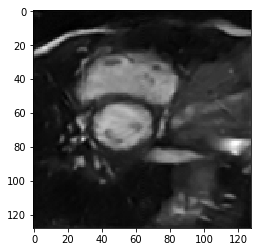

saving epoch {46}
Epoch: 47, Iteration: 1, Loss: 0.00041120470268651843, time: 2019-08-04 11:13:43.288386
Epoch: 47, Iteration: 101, Loss: 0.06505302934965584, time: 2019-08-04 11:15:42.190217
Epoch: 47, Iteration: 201, Loss: 0.1275185822887579, time: 2019-08-04 11:17:40.824556
Epoch: 47, Iteration: 301, Loss: 0.18252441988443024, time: 2019-08-04 11:19:39.246411
Epoch: 47, Iteration: 401, Loss: 0.24124922740156762, time: 2019-08-04 11:21:37.623980
Epoch: 47, Iteration: 501, Loss: 0.3095980863145087, time: 2019-08-04 11:23:35.960125
Epoch: 47, Iteration: 601, Loss: 0.3692471132671926, time: 2019-08-04 11:25:34.243720
Epoch: 47, Iteration: 701, Loss: 0.43555482194642536, time: 2019-08-04 11:27:32.816943
Epoch: 47, Iteration: 801, Loss: 0.5032590781338513, time: 2019-08-04 11:29:31.284789
Epoch: 47, Iteration: 901, Loss: 0.5754171337757725, time: 2019-08-04 11:31:29.712202
Epoch: 47, Iteration: 1001, Loss: 0.6305183923541335, time: 2019-08-04 11:33:27.820885
Epoch: 47, Iteration: 1101, L

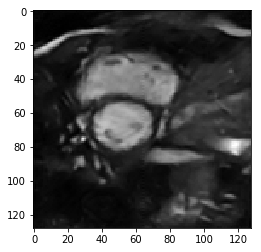

saving epoch {47}
Epoch: 48, Iteration: 1, Loss: 0.0010182448895648122, time: 2019-08-04 11:37:25.150586
Epoch: 48, Iteration: 101, Loss: 0.06111270296969451, time: 2019-08-04 11:39:23.140045
Epoch: 48, Iteration: 201, Loss: 0.11978462724073324, time: 2019-08-04 11:41:21.485294
Epoch: 48, Iteration: 301, Loss: 0.17657634007628076, time: 2019-08-04 11:43:19.724953
Epoch: 48, Iteration: 401, Loss: 0.24052451945317443, time: 2019-08-04 11:45:17.832515
Epoch: 48, Iteration: 501, Loss: 0.30233521077025216, time: 2019-08-04 11:47:16.126082
Epoch: 48, Iteration: 601, Loss: 0.3637949798867339, time: 2019-08-04 11:49:14.273878
Epoch: 48, Iteration: 701, Loss: 0.42237983213271946, time: 2019-08-04 11:51:12.407573
Epoch: 48, Iteration: 801, Loss: 0.48056274445843883, time: 2019-08-04 11:53:10.522363
Epoch: 48, Iteration: 901, Loss: 0.5390140424133278, time: 2019-08-04 11:55:08.771373
Epoch: 48, Iteration: 1001, Loss: 0.6046983241394628, time: 2019-08-04 11:57:07.030531
Epoch: 48, Iteration: 1101,

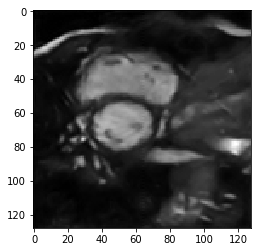

saving epoch {48}
Epoch: 49, Iteration: 1, Loss: 0.0005983750452287495, time: 2019-08-04 12:01:03.875269
Epoch: 49, Iteration: 101, Loss: 0.07314498323830776, time: 2019-08-04 12:03:01.848772
Epoch: 49, Iteration: 201, Loss: 0.13503435713937506, time: 2019-08-04 12:04:59.828731
Epoch: 49, Iteration: 301, Loss: 0.19551218177366536, time: 2019-08-04 12:06:57.765186
Epoch: 49, Iteration: 401, Loss: 0.2520894351619063, time: 2019-08-04 12:08:55.683242
Epoch: 49, Iteration: 501, Loss: 0.31195163997472264, time: 2019-08-04 12:10:53.597111
Epoch: 49, Iteration: 601, Loss: 0.37497550365515053, time: 2019-08-04 12:12:51.399194
Epoch: 49, Iteration: 701, Loss: 0.44242595220566727, time: 2019-08-04 12:14:49.444258
Epoch: 49, Iteration: 801, Loss: 0.5058897687558783, time: 2019-08-04 12:16:47.275134
Epoch: 49, Iteration: 901, Loss: 0.5658014838845702, time: 2019-08-04 12:18:45.036527
Epoch: 49, Iteration: 1001, Loss: 0.6243728373228805, time: 2019-08-04 12:20:43.553711
Epoch: 49, Iteration: 1101, 

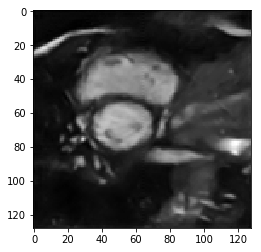

saving epoch {49}
Epoch: 50, Iteration: 1, Loss: 0.00040727428859099746, time: 2019-08-04 12:24:41.741261
Epoch: 50, Iteration: 101, Loss: 0.06316025472187903, time: 2019-08-04 12:26:40.419133
Epoch: 50, Iteration: 201, Loss: 0.12571840167220216, time: 2019-08-04 12:28:38.293879
Epoch: 50, Iteration: 301, Loss: 0.17921895936888177, time: 2019-08-04 12:30:36.291396
Epoch: 50, Iteration: 401, Loss: 0.2349864034622442, time: 2019-08-04 12:32:34.033337
Epoch: 50, Iteration: 501, Loss: 0.29243218009651173, time: 2019-08-04 12:34:31.900632
Epoch: 50, Iteration: 601, Loss: 0.3557666646229336, time: 2019-08-04 12:36:29.391828
Epoch: 50, Iteration: 701, Loss: 0.419420223828638, time: 2019-08-04 12:38:27.103212
Epoch: 50, Iteration: 801, Loss: 0.48317618637520354, time: 2019-08-04 12:40:24.689289
Epoch: 50, Iteration: 901, Loss: 0.5504726626822958, time: 2019-08-04 12:42:22.305975
Epoch: 50, Iteration: 1001, Loss: 0.6128596979106078, time: 2019-08-04 12:44:20.427938
Epoch: 50, Iteration: 1101, L

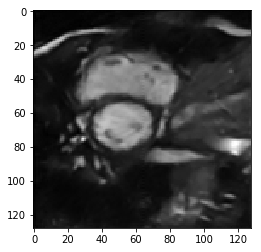

saving epoch {50}
Epoch: 51, Iteration: 1, Loss: 0.00043552363058552146, time: 2019-08-04 12:48:17.297874
Epoch: 51, Iteration: 101, Loss: 0.0528924719983479, time: 2019-08-04 12:50:15.342035
Epoch: 51, Iteration: 201, Loss: 0.11287831950176042, time: 2019-08-04 12:52:13.192871
Epoch: 51, Iteration: 301, Loss: 0.1750465494551463, time: 2019-08-04 12:54:11.054879
Epoch: 51, Iteration: 401, Loss: 0.23675452478346415, time: 2019-08-04 12:56:08.980332
Epoch: 51, Iteration: 501, Loss: 0.292066752910614, time: 2019-08-04 12:58:06.737590
Epoch: 51, Iteration: 601, Loss: 0.3485313625424169, time: 2019-08-04 13:00:04.502738
Epoch: 51, Iteration: 701, Loss: 0.4090514144045301, time: 2019-08-04 13:02:02.214537
Epoch: 51, Iteration: 801, Loss: 0.4679304870660417, time: 2019-08-04 13:04:00.322729
Epoch: 51, Iteration: 901, Loss: 0.5329186842427589, time: 2019-08-04 13:05:58.602846
Epoch: 51, Iteration: 1001, Loss: 0.592912000400247, time: 2019-08-04 13:07:56.578104
Epoch: 51, Iteration: 1101, Loss:

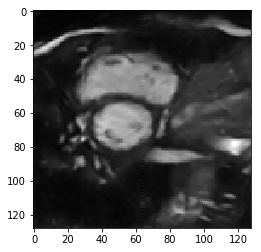

saving epoch {51}
Epoch: 52, Iteration: 1, Loss: 0.0003868854546453804, time: 2019-08-04 13:11:53.260318
Epoch: 52, Iteration: 101, Loss: 0.0590921540861018, time: 2019-08-04 13:13:51.089859
Epoch: 52, Iteration: 201, Loss: 0.11694658285705373, time: 2019-08-04 13:15:49.344301
Epoch: 52, Iteration: 301, Loss: 0.17021600746375043, time: 2019-08-04 13:17:47.208193
Epoch: 52, Iteration: 401, Loss: 0.22738540156569798, time: 2019-08-04 13:19:44.861900
Epoch: 52, Iteration: 501, Loss: 0.28384656990238, time: 2019-08-04 13:21:42.460442
Epoch: 52, Iteration: 601, Loss: 0.3456403364689322, time: 2019-08-04 13:23:40.102971
Epoch: 52, Iteration: 701, Loss: 0.4122372092824662, time: 2019-08-04 13:25:37.902441
Epoch: 52, Iteration: 801, Loss: 0.4805046614492312, time: 2019-08-04 13:27:35.747335
Epoch: 52, Iteration: 901, Loss: 0.5422276047756895, time: 2019-08-04 13:29:33.712271
Epoch: 52, Iteration: 1001, Loss: 0.6003754256526008, time: 2019-08-04 13:31:31.656685
Epoch: 52, Iteration: 1101, Loss:

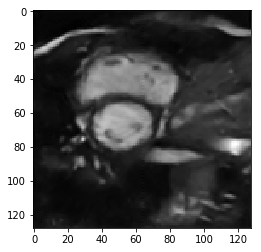

saving epoch {52}
Epoch: 53, Iteration: 1, Loss: 0.0011349553242325783, time: 2019-08-04 13:35:28.365734
Epoch: 53, Iteration: 101, Loss: 0.0605664509057533, time: 2019-08-04 13:37:26.028451
Epoch: 53, Iteration: 201, Loss: 0.11982263953541405, time: 2019-08-04 13:39:23.979272
Epoch: 53, Iteration: 301, Loss: 0.17670098048984073, time: 2019-08-04 13:41:22.141338
Epoch: 53, Iteration: 401, Loss: 0.23559862282127142, time: 2019-08-04 13:43:20.329191
Epoch: 53, Iteration: 501, Loss: 0.29605111593264155, time: 2019-08-04 13:45:18.536606
Epoch: 53, Iteration: 601, Loss: 0.35117018688470125, time: 2019-08-04 13:47:17.606426
Epoch: 53, Iteration: 701, Loss: 0.40087390708504245, time: 2019-08-04 13:49:16.679053
Epoch: 53, Iteration: 801, Loss: 0.46463071313337423, time: 2019-08-04 13:51:15.608095
Epoch: 53, Iteration: 901, Loss: 0.5239286954601994, time: 2019-08-04 13:53:14.577525
Epoch: 53, Iteration: 1001, Loss: 0.5858235077612335, time: 2019-08-04 13:55:13.511210
Epoch: 53, Iteration: 1101,

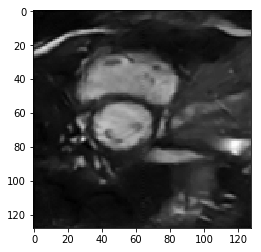

saving epoch {53}
Epoch: 54, Iteration: 1, Loss: 0.000845967442728579, time: 2019-08-04 13:59:12.142715
Epoch: 54, Iteration: 101, Loss: 0.056011574910371564, time: 2019-08-04 14:01:10.893436
Epoch: 54, Iteration: 201, Loss: 0.1117117610265268, time: 2019-08-04 14:03:09.623716
Epoch: 54, Iteration: 301, Loss: 0.17065131620620377, time: 2019-08-04 14:05:08.403254
Epoch: 54, Iteration: 401, Loss: 0.22864040544664022, time: 2019-08-04 14:07:07.313507
Epoch: 54, Iteration: 501, Loss: 0.28782341808255296, time: 2019-08-04 14:09:06.117852
Epoch: 54, Iteration: 601, Loss: 0.34254298875748646, time: 2019-08-04 14:11:04.970222
Epoch: 54, Iteration: 701, Loss: 0.4092693922430044, time: 2019-08-04 14:13:03.751164
Epoch: 54, Iteration: 801, Loss: 0.46559333920595236, time: 2019-08-04 14:15:02.685520
Epoch: 54, Iteration: 901, Loss: 0.5218635897472268, time: 2019-08-04 14:17:01.612149
Epoch: 54, Iteration: 1001, Loss: 0.5803398626449052, time: 2019-08-04 14:19:00.468682
Epoch: 54, Iteration: 1101, 

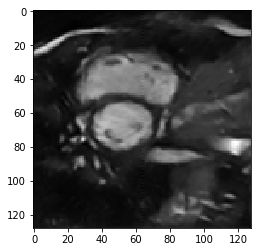

saving epoch {54}
Epoch: 55, Iteration: 1, Loss: 0.00039760550134815276, time: 2019-08-04 14:22:59.214920
Epoch: 55, Iteration: 101, Loss: 0.05328479483432602, time: 2019-08-04 14:24:57.900902
Epoch: 55, Iteration: 201, Loss: 0.11931526099215262, time: 2019-08-04 14:26:56.449656
Epoch: 55, Iteration: 301, Loss: 0.17311492979933973, time: 2019-08-04 14:28:54.843596
Epoch: 55, Iteration: 401, Loss: 0.23431214461743366, time: 2019-08-04 14:30:53.076108
Epoch: 55, Iteration: 501, Loss: 0.2978091952536488, time: 2019-08-04 14:32:51.321957
Epoch: 55, Iteration: 601, Loss: 0.3560089333477663, time: 2019-08-04 14:34:49.469612
Epoch: 55, Iteration: 701, Loss: 0.410511483787559, time: 2019-08-04 14:36:47.737355
Epoch: 55, Iteration: 801, Loss: 0.46774743538117036, time: 2019-08-04 14:38:45.999105
Epoch: 55, Iteration: 901, Loss: 0.5242538492602762, time: 2019-08-04 14:40:44.297206
Epoch: 55, Iteration: 1001, Loss: 0.5777666264184518, time: 2019-08-04 14:42:42.532809
Epoch: 55, Iteration: 1101, L

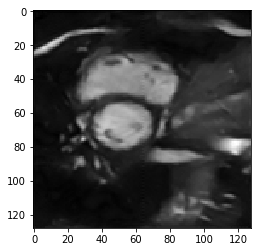

saving epoch {55}
Epoch: 56, Iteration: 1, Loss: 0.0003158567997161299, time: 2019-08-04 14:46:39.900185
Epoch: 56, Iteration: 101, Loss: 0.056554043607320637, time: 2019-08-04 14:48:38.243537
Epoch: 56, Iteration: 201, Loss: 0.11346661375137046, time: 2019-08-04 14:50:36.468494
Epoch: 56, Iteration: 301, Loss: 0.17022746047587134, time: 2019-08-04 14:52:34.744282
Epoch: 56, Iteration: 401, Loss: 0.22824418373056687, time: 2019-08-04 14:54:32.990484
Epoch: 56, Iteration: 501, Loss: 0.2927661519497633, time: 2019-08-04 14:56:30.904110
Epoch: 56, Iteration: 601, Loss: 0.34877767620491795, time: 2019-08-04 14:58:29.071750
Epoch: 56, Iteration: 701, Loss: 0.40600461294525303, time: 2019-08-04 15:00:27.430262
Epoch: 56, Iteration: 801, Loss: 0.4661531680612825, time: 2019-08-04 15:02:25.686777
Epoch: 56, Iteration: 901, Loss: 0.5201257302542217, time: 2019-08-04 15:04:23.797338
Epoch: 56, Iteration: 1001, Loss: 0.5718538785440614, time: 2019-08-04 15:06:21.775196
Epoch: 56, Iteration: 1101,

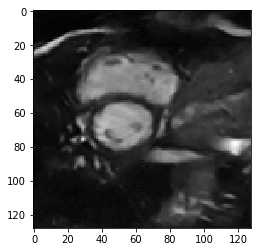

saving epoch {56}
Epoch: 57, Iteration: 1, Loss: 0.0004619121609721333, time: 2019-08-04 15:10:18.764135
Epoch: 57, Iteration: 101, Loss: 0.05851531725784298, time: 2019-08-04 15:12:16.886225
Epoch: 57, Iteration: 201, Loss: 0.11017942395119462, time: 2019-08-04 15:14:14.984341
Epoch: 57, Iteration: 301, Loss: 0.16496181741240434, time: 2019-08-04 15:16:13.013310
Epoch: 57, Iteration: 401, Loss: 0.22329556974000297, time: 2019-08-04 15:18:11.133549
Epoch: 57, Iteration: 501, Loss: 0.27819614138570614, time: 2019-08-04 15:20:09.407095
Epoch: 57, Iteration: 601, Loss: 0.3364439721335657, time: 2019-08-04 15:22:07.497936
Epoch: 57, Iteration: 701, Loss: 0.3872258521587355, time: 2019-08-04 15:24:05.459183
Epoch: 57, Iteration: 801, Loss: 0.44463643337076064, time: 2019-08-04 15:26:03.540661
Epoch: 57, Iteration: 901, Loss: 0.5063029263837961, time: 2019-08-04 15:28:01.726804
Epoch: 57, Iteration: 1001, Loss: 0.5624709475232521, time: 2019-08-04 15:29:59.805140
Epoch: 57, Iteration: 1101, 

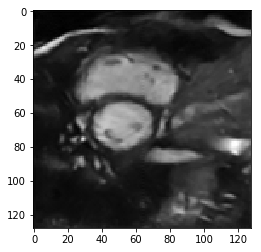

saving epoch {57}
Epoch: 58, Iteration: 1, Loss: 0.00036374255432747304, time: 2019-08-04 15:33:56.908588
Epoch: 58, Iteration: 101, Loss: 0.05221434612758458, time: 2019-08-04 15:35:55.227584
Epoch: 58, Iteration: 201, Loss: 0.1167384815053083, time: 2019-08-04 15:37:53.067035
Epoch: 58, Iteration: 301, Loss: 0.1753042921773158, time: 2019-08-04 15:39:50.889771
Epoch: 58, Iteration: 401, Loss: 0.23920563433784992, time: 2019-08-04 15:41:48.694531
Epoch: 58, Iteration: 501, Loss: 0.29592518135905266, time: 2019-08-04 15:43:46.501441
Epoch: 58, Iteration: 601, Loss: 0.3501529043132905, time: 2019-08-04 15:45:44.271220
Epoch: 58, Iteration: 701, Loss: 0.40501533076167107, time: 2019-08-04 15:47:41.941503
Epoch: 58, Iteration: 801, Loss: 0.4579612889647251, time: 2019-08-04 15:49:39.723386
Epoch: 58, Iteration: 901, Loss: 0.5106808532291325, time: 2019-08-04 15:51:37.273224
Epoch: 58, Iteration: 1001, Loss: 0.5676644123595906, time: 2019-08-04 15:53:34.599748
Epoch: 58, Iteration: 1101, L

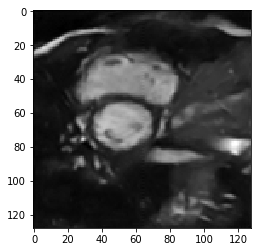

saving epoch {58}
Epoch: 59, Iteration: 1, Loss: 0.0004287677875254303, time: 2019-08-04 15:57:30.218828
Epoch: 59, Iteration: 101, Loss: 0.05398381609120406, time: 2019-08-04 15:59:27.657656
Epoch: 59, Iteration: 201, Loss: 0.10703307946096174, time: 2019-08-04 16:01:25.414970
Epoch: 59, Iteration: 301, Loss: 0.16388361097779125, time: 2019-08-04 16:03:22.892598
Epoch: 59, Iteration: 401, Loss: 0.2168474170321133, time: 2019-08-04 16:05:20.464209
Epoch: 59, Iteration: 501, Loss: 0.27100312324182596, time: 2019-08-04 16:07:18.388634
Epoch: 59, Iteration: 601, Loss: 0.3249463952088263, time: 2019-08-04 16:09:15.933311
Epoch: 59, Iteration: 701, Loss: 0.38219181790191215, time: 2019-08-04 16:11:13.499993
Epoch: 59, Iteration: 801, Loss: 0.43435190575837623, time: 2019-08-04 16:13:11.333794
Epoch: 59, Iteration: 901, Loss: 0.488077479734784, time: 2019-08-04 16:15:09.161330
Epoch: 59, Iteration: 1001, Loss: 0.5416115412517684, time: 2019-08-04 16:17:06.912627
Epoch: 59, Iteration: 1101, L

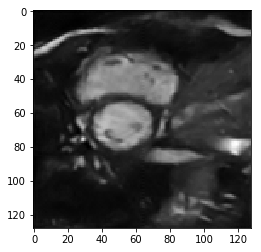

saving epoch {59}
Epoch: 60, Iteration: 1, Loss: 0.000356418575393036, time: 2019-08-04 16:21:03.725475
Epoch: 60, Iteration: 101, Loss: 0.05191016886965372, time: 2019-08-04 16:23:02.377839
Epoch: 60, Iteration: 201, Loss: 0.10444005922181532, time: 2019-08-04 16:25:00.831712
Epoch: 60, Iteration: 301, Loss: 0.15800367313204333, time: 2019-08-04 16:26:59.643107
Epoch: 60, Iteration: 401, Loss: 0.20862973254406825, time: 2019-08-04 16:28:57.747404
Epoch: 60, Iteration: 501, Loss: 0.25790747460268904, time: 2019-08-04 16:30:55.354163
Epoch: 60, Iteration: 601, Loss: 0.3122576453461079, time: 2019-08-04 16:32:53.443560
Epoch: 60, Iteration: 701, Loss: 0.36625071792514063, time: 2019-08-04 16:34:51.394770
Epoch: 60, Iteration: 801, Loss: 0.42627506295684725, time: 2019-08-04 16:36:49.375771
Epoch: 60, Iteration: 901, Loss: 0.486922285403125, time: 2019-08-04 16:38:46.052358
Epoch: 60, Iteration: 1001, Loss: 0.5498443126416532, time: 2019-08-04 16:40:42.655694
Epoch: 60, Iteration: 1101, L

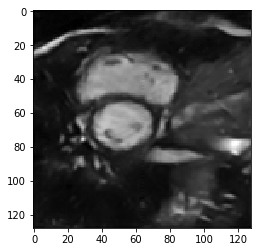

saving epoch {60}
Epoch: 61, Iteration: 1, Loss: 0.000710860185790807, time: 2019-08-04 16:44:36.621518
Epoch: 61, Iteration: 101, Loss: 0.05521413675160147, time: 2019-08-04 16:46:33.261555
Epoch: 61, Iteration: 201, Loss: 0.11061902486835606, time: 2019-08-04 16:48:29.978075
Epoch: 61, Iteration: 301, Loss: 0.1631900244683493, time: 2019-08-04 16:50:26.580141
Epoch: 61, Iteration: 401, Loss: 0.219120402020053, time: 2019-08-04 16:52:23.089708
Epoch: 61, Iteration: 501, Loss: 0.27100610731577035, time: 2019-08-04 16:54:19.668832
Epoch: 61, Iteration: 601, Loss: 0.3228511393535882, time: 2019-08-04 16:56:16.309423
Epoch: 61, Iteration: 701, Loss: 0.3749825578124728, time: 2019-08-04 16:58:12.821136
Epoch: 61, Iteration: 801, Loss: 0.43621107790386304, time: 2019-08-04 17:00:09.402883
Epoch: 61, Iteration: 901, Loss: 0.4951979628385743, time: 2019-08-04 17:02:05.903053
Epoch: 61, Iteration: 1001, Loss: 0.5567728242458543, time: 2019-08-04 17:04:02.397845
Epoch: 61, Iteration: 1101, Loss

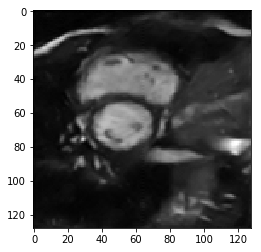

saving epoch {61}
Epoch: 62, Iteration: 1, Loss: 0.00041892900480888784, time: 2019-08-04 17:07:56.315126
Epoch: 62, Iteration: 101, Loss: 0.052512435970129445, time: 2019-08-04 17:09:52.792521
Epoch: 62, Iteration: 201, Loss: 0.1066355411458062, time: 2019-08-04 17:11:49.290516
Epoch: 62, Iteration: 301, Loss: 0.1592246668296866, time: 2019-08-04 17:13:45.751899
Epoch: 62, Iteration: 401, Loss: 0.2136038336175261, time: 2019-08-04 17:15:42.304448
Epoch: 62, Iteration: 501, Loss: 0.2730001786840148, time: 2019-08-04 17:17:38.744601
Epoch: 62, Iteration: 601, Loss: 0.3294518582697492, time: 2019-08-04 17:19:35.200817
Epoch: 62, Iteration: 701, Loss: 0.3784932812413899, time: 2019-08-04 17:21:31.694188
Epoch: 62, Iteration: 801, Loss: 0.4311783183948137, time: 2019-08-04 17:23:28.168208
Epoch: 62, Iteration: 901, Loss: 0.4860849874530686, time: 2019-08-04 17:25:24.580737
Epoch: 62, Iteration: 1001, Loss: 0.5363339072355302, time: 2019-08-04 17:27:21.084268
Epoch: 62, Iteration: 1101, Los

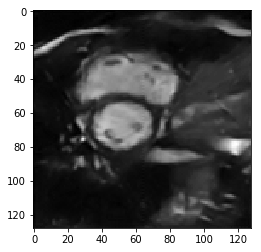

saving epoch {62}
Epoch: 63, Iteration: 1, Loss: 0.0004855083825532347, time: 2019-08-04 17:31:14.984703
Epoch: 63, Iteration: 101, Loss: 0.05552882769552525, time: 2019-08-04 17:33:11.466474
Epoch: 63, Iteration: 201, Loss: 0.11360491023515351, time: 2019-08-04 17:35:07.873799
Epoch: 63, Iteration: 301, Loss: 0.1636964740755502, time: 2019-08-04 17:37:04.313906
Epoch: 63, Iteration: 401, Loss: 0.22248957373085432, time: 2019-08-04 17:39:00.840963
Epoch: 63, Iteration: 501, Loss: 0.27541973341431003, time: 2019-08-04 17:40:57.342473
Epoch: 63, Iteration: 601, Loss: 0.33125945791834965, time: 2019-08-04 17:42:53.773547
Epoch: 63, Iteration: 701, Loss: 0.3886988345620921, time: 2019-08-04 17:44:50.348558
Epoch: 63, Iteration: 801, Loss: 0.44014378139399923, time: 2019-08-04 17:46:46.873869
Epoch: 63, Iteration: 901, Loss: 0.4979886283108499, time: 2019-08-04 17:48:43.345865
Epoch: 63, Iteration: 1001, Loss: 0.5547263862099499, time: 2019-08-04 17:50:39.927512
Epoch: 63, Iteration: 1101, 

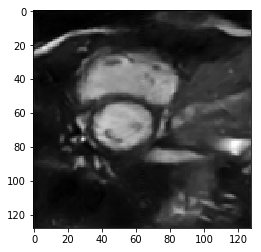

saving epoch {63}
Epoch: 64, Iteration: 1, Loss: 0.0006359716644510627, time: 2019-08-04 17:54:33.871419
Epoch: 64, Iteration: 101, Loss: 0.055258533466258086, time: 2019-08-04 17:56:30.271384
Epoch: 64, Iteration: 201, Loss: 0.1063905344781233, time: 2019-08-04 17:58:26.712829
Epoch: 64, Iteration: 301, Loss: 0.1610651492519537, time: 2019-08-04 18:00:23.170684
Epoch: 64, Iteration: 401, Loss: 0.2154395954712527, time: 2019-08-04 18:02:19.611763
Epoch: 64, Iteration: 501, Loss: 0.27459697153244633, time: 2019-08-04 18:04:16.059264
Epoch: 64, Iteration: 601, Loss: 0.34055044151318725, time: 2019-08-04 18:06:12.576763
Epoch: 64, Iteration: 701, Loss: 0.39299171640595887, time: 2019-08-04 18:08:09.167603
Epoch: 64, Iteration: 801, Loss: 0.4448986415809486, time: 2019-08-04 18:10:05.807264
Epoch: 64, Iteration: 901, Loss: 0.5040360859420616, time: 2019-08-04 18:12:02.332318
Epoch: 64, Iteration: 1001, Loss: 0.5608241056906991, time: 2019-08-04 18:13:58.881945
Epoch: 64, Iteration: 1101, L

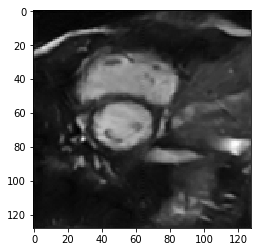

saving epoch {64}
Epoch: 65, Iteration: 1, Loss: 0.0009212457807734609, time: 2019-08-04 18:17:52.658802
Epoch: 65, Iteration: 101, Loss: 0.05260015954263508, time: 2019-08-04 18:19:49.148079
Epoch: 65, Iteration: 201, Loss: 0.1077364091470372, time: 2019-08-04 18:21:46.235563
Epoch: 65, Iteration: 301, Loss: 0.16726015877793543, time: 2019-08-04 18:23:43.245826
Epoch: 65, Iteration: 401, Loss: 0.21446995460428298, time: 2019-08-04 18:25:40.054652
Epoch: 65, Iteration: 501, Loss: 0.2670796090969816, time: 2019-08-04 18:27:36.807336
Epoch: 65, Iteration: 601, Loss: 0.33093175587418955, time: 2019-08-04 18:29:33.510921
Epoch: 65, Iteration: 701, Loss: 0.3874511330941459, time: 2019-08-04 18:31:30.070460
Epoch: 65, Iteration: 801, Loss: 0.4466297947365092, time: 2019-08-04 18:33:26.535352
Epoch: 65, Iteration: 901, Loss: 0.5009174086735584, time: 2019-08-04 18:35:23.011720
Epoch: 65, Iteration: 1001, Loss: 0.5577318612486124, time: 2019-08-04 18:37:19.651306
Epoch: 65, Iteration: 1101, Lo

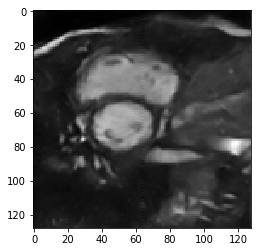

saving epoch {65}
Epoch: 66, Iteration: 1, Loss: 0.00034252190380357206, time: 2019-08-04 18:41:15.007274
Epoch: 66, Iteration: 101, Loss: 0.05093293622485362, time: 2019-08-04 18:43:11.554620
Epoch: 66, Iteration: 201, Loss: 0.10187920635507908, time: 2019-08-04 18:45:08.176624
Epoch: 66, Iteration: 301, Loss: 0.15209462509665173, time: 2019-08-04 18:47:04.794919
Epoch: 66, Iteration: 401, Loss: 0.2080741504469188, time: 2019-08-04 18:49:01.226933
Epoch: 66, Iteration: 501, Loss: 0.25486265220388304, time: 2019-08-04 18:50:57.577317
Epoch: 66, Iteration: 601, Loss: 0.304062264985987, time: 2019-08-04 18:52:54.840340
Epoch: 66, Iteration: 701, Loss: 0.35791079710179474, time: 2019-08-04 18:54:52.454976
Epoch: 66, Iteration: 801, Loss: 0.41938726662192494, time: 2019-08-04 18:56:50.055175
Epoch: 66, Iteration: 901, Loss: 0.48270826242514886, time: 2019-08-04 18:58:47.794450
Epoch: 66, Iteration: 1001, Loss: 0.534490037971409, time: 2019-08-04 19:00:45.391267
Epoch: 66, Iteration: 1101, 

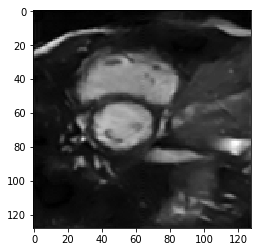

saving epoch {66}
Epoch: 67, Iteration: 1, Loss: 0.0005034114001318812, time: 2019-08-04 19:04:41.832079
Epoch: 67, Iteration: 101, Loss: 0.052350799276609905, time: 2019-08-04 19:06:39.455411
Epoch: 67, Iteration: 201, Loss: 0.10296507459133863, time: 2019-08-04 19:08:37.145017
Epoch: 67, Iteration: 301, Loss: 0.15534078776545357, time: 2019-08-04 19:10:34.773838
Epoch: 67, Iteration: 401, Loss: 0.20858884871995542, time: 2019-08-04 19:12:32.433964
Epoch: 67, Iteration: 501, Loss: 0.2572779188194545, time: 2019-08-04 19:14:29.965679
Epoch: 67, Iteration: 601, Loss: 0.3139826285914751, time: 2019-08-04 19:16:27.682504
Epoch: 67, Iteration: 701, Loss: 0.36198693164624274, time: 2019-08-04 19:18:25.563583
Epoch: 67, Iteration: 801, Loss: 0.41572926871594973, time: 2019-08-04 19:20:23.263165
Epoch: 67, Iteration: 901, Loss: 0.4702229025424458, time: 2019-08-04 19:22:20.879733
Epoch: 67, Iteration: 1001, Loss: 0.5262601680296939, time: 2019-08-04 19:24:18.506451
Epoch: 67, Iteration: 1101,

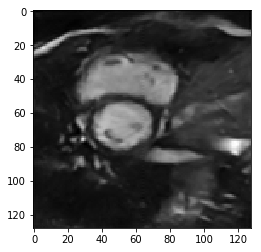

saving epoch {67}
Epoch: 68, Iteration: 1, Loss: 0.0005213703843764961, time: 2019-08-04 19:28:14.560062
Epoch: 68, Iteration: 101, Loss: 0.05241047704475932, time: 2019-08-04 19:30:12.387179
Epoch: 68, Iteration: 201, Loss: 0.10257289807486814, time: 2019-08-04 19:32:09.991912
Epoch: 68, Iteration: 301, Loss: 0.15314912868780084, time: 2019-08-04 19:34:08.044243
Epoch: 68, Iteration: 401, Loss: 0.20446143120352644, time: 2019-08-04 19:36:05.638382
Epoch: 68, Iteration: 501, Loss: 0.2588682031346252, time: 2019-08-04 19:38:03.441900
Epoch: 68, Iteration: 601, Loss: 0.31165651892661117, time: 2019-08-04 19:40:01.232928
Epoch: 68, Iteration: 701, Loss: 0.35909072967479005, time: 2019-08-04 19:41:58.862944
Epoch: 68, Iteration: 801, Loss: 0.4123118967982009, time: 2019-08-04 19:43:56.544052
Epoch: 68, Iteration: 901, Loss: 0.4660957941086963, time: 2019-08-04 19:45:54.348587
Epoch: 68, Iteration: 1001, Loss: 0.5223178302403539, time: 2019-08-04 19:47:52.183762
Epoch: 68, Iteration: 1101, 

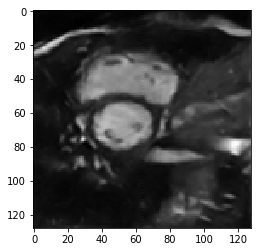

saving epoch {68}
Epoch: 69, Iteration: 1, Loss: 0.0005831735325045884, time: 2019-08-04 19:51:48.579978
Epoch: 69, Iteration: 101, Loss: 0.05133765684149694, time: 2019-08-04 19:53:46.383365
Epoch: 69, Iteration: 201, Loss: 0.10352839602273889, time: 2019-08-04 19:55:44.157781
Epoch: 69, Iteration: 301, Loss: 0.15539809135952964, time: 2019-08-04 19:57:41.909710
Epoch: 69, Iteration: 401, Loss: 0.20714272986515425, time: 2019-08-04 19:59:39.776491
Epoch: 69, Iteration: 501, Loss: 0.2606998225528514, time: 2019-08-04 20:01:37.819518
Epoch: 69, Iteration: 601, Loss: 0.31623970485816244, time: 2019-08-04 20:03:35.673093
Epoch: 69, Iteration: 701, Loss: 0.36897692024649587, time: 2019-08-04 20:05:33.396480
Epoch: 69, Iteration: 801, Loss: 0.42210163053823635, time: 2019-08-04 20:07:31.750893
Epoch: 69, Iteration: 901, Loss: 0.4742966167978011, time: 2019-08-04 20:09:30.060335
Epoch: 69, Iteration: 1001, Loss: 0.5261141818045871, time: 2019-08-04 20:11:28.371382
Epoch: 69, Iteration: 1101,

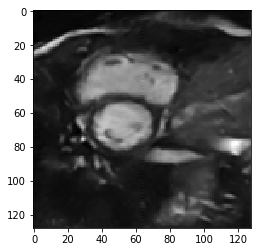

saving epoch {69}
Epoch: 70, Iteration: 1, Loss: 0.0004732315428555012, time: 2019-08-04 20:15:26.242884
Epoch: 70, Iteration: 101, Loss: 0.054845471153385006, time: 2019-08-04 20:17:24.321943
Epoch: 70, Iteration: 201, Loss: 0.1090303082310129, time: 2019-08-04 20:19:22.703053
Epoch: 70, Iteration: 301, Loss: 0.1609316833782941, time: 2019-08-04 20:21:21.273419
Epoch: 70, Iteration: 401, Loss: 0.21114487426530104, time: 2019-08-04 20:23:19.598969
Epoch: 70, Iteration: 501, Loss: 0.26630099525209516, time: 2019-08-04 20:25:18.722123
Epoch: 70, Iteration: 601, Loss: 0.3193176543718437, time: 2019-08-04 20:27:17.753379
Epoch: 70, Iteration: 701, Loss: 0.37170997449720744, time: 2019-08-04 20:29:16.436291
Epoch: 70, Iteration: 801, Loss: 0.4235132319299737, time: 2019-08-04 20:31:14.894550
Epoch: 70, Iteration: 901, Loss: 0.4830937051883666, time: 2019-08-04 20:33:13.589500
Epoch: 70, Iteration: 1001, Loss: 0.538755199246225, time: 2019-08-04 20:35:12.240123
Epoch: 70, Iteration: 1101, Lo

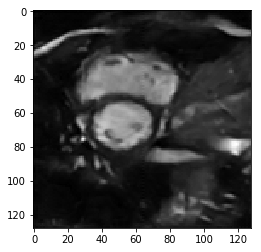

saving epoch {70}
Epoch: 71, Iteration: 1, Loss: 0.0008781601791270077, time: 2019-08-04 20:39:10.288101
Epoch: 71, Iteration: 101, Loss: 0.04915446382074151, time: 2019-08-04 20:41:08.711824
Epoch: 71, Iteration: 201, Loss: 0.09955225387238897, time: 2019-08-04 20:43:07.070683
Epoch: 71, Iteration: 301, Loss: 0.15385341545334086, time: 2019-08-04 20:45:05.740560
Epoch: 71, Iteration: 401, Loss: 0.21205642652057577, time: 2019-08-04 20:47:04.128879
Epoch: 71, Iteration: 501, Loss: 0.2649715974839637, time: 2019-08-04 20:49:02.845993
Epoch: 71, Iteration: 601, Loss: 0.3182621170562925, time: 2019-08-04 20:51:01.937839
Epoch: 71, Iteration: 701, Loss: 0.37333144528383855, time: 2019-08-04 20:53:00.751287
Epoch: 71, Iteration: 801, Loss: 0.42219739768188447, time: 2019-08-04 20:54:59.489520
Epoch: 71, Iteration: 901, Loss: 0.4732737093727337, time: 2019-08-04 20:56:58.373279
Epoch: 71, Iteration: 1001, Loss: 0.524911808402976, time: 2019-08-04 20:58:56.625867
Epoch: 71, Iteration: 1101, L

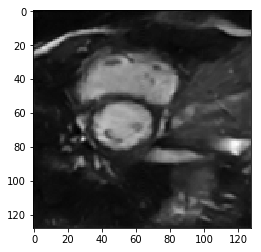

saving epoch {71}
Epoch: 72, Iteration: 1, Loss: 0.0005408736760728061, time: 2019-08-04 21:02:55.158830
Epoch: 72, Iteration: 101, Loss: 0.04719986299460288, time: 2019-08-04 21:04:53.820083
Epoch: 72, Iteration: 201, Loss: 0.09698690897494089, time: 2019-08-04 21:06:52.099370
Epoch: 72, Iteration: 301, Loss: 0.14565794097143225, time: 2019-08-04 21:08:50.369255
Epoch: 72, Iteration: 401, Loss: 0.19571839479613118, time: 2019-08-04 21:10:48.853965
Epoch: 72, Iteration: 501, Loss: 0.25230602551891934, time: 2019-08-04 21:12:47.104806
Epoch: 72, Iteration: 601, Loss: 0.30266691306314897, time: 2019-08-04 21:14:45.355623
Epoch: 72, Iteration: 701, Loss: 0.3520695516926935, time: 2019-08-04 21:16:43.608886
Epoch: 72, Iteration: 801, Loss: 0.40847593591024633, time: 2019-08-04 21:18:41.637303
Epoch: 72, Iteration: 901, Loss: 0.46346749653457664, time: 2019-08-04 21:20:39.768632
Epoch: 72, Iteration: 1001, Loss: 0.5171466795582091, time: 2019-08-04 21:22:37.537083
Epoch: 72, Iteration: 1101

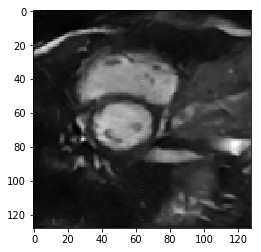

saving epoch {72}
Epoch: 73, Iteration: 1, Loss: 0.0005557569675147533, time: 2019-08-04 21:26:32.246830
Epoch: 73, Iteration: 101, Loss: 0.050115477497456595, time: 2019-08-04 21:28:28.982904
Epoch: 73, Iteration: 201, Loss: 0.09744954798952676, time: 2019-08-04 21:30:25.424926
Epoch: 73, Iteration: 301, Loss: 0.1490756415296346, time: 2019-08-04 21:32:21.949212
Epoch: 73, Iteration: 401, Loss: 0.2019011908705579, time: 2019-08-04 21:34:18.371163
Epoch: 73, Iteration: 501, Loss: 0.25495991938805673, time: 2019-08-04 21:36:15.015027
Epoch: 73, Iteration: 601, Loss: 0.30550493724877015, time: 2019-08-04 21:38:11.750613
Epoch: 73, Iteration: 701, Loss: 0.3542762216675328, time: 2019-08-04 21:40:08.179324
Epoch: 73, Iteration: 801, Loss: 0.4049110586493043, time: 2019-08-04 21:42:04.833357
Epoch: 73, Iteration: 901, Loss: 0.4605339220725, time: 2019-08-04 21:44:01.346854
Epoch: 73, Iteration: 1001, Loss: 0.5136500357621117, time: 2019-08-04 21:45:57.790301
Epoch: 73, Iteration: 1101, Loss

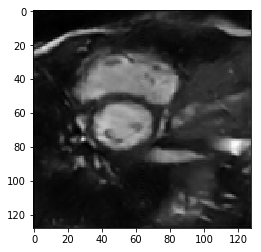

saving epoch {73}
Epoch: 74, Iteration: 1, Loss: 0.00037169965798966587, time: 2019-08-04 21:49:51.566811
Epoch: 74, Iteration: 101, Loss: 0.052197451499523595, time: 2019-08-04 21:51:48.104053
Epoch: 74, Iteration: 201, Loss: 0.10787664930103347, time: 2019-08-04 21:53:44.593159
Epoch: 74, Iteration: 301, Loss: 0.15701209026155993, time: 2019-08-04 21:55:41.054530
Epoch: 74, Iteration: 401, Loss: 0.20340707963623572, time: 2019-08-04 21:57:37.556370
Epoch: 74, Iteration: 501, Loss: 0.25662917175213806, time: 2019-08-04 21:59:33.993449
Epoch: 74, Iteration: 601, Loss: 0.3074671294307336, time: 2019-08-04 22:01:30.568668
Epoch: 74, Iteration: 701, Loss: 0.35859913247986697, time: 2019-08-04 22:03:27.133941
Epoch: 74, Iteration: 801, Loss: 0.40751571432338096, time: 2019-08-04 22:05:23.563486
Epoch: 74, Iteration: 901, Loss: 0.4570177891582716, time: 2019-08-04 22:07:20.044575
Epoch: 74, Iteration: 1001, Loss: 0.5045446452568285, time: 2019-08-04 22:09:16.540265
Epoch: 74, Iteration: 110

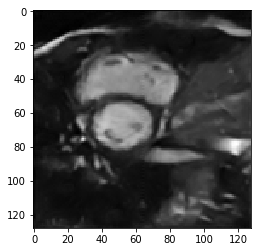

saving epoch {74}
Epoch: 75, Iteration: 1, Loss: 0.000432714878115803, time: 2019-08-04 22:13:10.269318
Epoch: 75, Iteration: 101, Loss: 0.047632269182940945, time: 2019-08-04 22:15:06.719584
Epoch: 75, Iteration: 201, Loss: 0.09822564828209579, time: 2019-08-04 22:17:03.189113
Epoch: 75, Iteration: 301, Loss: 0.14783859782619402, time: 2019-08-04 22:18:59.717293
Epoch: 75, Iteration: 401, Loss: 0.19608798492117785, time: 2019-08-04 22:20:56.283524
Epoch: 75, Iteration: 501, Loss: 0.24497115830308758, time: 2019-08-04 22:22:53.045421
Epoch: 75, Iteration: 601, Loss: 0.3000439524475951, time: 2019-08-04 22:24:49.743760
Epoch: 75, Iteration: 701, Loss: 0.3499728045571828, time: 2019-08-04 22:26:46.292006
Epoch: 75, Iteration: 801, Loss: 0.4015403488301672, time: 2019-08-04 22:28:42.743443
Epoch: 75, Iteration: 901, Loss: 0.4549720306531526, time: 2019-08-04 22:30:39.302872
Epoch: 75, Iteration: 1001, Loss: 0.5214775988133624, time: 2019-08-04 22:32:35.825197
Epoch: 75, Iteration: 1101, L

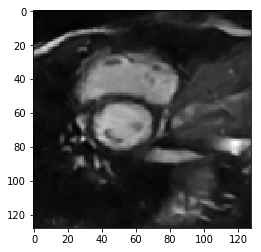

saving epoch {75}
Epoch: 76, Iteration: 1, Loss: 0.00048352451995015144, time: 2019-08-04 22:36:29.803237
Epoch: 76, Iteration: 101, Loss: 0.04881672310875729, time: 2019-08-04 22:38:26.396234
Epoch: 76, Iteration: 201, Loss: 0.0988285399362212, time: 2019-08-04 22:40:22.839619
Epoch: 76, Iteration: 301, Loss: 0.15138384084275458, time: 2019-08-04 22:42:19.338008
Epoch: 76, Iteration: 401, Loss: 0.20159806324227247, time: 2019-08-04 22:44:15.877427
Epoch: 76, Iteration: 501, Loss: 0.24779168923851103, time: 2019-08-04 22:46:12.338765
Epoch: 76, Iteration: 601, Loss: 0.29283454302640166, time: 2019-08-04 22:48:08.820515
Epoch: 76, Iteration: 701, Loss: 0.34496270143426955, time: 2019-08-04 22:50:05.323658
Epoch: 76, Iteration: 801, Loss: 0.39787508005974814, time: 2019-08-04 22:52:02.034257
Epoch: 76, Iteration: 901, Loss: 0.45038639326230623, time: 2019-08-04 22:53:58.574937
Epoch: 76, Iteration: 1001, Loss: 0.49979069326946046, time: 2019-08-04 22:55:55.128831
Epoch: 76, Iteration: 11

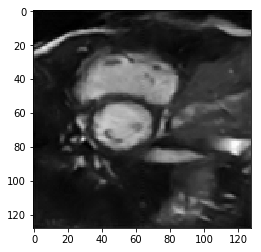

saving epoch {76}
Epoch: 77, Iteration: 1, Loss: 0.0006390528287738562, time: 2019-08-04 22:59:49.035619
Epoch: 77, Iteration: 101, Loss: 0.05495170995709486, time: 2019-08-04 23:01:45.547345
Epoch: 77, Iteration: 201, Loss: 0.10737209979561158, time: 2019-08-04 23:03:42.155435
Epoch: 77, Iteration: 301, Loss: 0.1507618879986694, time: 2019-08-04 23:05:38.688364
Epoch: 77, Iteration: 401, Loss: 0.2021940908744, time: 2019-08-04 23:07:35.220414
Epoch: 77, Iteration: 501, Loss: 0.2541799557802733, time: 2019-08-04 23:09:31.626060
Epoch: 77, Iteration: 601, Loss: 0.3061323765577981, time: 2019-08-04 23:11:28.279456
Epoch: 77, Iteration: 701, Loss: 0.3560569223918719, time: 2019-08-04 23:13:24.882754
Epoch: 77, Iteration: 801, Loss: 0.4064432479644893, time: 2019-08-04 23:15:21.619120
Epoch: 77, Iteration: 901, Loss: 0.4532244570727926, time: 2019-08-04 23:17:17.956965
Epoch: 77, Iteration: 1001, Loss: 0.5081735770654632, time: 2019-08-04 23:19:14.422731
Epoch: 77, Iteration: 1101, Loss: 0

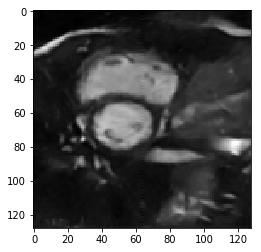

saving epoch {77}
Epoch: 78, Iteration: 1, Loss: 0.0006484576733782887, time: 2019-08-04 23:23:08.315324
Epoch: 78, Iteration: 101, Loss: 0.056921970419352874, time: 2019-08-04 23:25:04.777528
Epoch: 78, Iteration: 201, Loss: 0.10942347624222748, time: 2019-08-04 23:27:01.241894
Epoch: 78, Iteration: 301, Loss: 0.1601808023697231, time: 2019-08-04 23:28:57.614113
Epoch: 78, Iteration: 401, Loss: 0.21099739780765958, time: 2019-08-04 23:30:54.035830
Epoch: 78, Iteration: 501, Loss: 0.2561957611324033, time: 2019-08-04 23:32:50.483109
Epoch: 78, Iteration: 601, Loss: 0.3022343482589349, time: 2019-08-04 23:34:46.931156
Epoch: 78, Iteration: 701, Loss: 0.34983172798820306, time: 2019-08-04 23:36:43.558458
Epoch: 78, Iteration: 801, Loss: 0.3991425387648633, time: 2019-08-04 23:38:39.989272
Epoch: 78, Iteration: 901, Loss: 0.44873357549658976, time: 2019-08-04 23:40:36.452027
Epoch: 78, Iteration: 1001, Loss: 0.49558081790746655, time: 2019-08-04 23:42:32.840604
Epoch: 78, Iteration: 1101,

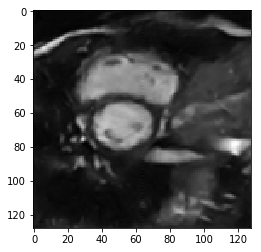

saving epoch {78}
Epoch: 79, Iteration: 1, Loss: 0.0005299808108247817, time: 2019-08-04 23:46:26.718987
Epoch: 79, Iteration: 101, Loss: 0.04627588564471807, time: 2019-08-04 23:48:23.376604
Epoch: 79, Iteration: 201, Loss: 0.1012148881709436, time: 2019-08-04 23:50:19.924802
Epoch: 79, Iteration: 301, Loss: 0.15789179517014418, time: 2019-08-04 23:52:16.457681
Epoch: 79, Iteration: 401, Loss: 0.20833277802739758, time: 2019-08-04 23:54:13.014607
Epoch: 79, Iteration: 501, Loss: 0.2586328413162846, time: 2019-08-04 23:56:09.616150
Epoch: 79, Iteration: 601, Loss: 0.30700149726180825, time: 2019-08-04 23:58:06.200695
Epoch: 79, Iteration: 701, Loss: 0.35272411454934627, time: 2019-08-05 00:00:02.654466
Epoch: 79, Iteration: 801, Loss: 0.3979426252335543, time: 2019-08-05 00:01:59.146344
Epoch: 79, Iteration: 901, Loss: 0.4478706933296053, time: 2019-08-05 00:03:55.720858
Epoch: 79, Iteration: 1001, Loss: 0.5014173796807881, time: 2019-08-05 00:05:52.251178
Epoch: 79, Iteration: 1101, L

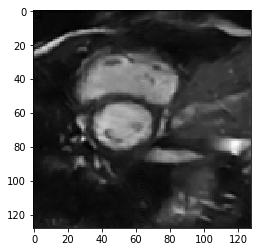

saving epoch {79}
Epoch: 80, Iteration: 1, Loss: 0.0006143589853309095, time: 2019-08-05 00:09:46.111120
Epoch: 80, Iteration: 101, Loss: 0.05327439610846341, time: 2019-08-05 00:11:42.630386
Epoch: 80, Iteration: 201, Loss: 0.10427792844711803, time: 2019-08-05 00:13:39.206047
Epoch: 80, Iteration: 301, Loss: 0.1624847807252081, time: 2019-08-05 00:15:35.707891
Epoch: 80, Iteration: 401, Loss: 0.2100610897759907, time: 2019-08-05 00:17:32.300924
Epoch: 80, Iteration: 501, Loss: 0.2636237011611229, time: 2019-08-05 00:19:28.749869
Epoch: 80, Iteration: 601, Loss: 0.31146026370697655, time: 2019-08-05 00:21:25.729751
Epoch: 80, Iteration: 701, Loss: 0.35913252623868175, time: 2019-08-05 00:23:22.490850
Epoch: 80, Iteration: 801, Loss: 0.405662729011965, time: 2019-08-05 00:25:19.215681
Epoch: 80, Iteration: 901, Loss: 0.4557313379482366, time: 2019-08-05 00:27:15.844348
Epoch: 80, Iteration: 1001, Loss: 0.504426577113918, time: 2019-08-05 00:29:12.373560
Epoch: 80, Iteration: 1101, Loss

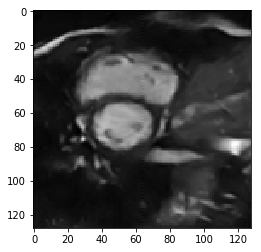

saving epoch {80}
Epoch: 81, Iteration: 1, Loss: 0.0005088284378871322, time: 2019-08-05 00:33:06.445955
Epoch: 81, Iteration: 101, Loss: 0.04826336861879099, time: 2019-08-05 00:35:03.008971
Epoch: 81, Iteration: 201, Loss: 0.0917865865631029, time: 2019-08-05 00:36:59.444333
Epoch: 81, Iteration: 301, Loss: 0.1434977056342177, time: 2019-08-05 00:38:56.056111
Epoch: 81, Iteration: 401, Loss: 0.19138103775912896, time: 2019-08-05 00:40:52.679564
Epoch: 81, Iteration: 501, Loss: 0.24031001115508843, time: 2019-08-05 00:42:49.170638
Epoch: 81, Iteration: 601, Loss: 0.28841385823034216, time: 2019-08-05 00:44:45.697182
Epoch: 81, Iteration: 701, Loss: 0.33370955228747334, time: 2019-08-05 00:46:42.164602
Epoch: 81, Iteration: 801, Loss: 0.3834109846793581, time: 2019-08-05 00:48:38.747036
Epoch: 81, Iteration: 901, Loss: 0.4386120614653919, time: 2019-08-05 00:50:35.356764
Epoch: 81, Iteration: 1001, Loss: 0.4905837490223348, time: 2019-08-05 00:52:31.813581
Epoch: 81, Iteration: 1101, L

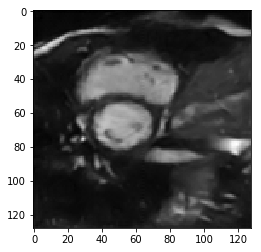

saving epoch {81}
Epoch: 82, Iteration: 1, Loss: 0.00035292195389047265, time: 2019-08-05 00:56:25.577396
Epoch: 82, Iteration: 101, Loss: 0.04997901676688343, time: 2019-08-05 00:58:21.980366
Epoch: 82, Iteration: 201, Loss: 0.10039053960645106, time: 2019-08-05 01:00:18.503641
Epoch: 82, Iteration: 301, Loss: 0.14767350026522763, time: 2019-08-05 01:02:14.948612
Epoch: 82, Iteration: 401, Loss: 0.1994268529524561, time: 2019-08-05 01:04:11.523056
Epoch: 82, Iteration: 501, Loss: 0.2520679328008555, time: 2019-08-05 01:06:07.960351
Epoch: 82, Iteration: 601, Loss: 0.2981264913250925, time: 2019-08-05 01:08:04.535927
Epoch: 82, Iteration: 701, Loss: 0.348981740520685, time: 2019-08-05 01:10:01.185200
Epoch: 82, Iteration: 801, Loss: 0.4011283350555459, time: 2019-08-05 01:11:57.637915
Epoch: 82, Iteration: 901, Loss: 0.447662743870751, time: 2019-08-05 01:13:54.143759
Epoch: 82, Iteration: 1001, Loss: 0.4937648977065692, time: 2019-08-05 01:15:50.827747
Epoch: 82, Iteration: 1101, Loss

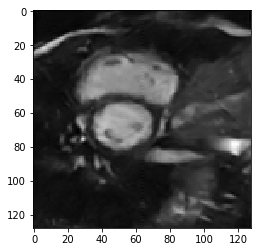

saving epoch {82}
Epoch: 83, Iteration: 1, Loss: 0.0004713412490673363, time: 2019-08-05 01:19:44.891089
Epoch: 83, Iteration: 101, Loss: 0.04641896492103115, time: 2019-08-05 01:21:41.471725
Epoch: 83, Iteration: 201, Loss: 0.09941547221387736, time: 2019-08-05 01:23:38.054582
Epoch: 83, Iteration: 301, Loss: 0.14900421448692214, time: 2019-08-05 01:25:34.623706
Epoch: 83, Iteration: 401, Loss: 0.19933137179759797, time: 2019-08-05 01:27:31.213620
Epoch: 83, Iteration: 501, Loss: 0.2596663900767453, time: 2019-08-05 01:29:27.787268
Epoch: 83, Iteration: 601, Loss: 0.3135320518631488, time: 2019-08-05 01:31:24.384862
Epoch: 83, Iteration: 701, Loss: 0.3664546909276396, time: 2019-08-05 01:33:21.061320
Epoch: 83, Iteration: 801, Loss: 0.41396826862182934, time: 2019-08-05 01:35:17.634518
Epoch: 83, Iteration: 901, Loss: 0.4629442509030923, time: 2019-08-05 01:37:14.344821
Epoch: 83, Iteration: 1001, Loss: 0.5105234121874673, time: 2019-08-05 01:39:10.903585
Epoch: 83, Iteration: 1101, L

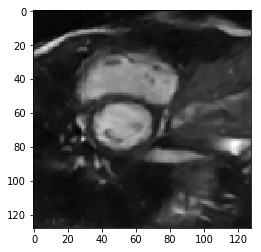

saving epoch {83}
Epoch: 84, Iteration: 1, Loss: 0.0005248031811788678, time: 2019-08-05 01:43:05.094326
Epoch: 84, Iteration: 101, Loss: 0.04733487271005288, time: 2019-08-05 01:45:01.668118
Epoch: 84, Iteration: 201, Loss: 0.09274216365884058, time: 2019-08-05 01:46:58.323005
Epoch: 84, Iteration: 301, Loss: 0.14067575825902168, time: 2019-08-05 01:48:54.910783
Epoch: 84, Iteration: 401, Loss: 0.18906386558956, time: 2019-08-05 01:50:51.500063
Epoch: 84, Iteration: 501, Loss: 0.2410140010615578, time: 2019-08-05 01:52:48.053825
Epoch: 84, Iteration: 601, Loss: 0.29212534354883246, time: 2019-08-05 01:54:44.655001
Epoch: 84, Iteration: 701, Loss: 0.33870875321736094, time: 2019-08-05 01:56:41.269604
Epoch: 84, Iteration: 801, Loss: 0.38800158092635684, time: 2019-08-05 01:58:37.869790
Epoch: 84, Iteration: 901, Loss: 0.43436625285539776, time: 2019-08-05 02:00:34.541303
Epoch: 84, Iteration: 1001, Loss: 0.4887126161920605, time: 2019-08-05 02:02:31.119675
Epoch: 84, Iteration: 1101, L

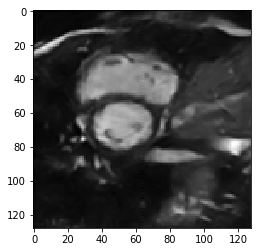

saving epoch {84}
Epoch: 85, Iteration: 1, Loss: 0.0006724427221342921, time: 2019-08-05 02:06:25.299692
Epoch: 85, Iteration: 101, Loss: 0.04871482744056266, time: 2019-08-05 02:08:21.776783
Epoch: 85, Iteration: 201, Loss: 0.10047898638003971, time: 2019-08-05 02:10:18.190769
Epoch: 85, Iteration: 301, Loss: 0.1541117903398117, time: 2019-08-05 02:12:14.734184
Epoch: 85, Iteration: 401, Loss: 0.2002499266527593, time: 2019-08-05 02:14:11.118444
Epoch: 85, Iteration: 501, Loss: 0.24703419585421216, time: 2019-08-05 02:16:07.530634
Epoch: 85, Iteration: 601, Loss: 0.291799322978477, time: 2019-08-05 02:18:04.090849
Epoch: 85, Iteration: 701, Loss: 0.33986874876427464, time: 2019-08-05 02:20:00.552292
Epoch: 85, Iteration: 801, Loss: 0.38574037836224306, time: 2019-08-05 02:21:57.596430
Epoch: 85, Iteration: 901, Loss: 0.43338826300168876, time: 2019-08-05 02:23:54.301338
Epoch: 85, Iteration: 1001, Loss: 0.48152565296913963, time: 2019-08-05 02:25:50.861354
Epoch: 85, Iteration: 1101, 

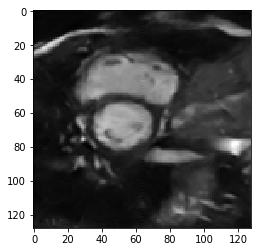

saving epoch {85}
Epoch: 86, Iteration: 1, Loss: 0.0003540680627338588, time: 2019-08-05 02:29:44.444805
Epoch: 86, Iteration: 101, Loss: 0.04589847821625881, time: 2019-08-05 02:31:40.926017
Epoch: 86, Iteration: 201, Loss: 0.0970054479985265, time: 2019-08-05 02:33:37.546902
Epoch: 86, Iteration: 301, Loss: 0.1557447667582892, time: 2019-08-05 02:35:33.916134
Epoch: 86, Iteration: 401, Loss: 0.20734744536457583, time: 2019-08-05 02:37:30.488998
Epoch: 86, Iteration: 501, Loss: 0.2515772694896441, time: 2019-08-05 02:39:26.986442
Epoch: 86, Iteration: 601, Loss: 0.3005210515402723, time: 2019-08-05 02:41:23.411774
Epoch: 86, Iteration: 701, Loss: 0.34905036191048566, time: 2019-08-05 02:43:20.031358
Epoch: 86, Iteration: 801, Loss: 0.3961849799961783, time: 2019-08-05 02:45:16.601157
Epoch: 86, Iteration: 901, Loss: 0.44691522610082757, time: 2019-08-05 02:47:13.118076
Epoch: 86, Iteration: 1001, Loss: 0.49948260412202217, time: 2019-08-05 02:49:09.641175
Epoch: 86, Iteration: 1101, L

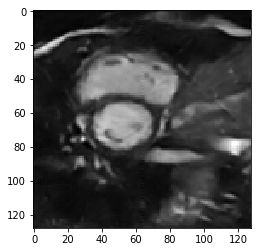

saving epoch {86}
Epoch: 87, Iteration: 1, Loss: 0.00045737880282104015, time: 2019-08-05 02:53:03.447246
Epoch: 87, Iteration: 101, Loss: 0.04664018350013066, time: 2019-08-05 02:54:59.931743
Epoch: 87, Iteration: 201, Loss: 0.09508097605430521, time: 2019-08-05 02:56:56.275878
Epoch: 87, Iteration: 301, Loss: 0.14062185381771997, time: 2019-08-05 02:58:52.814976
Epoch: 87, Iteration: 401, Loss: 0.18831423182564322, time: 2019-08-05 03:00:49.232617
Epoch: 87, Iteration: 501, Loss: 0.23286683768674266, time: 2019-08-05 03:02:45.585155
Epoch: 87, Iteration: 601, Loss: 0.2783252071676543, time: 2019-08-05 03:04:42.060284
Epoch: 87, Iteration: 701, Loss: 0.3261268791393377, time: 2019-08-05 03:06:38.466432
Epoch: 87, Iteration: 801, Loss: 0.3764586979523301, time: 2019-08-05 03:08:35.032718
Epoch: 87, Iteration: 901, Loss: 0.4266816300805658, time: 2019-08-05 03:10:31.396802
Epoch: 87, Iteration: 1001, Loss: 0.4749850988446269, time: 2019-08-05 03:12:27.856442
Epoch: 87, Iteration: 1101, 

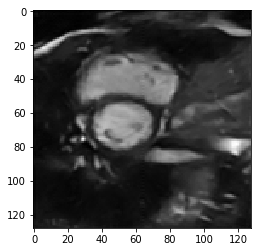

saving epoch {87}
Epoch: 88, Iteration: 1, Loss: 0.0009801107225939631, time: 2019-08-05 03:16:21.482496
Epoch: 88, Iteration: 101, Loss: 0.0501048377918778, time: 2019-08-05 03:18:17.861567
Epoch: 88, Iteration: 201, Loss: 0.0953012377867708, time: 2019-08-05 03:20:14.402351
Epoch: 88, Iteration: 301, Loss: 0.1468355056422297, time: 2019-08-05 03:22:10.787377
Epoch: 88, Iteration: 401, Loss: 0.18878795139607973, time: 2019-08-05 03:24:07.244101
Epoch: 88, Iteration: 501, Loss: 0.22984076626016758, time: 2019-08-05 03:26:03.610665
Epoch: 88, Iteration: 601, Loss: 0.28606480234884657, time: 2019-08-05 03:28:00.064811
Epoch: 88, Iteration: 701, Loss: 0.3382344346755417, time: 2019-08-05 03:29:56.527056
Epoch: 88, Iteration: 801, Loss: 0.3862801755021792, time: 2019-08-05 03:31:52.836365
Epoch: 88, Iteration: 901, Loss: 0.43295687236241065, time: 2019-08-05 03:33:49.248706
Epoch: 88, Iteration: 1001, Loss: 0.4815610483929049, time: 2019-08-05 03:35:45.583042
Epoch: 88, Iteration: 1101, Lo

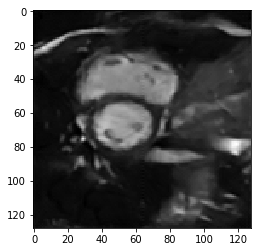

saving epoch {88}
Epoch: 89, Iteration: 1, Loss: 0.00037104616058059037, time: 2019-08-05 03:39:39.685858
Epoch: 89, Iteration: 101, Loss: 0.04812154540559277, time: 2019-08-05 03:41:36.135892
Epoch: 89, Iteration: 201, Loss: 0.09256417649157811, time: 2019-08-05 03:43:32.670040
Epoch: 89, Iteration: 301, Loss: 0.14201510603015777, time: 2019-08-05 03:45:29.102133
Epoch: 89, Iteration: 401, Loss: 0.19374687506933697, time: 2019-08-05 03:47:25.508993
Epoch: 89, Iteration: 501, Loss: 0.2502761806390481, time: 2019-08-05 03:49:22.066709
Epoch: 89, Iteration: 601, Loss: 0.29886429231555667, time: 2019-08-05 03:51:18.556966
Epoch: 89, Iteration: 701, Loss: 0.3470287723321235, time: 2019-08-05 03:53:14.987612
Epoch: 89, Iteration: 801, Loss: 0.3921454257942969, time: 2019-08-05 03:55:11.436215
Epoch: 89, Iteration: 901, Loss: 0.44109655244392343, time: 2019-08-05 03:57:07.811674
Epoch: 89, Iteration: 1001, Loss: 0.4889585401979275, time: 2019-08-05 03:59:04.354621
Epoch: 89, Iteration: 1101,

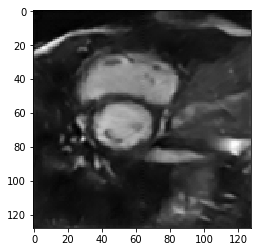

saving epoch {89}
Epoch: 90, Iteration: 1, Loss: 0.0003811421920545399, time: 2019-08-05 04:02:58.136921
Epoch: 90, Iteration: 101, Loss: 0.04800139492726885, time: 2019-08-05 04:04:54.783616
Epoch: 90, Iteration: 201, Loss: 0.09334362097433768, time: 2019-08-05 04:06:51.287834
Epoch: 90, Iteration: 301, Loss: 0.14487172639928758, time: 2019-08-05 04:08:47.835837
Epoch: 90, Iteration: 401, Loss: 0.19038644114334602, time: 2019-08-05 04:10:44.320369
Epoch: 90, Iteration: 501, Loss: 0.23273004195652902, time: 2019-08-05 04:12:40.731833
Epoch: 90, Iteration: 601, Loss: 0.28310643156873994, time: 2019-08-05 04:14:37.340148
Epoch: 90, Iteration: 701, Loss: 0.3336667268886231, time: 2019-08-05 04:16:33.764051
Epoch: 90, Iteration: 801, Loss: 0.3824062361527467, time: 2019-08-05 04:18:30.199354
Epoch: 90, Iteration: 901, Loss: 0.43304546461149585, time: 2019-08-05 04:20:26.538680
Epoch: 90, Iteration: 1001, Loss: 0.48213794722687453, time: 2019-08-05 04:22:23.341615
Epoch: 90, Iteration: 1101

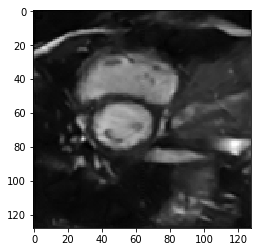

saving epoch {90}
Epoch: 91, Iteration: 1, Loss: 0.0005081301205791533, time: 2019-08-05 04:26:17.345784
Epoch: 91, Iteration: 101, Loss: 0.04739064387104008, time: 2019-08-05 04:28:13.789887
Epoch: 91, Iteration: 201, Loss: 0.09459553775377572, time: 2019-08-05 04:30:10.309419
Epoch: 91, Iteration: 301, Loss: 0.14272947459539864, time: 2019-08-05 04:32:06.849370
Epoch: 91, Iteration: 401, Loss: 0.1881760641845176, time: 2019-08-05 04:34:03.281107
Epoch: 91, Iteration: 501, Loss: 0.2340611483086832, time: 2019-08-05 04:35:59.632068
Epoch: 91, Iteration: 601, Loss: 0.27608576719649136, time: 2019-08-05 04:37:56.067204
Epoch: 91, Iteration: 701, Loss: 0.32097337442974094, time: 2019-08-05 04:39:52.498059
Epoch: 91, Iteration: 801, Loss: 0.36497080817935057, time: 2019-08-05 04:41:49.137888
Epoch: 91, Iteration: 901, Loss: 0.41039481764892116, time: 2019-08-05 04:43:45.579601
Epoch: 91, Iteration: 1001, Loss: 0.46184803458163515, time: 2019-08-05 04:45:42.092656
Epoch: 91, Iteration: 1101

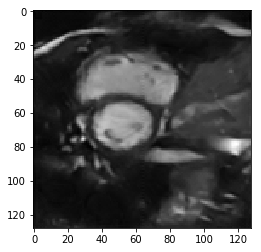

saving epoch {91}
Epoch: 92, Iteration: 1, Loss: 0.00026674222317524254, time: 2019-08-05 04:49:35.830453
Epoch: 92, Iteration: 101, Loss: 0.04791143085458316, time: 2019-08-05 04:51:32.333455
Epoch: 92, Iteration: 201, Loss: 0.09231430705403909, time: 2019-08-05 04:53:29.012312
Epoch: 92, Iteration: 301, Loss: 0.13394639553735033, time: 2019-08-05 04:55:25.550091
Epoch: 92, Iteration: 401, Loss: 0.177194803058228, time: 2019-08-05 04:57:22.062077
Epoch: 92, Iteration: 501, Loss: 0.22649332664877875, time: 2019-08-05 04:59:18.632089
Epoch: 92, Iteration: 601, Loss: 0.2706500159620191, time: 2019-08-05 05:01:15.107864
Epoch: 92, Iteration: 701, Loss: 0.31551494208542863, time: 2019-08-05 05:03:11.771910
Epoch: 92, Iteration: 801, Loss: 0.3586236696501146, time: 2019-08-05 05:05:08.388054
Epoch: 92, Iteration: 901, Loss: 0.4059059267528937, time: 2019-08-05 05:07:04.951615
Epoch: 92, Iteration: 1001, Loss: 0.4612203793731169, time: 2019-08-05 05:09:01.484856
Epoch: 92, Iteration: 1101, L

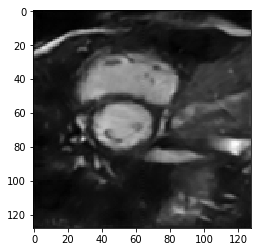

saving epoch {92}
Epoch: 93, Iteration: 1, Loss: 0.000905002758372575, time: 2019-08-05 05:12:55.436074
Epoch: 93, Iteration: 101, Loss: 0.048867187317227945, time: 2019-08-05 05:14:52.142738
Epoch: 93, Iteration: 201, Loss: 0.09426840998639818, time: 2019-08-05 05:16:48.681748
Epoch: 93, Iteration: 301, Loss: 0.13791340835450683, time: 2019-08-05 05:18:45.137724
Epoch: 93, Iteration: 401, Loss: 0.1835858548147371, time: 2019-08-05 05:20:41.687497
Epoch: 93, Iteration: 501, Loss: 0.2280783089081524, time: 2019-08-05 05:22:38.231706
Epoch: 93, Iteration: 601, Loss: 0.27328728610882536, time: 2019-08-05 05:24:35.386755
Epoch: 93, Iteration: 701, Loss: 0.3202634861081606, time: 2019-08-05 05:26:33.859513
Epoch: 93, Iteration: 801, Loss: 0.36307080171536654, time: 2019-08-05 05:28:32.659721
Epoch: 93, Iteration: 901, Loss: 0.4073283831967274, time: 2019-08-05 05:30:31.407333
Epoch: 93, Iteration: 1001, Loss: 0.4545345923252171, time: 2019-08-05 05:32:29.722329
Epoch: 93, Iteration: 1101, L

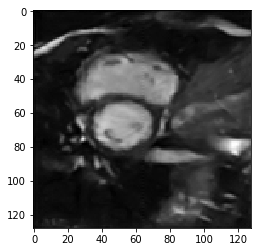

saving epoch {93}
Epoch: 94, Iteration: 1, Loss: 0.0005076368688605726, time: 2019-08-05 05:36:27.816231
Epoch: 94, Iteration: 101, Loss: 0.04825965540658217, time: 2019-08-05 05:38:26.378823
Epoch: 94, Iteration: 201, Loss: 0.09438303732895292, time: 2019-08-05 05:40:24.176139
Epoch: 94, Iteration: 301, Loss: 0.15273716421506833, time: 2019-08-05 05:42:21.985558
Epoch: 94, Iteration: 401, Loss: 0.20666729703953024, time: 2019-08-05 05:44:20.695769
Epoch: 94, Iteration: 501, Loss: 0.25417198984359857, time: 2019-08-05 05:46:19.880620
Epoch: 94, Iteration: 601, Loss: 0.3005924644530751, time: 2019-08-05 05:48:18.546064
Epoch: 94, Iteration: 701, Loss: 0.34954262858082075, time: 2019-08-05 05:50:17.406904
Epoch: 94, Iteration: 801, Loss: 0.39765703241573647, time: 2019-08-05 05:52:16.096400
Epoch: 94, Iteration: 901, Loss: 0.4450408656412037, time: 2019-08-05 05:54:14.822436
Epoch: 94, Iteration: 1001, Loss: 0.4866636359656695, time: 2019-08-05 05:56:13.476594
Epoch: 94, Iteration: 1101,

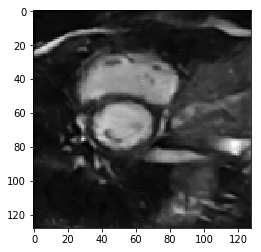

saving epoch {94}
Epoch: 95, Iteration: 1, Loss: 0.0004119090735912323, time: 2019-08-05 06:00:11.119381
Epoch: 95, Iteration: 101, Loss: 0.04376358652370982, time: 2019-08-05 06:02:09.570534
Epoch: 95, Iteration: 201, Loss: 0.08959118863276672, time: 2019-08-05 06:04:07.864380
Epoch: 95, Iteration: 301, Loss: 0.13120208912005182, time: 2019-08-05 06:06:06.499184
Epoch: 95, Iteration: 401, Loss: 0.1807098582648905, time: 2019-08-05 06:08:05.027560
Epoch: 95, Iteration: 501, Loss: 0.2233054849493783, time: 2019-08-05 06:10:03.645938
Epoch: 95, Iteration: 601, Loss: 0.2731967408908531, time: 2019-08-05 06:12:02.282319
Epoch: 95, Iteration: 701, Loss: 0.32253538217628375, time: 2019-08-05 06:14:00.894986
Epoch: 95, Iteration: 801, Loss: 0.36941231218224857, time: 2019-08-05 06:15:59.328226
Epoch: 95, Iteration: 901, Loss: 0.41669240697228815, time: 2019-08-05 06:17:57.757846
Epoch: 95, Iteration: 1001, Loss: 0.4686820129863918, time: 2019-08-05 06:19:56.239700
Epoch: 95, Iteration: 1101, 

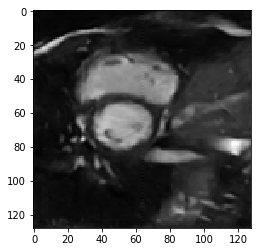

saving epoch {95}
Epoch: 96, Iteration: 1, Loss: 0.00050489412387833, time: 2019-08-05 06:23:53.662882
Epoch: 96, Iteration: 101, Loss: 0.04868573816202115, time: 2019-08-05 06:25:52.096619
Epoch: 96, Iteration: 201, Loss: 0.0938774018723052, time: 2019-08-05 06:27:50.229249
Epoch: 96, Iteration: 301, Loss: 0.14297560024715494, time: 2019-08-05 06:29:48.276729
Epoch: 96, Iteration: 401, Loss: 0.18688589679368306, time: 2019-08-05 06:31:46.208204
Epoch: 96, Iteration: 501, Loss: 0.2314682864380302, time: 2019-08-05 06:33:44.167257
Epoch: 96, Iteration: 601, Loss: 0.2762923846312333, time: 2019-08-05 06:35:42.270578
Epoch: 96, Iteration: 701, Loss: 0.32479956811585, time: 2019-08-05 06:37:40.222499
Epoch: 96, Iteration: 801, Loss: 0.372688984949491, time: 2019-08-05 06:39:38.038629
Epoch: 96, Iteration: 901, Loss: 0.4235364532651147, time: 2019-08-05 06:41:36.009355
Epoch: 96, Iteration: 1001, Loss: 0.4677753969008336, time: 2019-08-05 06:43:33.953633
Epoch: 96, Iteration: 1101, Loss: 0.

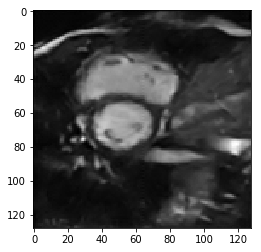

saving epoch {96}
Epoch: 97, Iteration: 1, Loss: 0.0008768813568167388, time: 2019-08-05 06:47:31.100727
Epoch: 97, Iteration: 101, Loss: 0.04384723072871566, time: 2019-08-05 06:49:29.090541
Epoch: 97, Iteration: 201, Loss: 0.08564657461829484, time: 2019-08-05 06:51:27.576601
Epoch: 97, Iteration: 301, Loss: 0.12971755836042576, time: 2019-08-05 06:53:25.947716
Epoch: 97, Iteration: 401, Loss: 0.17507365229539573, time: 2019-08-05 06:55:24.084299
Epoch: 97, Iteration: 501, Loss: 0.21751329523976892, time: 2019-08-05 06:57:22.720640
Epoch: 97, Iteration: 601, Loss: 0.262513119916548, time: 2019-08-05 06:59:21.299016
Epoch: 97, Iteration: 701, Loss: 0.30997523505357094, time: 2019-08-05 07:01:19.784634
Epoch: 97, Iteration: 801, Loss: 0.3553319322381867, time: 2019-08-05 07:03:18.346691
Epoch: 97, Iteration: 901, Loss: 0.40322672834736295, time: 2019-08-05 07:05:16.624979
Epoch: 97, Iteration: 1001, Loss: 0.45045371798914857, time: 2019-08-05 07:07:15.257652
Epoch: 97, Iteration: 1101,

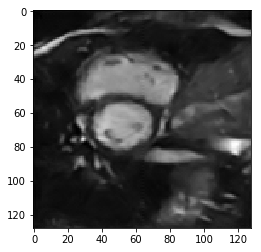

saving epoch {97}
Epoch: 98, Iteration: 1, Loss: 0.000469475140562281, time: 2019-08-05 07:11:13.634313
Epoch: 98, Iteration: 101, Loss: 0.04708980726718437, time: 2019-08-05 07:13:12.378047
Epoch: 98, Iteration: 201, Loss: 0.09260889954748563, time: 2019-08-05 07:15:11.027391
Epoch: 98, Iteration: 301, Loss: 0.1365755776350852, time: 2019-08-05 07:17:09.648848
Epoch: 98, Iteration: 401, Loss: 0.1834176486299839, time: 2019-08-05 07:19:07.547462
Epoch: 98, Iteration: 501, Loss: 0.23099873911996838, time: 2019-08-05 07:21:05.048904
Epoch: 98, Iteration: 601, Loss: 0.27881546289427206, time: 2019-08-05 07:23:03.478306
Epoch: 98, Iteration: 701, Loss: 0.32493095500103664, time: 2019-08-05 07:25:01.708800
Epoch: 98, Iteration: 801, Loss: 0.3672593655210221, time: 2019-08-05 07:26:59.721794
Epoch: 98, Iteration: 901, Loss: 0.41422103709192015, time: 2019-08-05 07:28:57.963612
Epoch: 98, Iteration: 1001, Loss: 0.4566550004237797, time: 2019-08-05 07:30:55.882373
Epoch: 98, Iteration: 1101, L

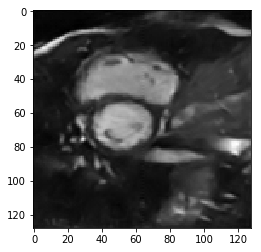

saving epoch {98}
Epoch: 99, Iteration: 1, Loss: 0.0005208404618315399, time: 2019-08-05 07:34:53.238333
Epoch: 99, Iteration: 101, Loss: 0.05369308766967151, time: 2019-08-05 07:36:51.279577
Epoch: 99, Iteration: 201, Loss: 0.10244791237346362, time: 2019-08-05 07:38:49.597831
Epoch: 99, Iteration: 301, Loss: 0.14776171286939643, time: 2019-08-05 07:40:47.726084
Epoch: 99, Iteration: 401, Loss: 0.1891010536637623, time: 2019-08-05 07:42:46.041058
Epoch: 99, Iteration: 501, Loss: 0.23164166075002868, time: 2019-08-05 07:44:43.769210
Epoch: 99, Iteration: 601, Loss: 0.2745606991375098, time: 2019-08-05 07:46:41.896957
Epoch: 99, Iteration: 701, Loss: 0.3210033956274856, time: 2019-08-05 07:48:40.117754
Epoch: 99, Iteration: 801, Loss: 0.3696343162737321, time: 2019-08-05 07:50:38.480865
Epoch: 99, Iteration: 901, Loss: 0.42015870021714363, time: 2019-08-05 07:52:36.488212
Epoch: 99, Iteration: 1001, Loss: 0.46956877561751753, time: 2019-08-05 07:54:34.301391
Epoch: 99, Iteration: 1101, 

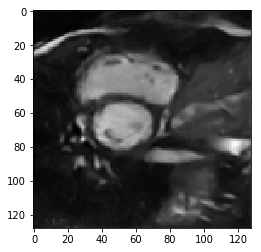

saving epoch {99}
Epoch: 100, Iteration: 1, Loss: 0.0005004277336411178, time: 2019-08-05 07:58:31.487151
Epoch: 100, Iteration: 101, Loss: 0.04588705691276118, time: 2019-08-05 08:00:29.517554
Epoch: 100, Iteration: 201, Loss: 0.10220872872741893, time: 2019-08-05 08:02:27.748613
Epoch: 100, Iteration: 301, Loss: 0.14646802996867336, time: 2019-08-05 08:04:25.999004
Epoch: 100, Iteration: 401, Loss: 0.18800605440628715, time: 2019-08-05 08:06:23.825082
Epoch: 100, Iteration: 501, Loss: 0.23301027291745413, time: 2019-08-05 08:08:21.741988
Epoch: 100, Iteration: 601, Loss: 0.2762698732985882, time: 2019-08-05 08:10:19.688741
Epoch: 100, Iteration: 701, Loss: 0.3205689141905168, time: 2019-08-05 08:12:17.655257
Epoch: 100, Iteration: 801, Loss: 0.3665941362560261, time: 2019-08-05 08:14:15.818693
Epoch: 100, Iteration: 901, Loss: 0.41402106056921184, time: 2019-08-05 08:16:14.023263
Epoch: 100, Iteration: 1001, Loss: 0.4593524415977299, time: 2019-08-05 08:18:12.064022
Epoch: 100, Itera

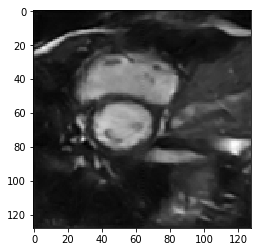

saving epoch {100}


In [55]:
training_loop(100, optimizer, model, loss_fn, train_loader)

# Training done

# Testing and visualisation

In [60]:
print(test_recon.shape)
print(test_truth.shape)
print(test_mask.shape)
print(k_test.shape)

torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])
torch.Size([222, 2, 128, 128, 20])


In [61]:
result_vec = []

In [62]:
for k in range(222):
    a = test_recon[k:k+1,:,:,:,:]
    a = a.float()
    b = test_mask[k:k+1,:,:,:,:]
    b = b.float()
    c = k_test[k:k+1,:,:,:,:]
    c = c.float()
    result = model(a.to(device), b.to(device), c.to(device), mode=True)
    result = result.to('cpu')
    result = result.detach()
    result = result.numpy()
    result_vec.append(result)

In [63]:
len(result_vec)

222

In [64]:
res_save = np.ndarray((128,128,200,222))

In [65]:
a = torch.FloatTensor(result_vec)

In [66]:
a.shape

torch.Size([222, 1, 2, 128, 128, 20])

In [67]:
a = a.permute(0,3,4,5,1,2)

In [68]:
b = a[:,:,:,:,0,0]

In [69]:
b.shape

torch.Size([222, 128, 128, 20])

In [70]:
b = b.numpy()

In [71]:
import scipy.io

In [72]:
scipy.io.savemat('Results_DCRNN_23und_100epoch.mat', {'recon':b})

In [73]:
test_truth.shape

torch.Size([222, 2, 128, 128, 20])

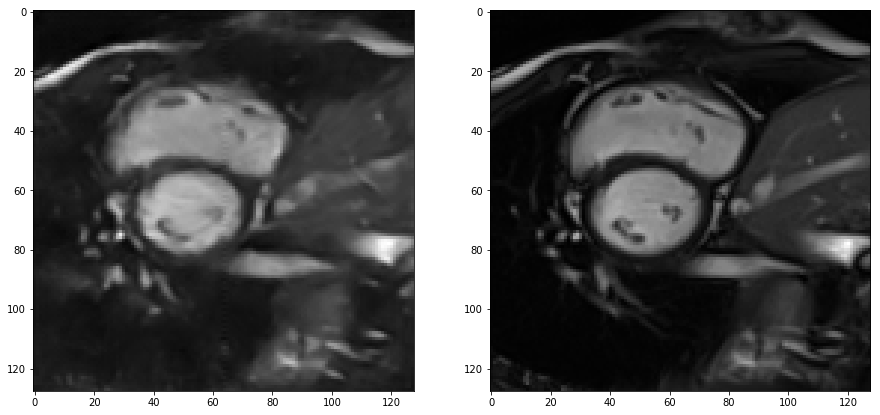

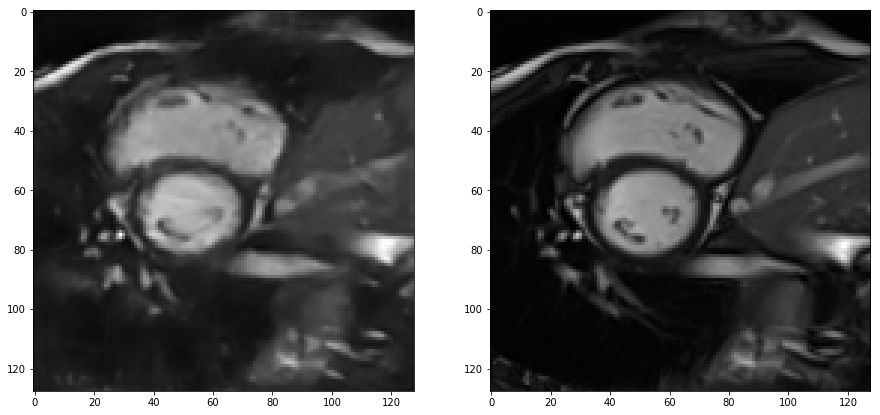

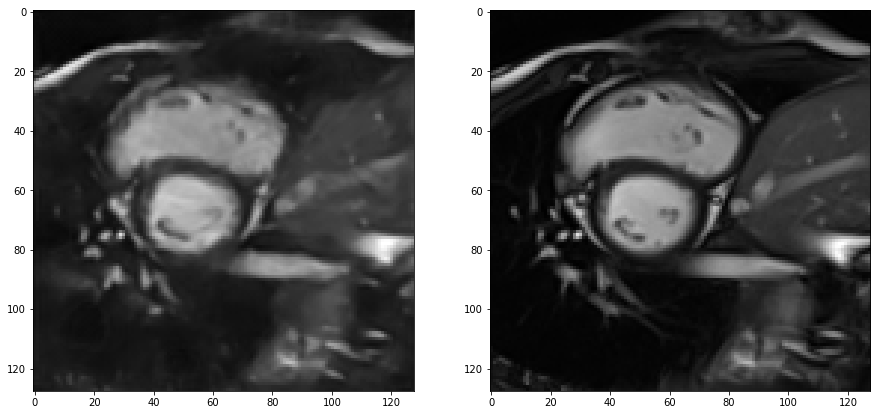

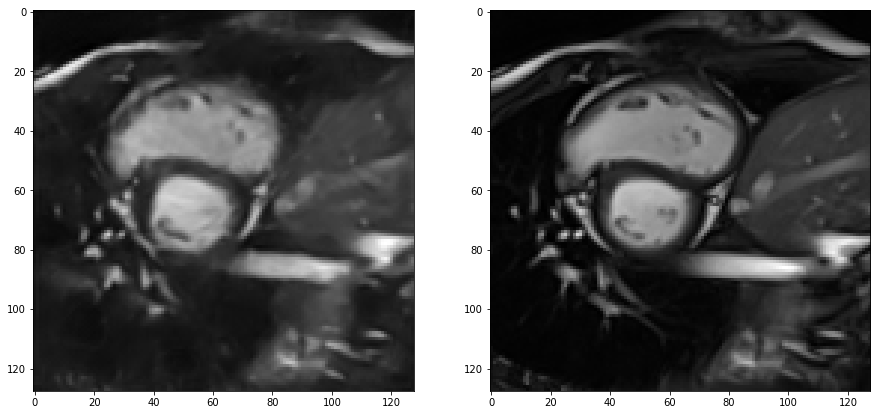

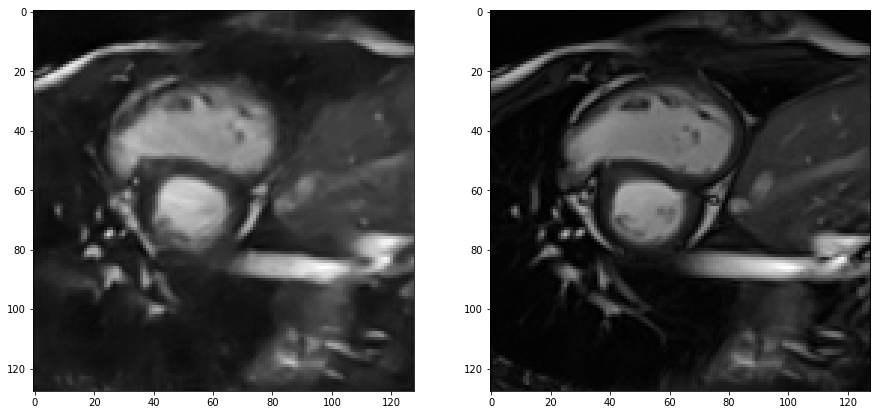

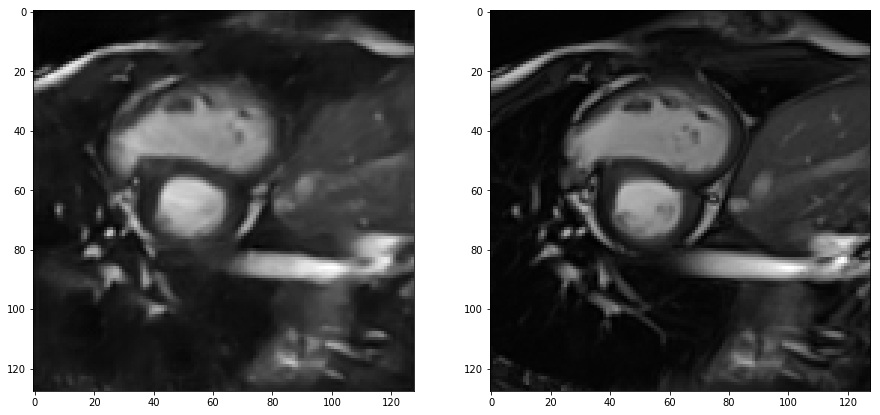

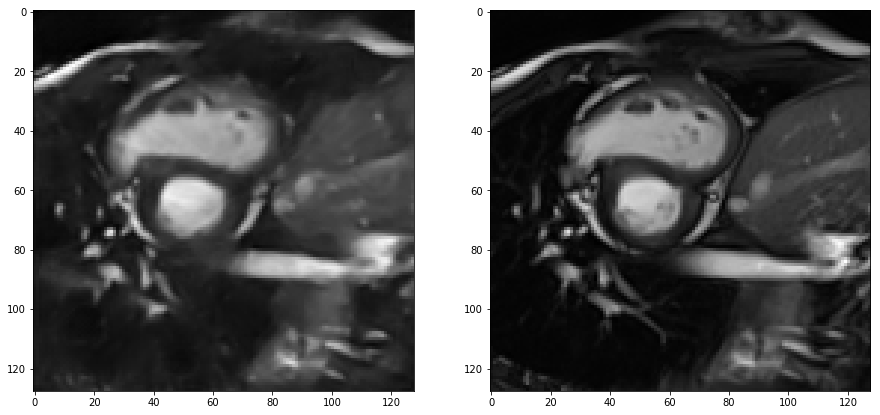

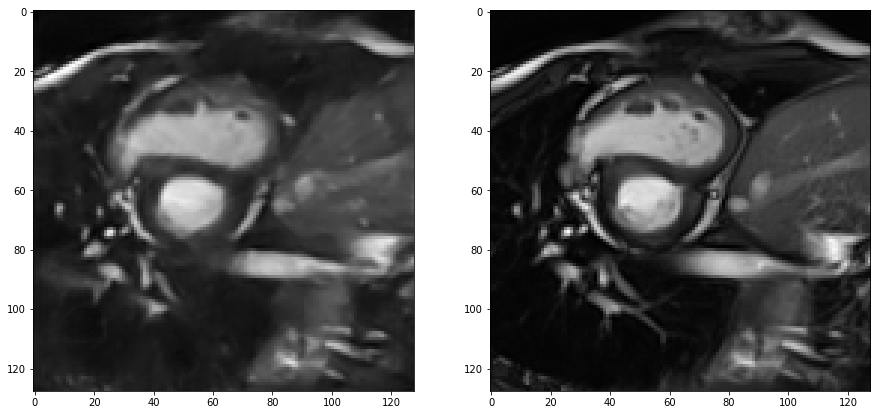

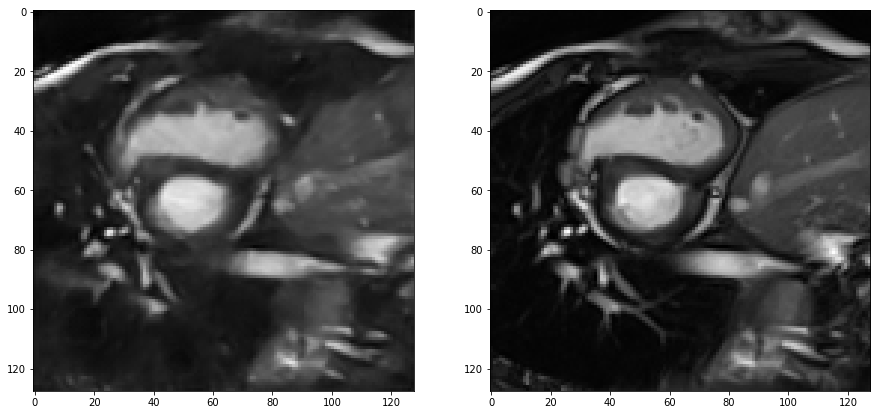

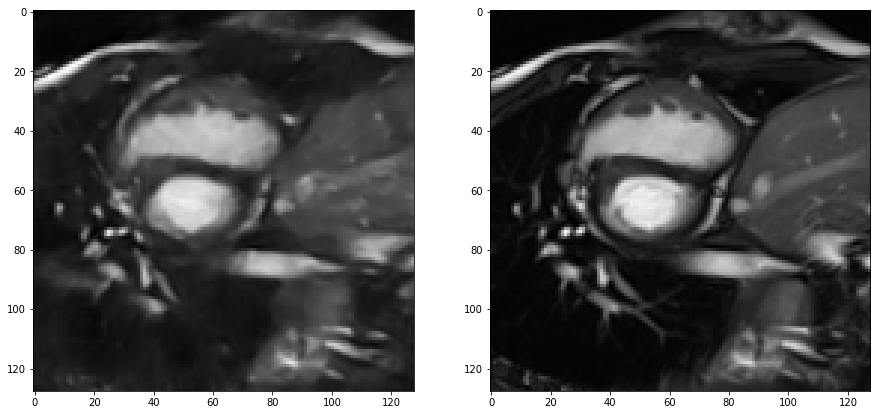

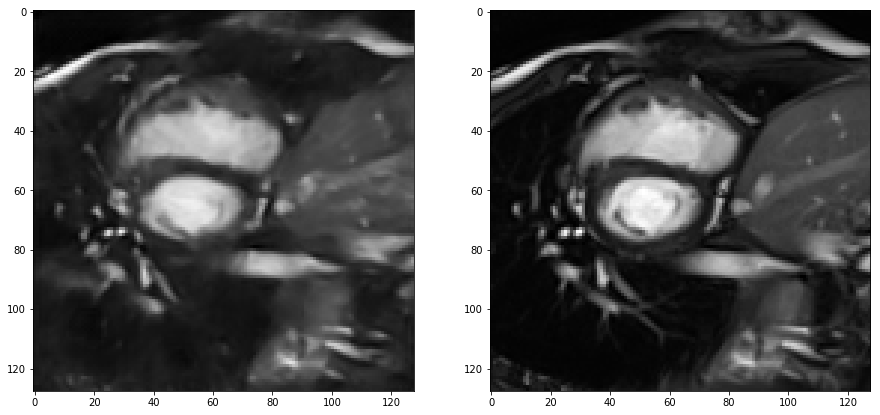

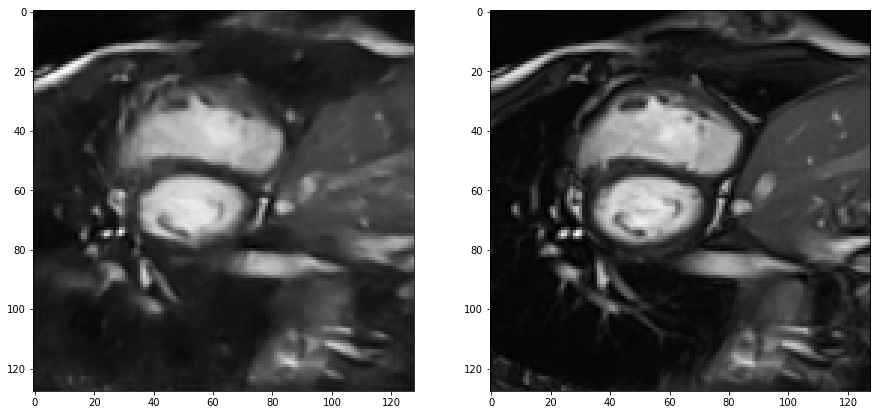

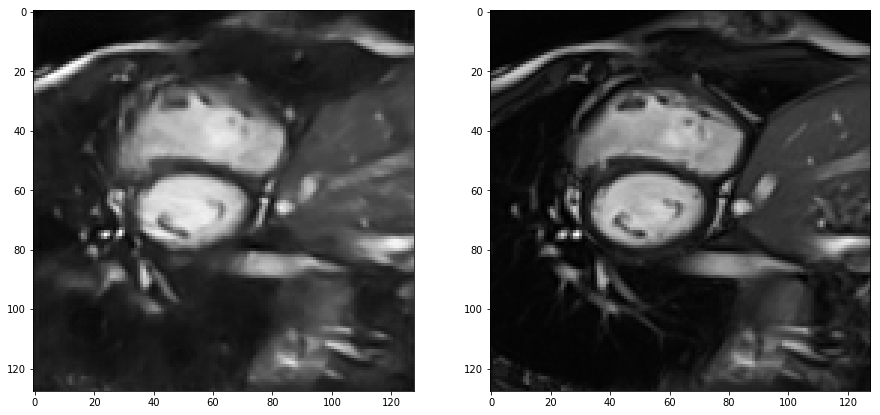

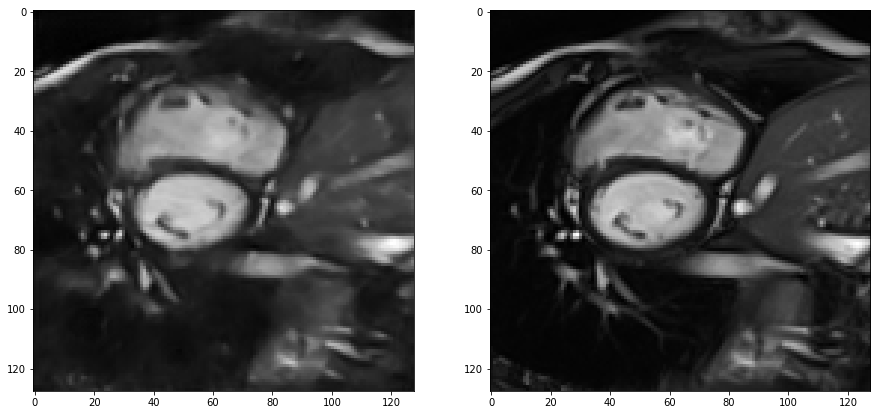

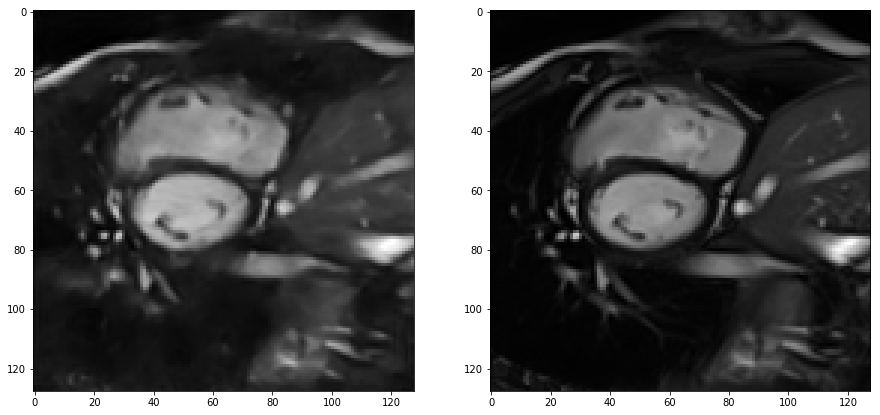

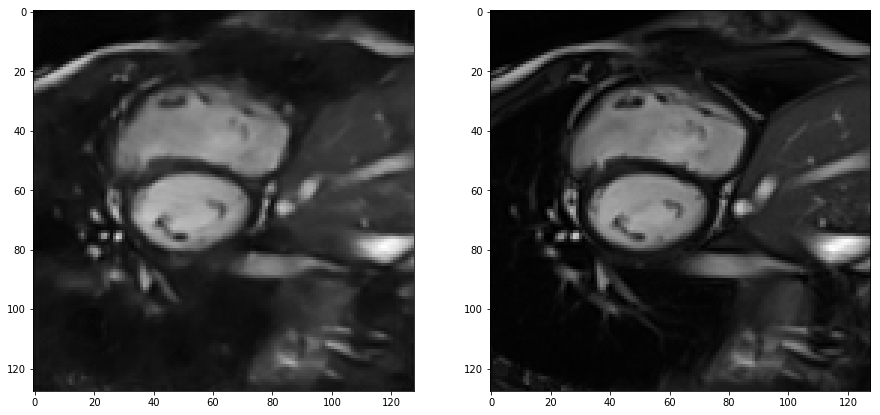

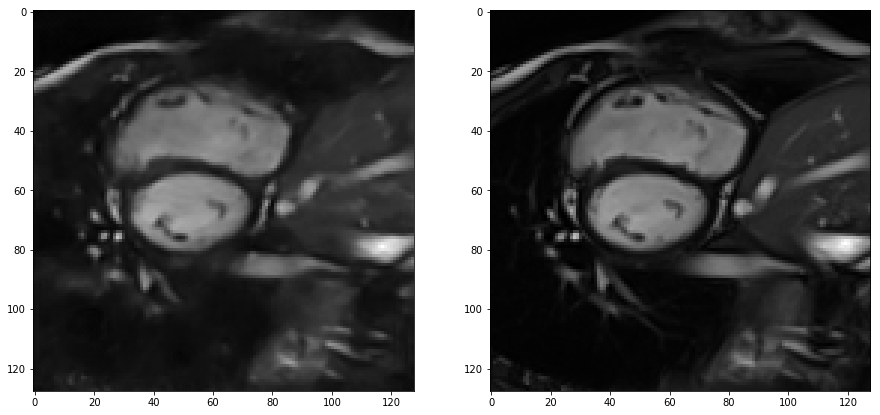

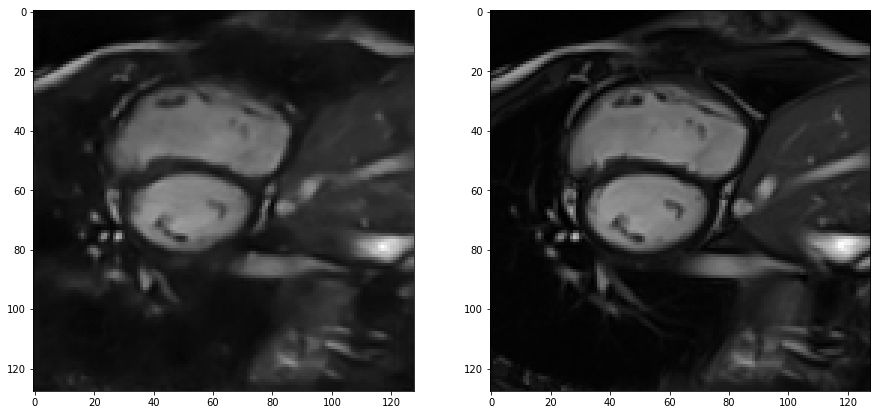

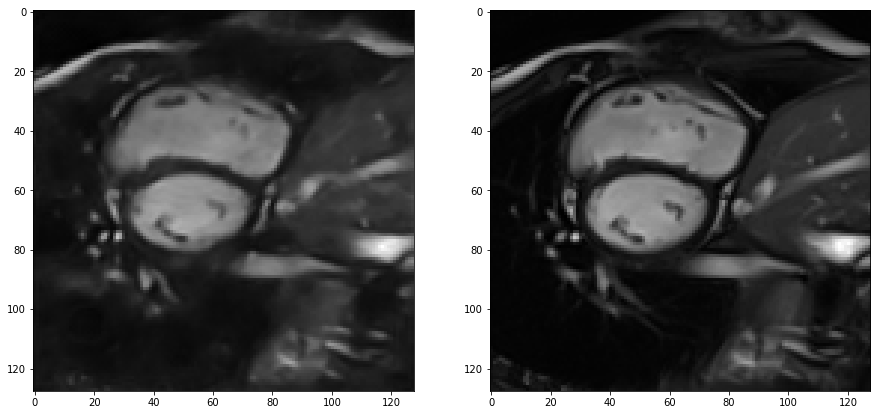

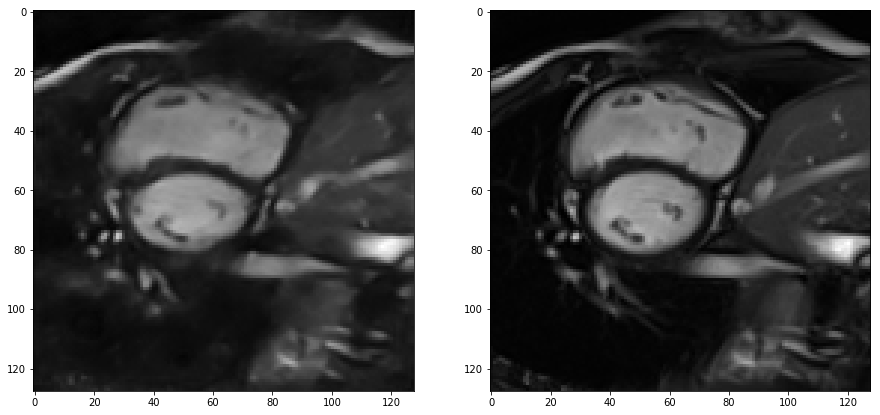

In [74]:
for k in range(20):
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(b[0,:,:,k], cmap='gray')
    arr[1].imshow(test_truth[0,0,:,:,k], cmap='gray')
    

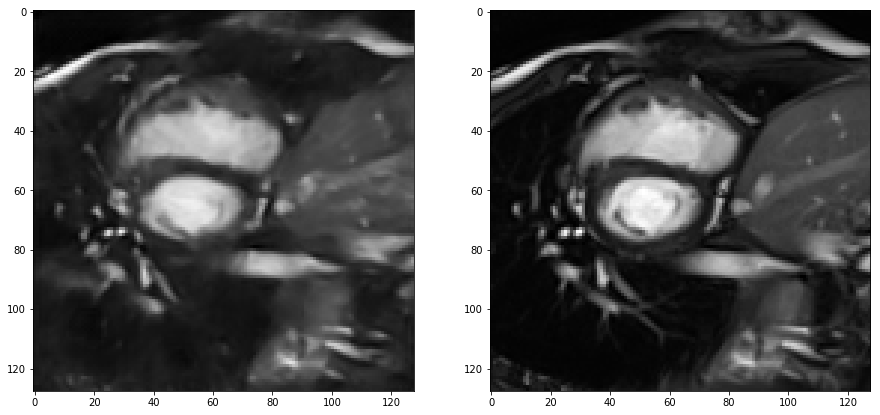

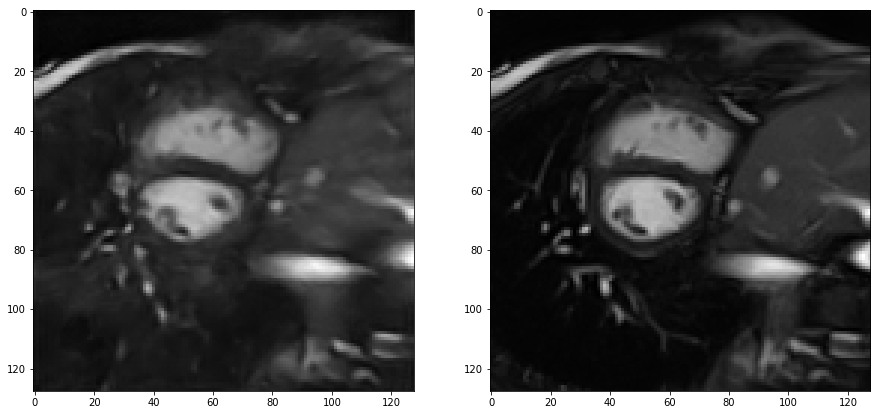

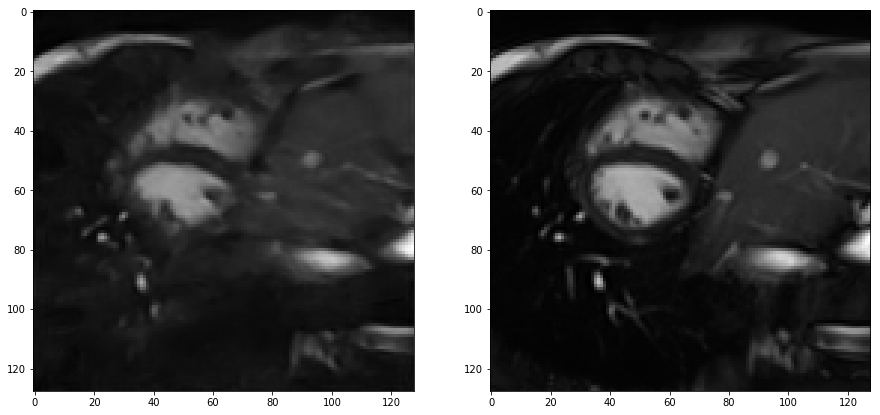

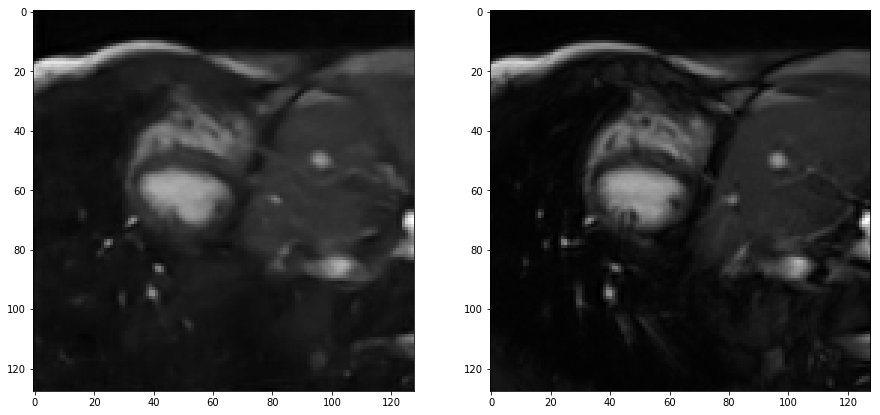

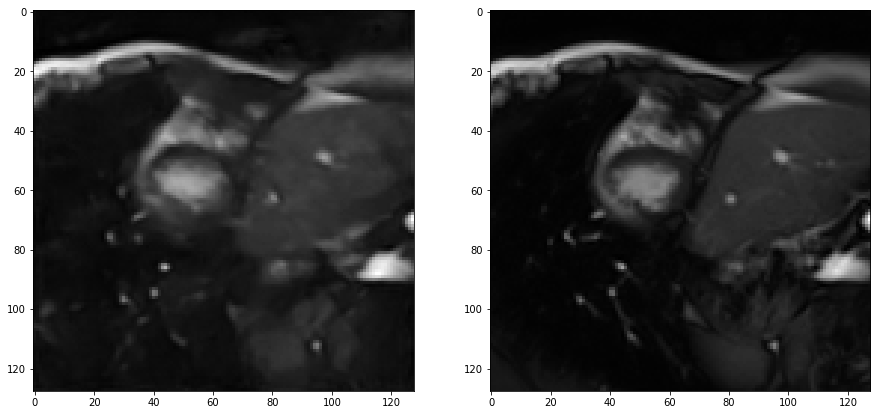

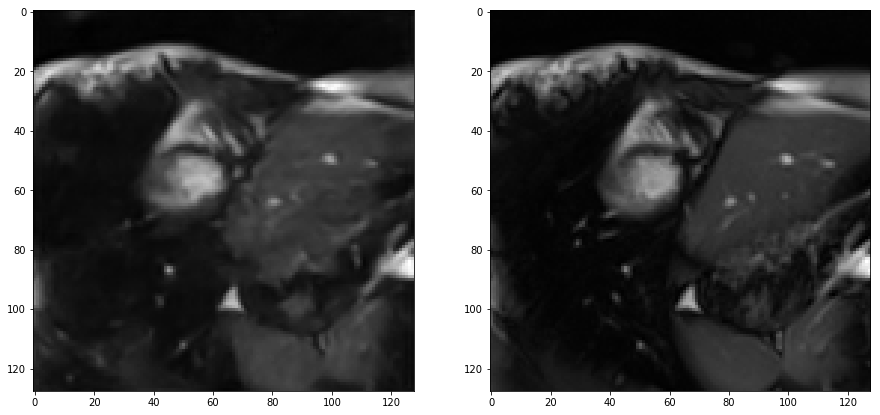

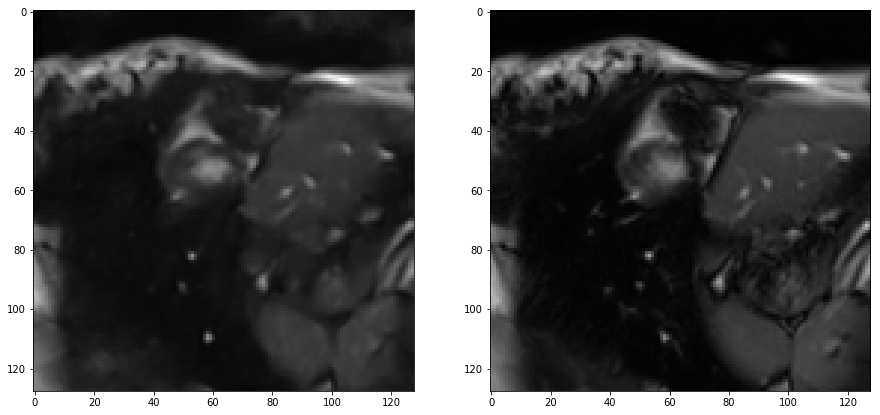

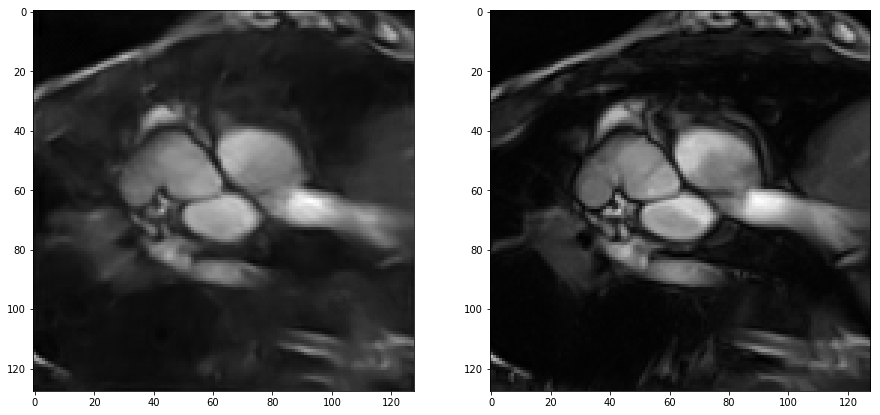

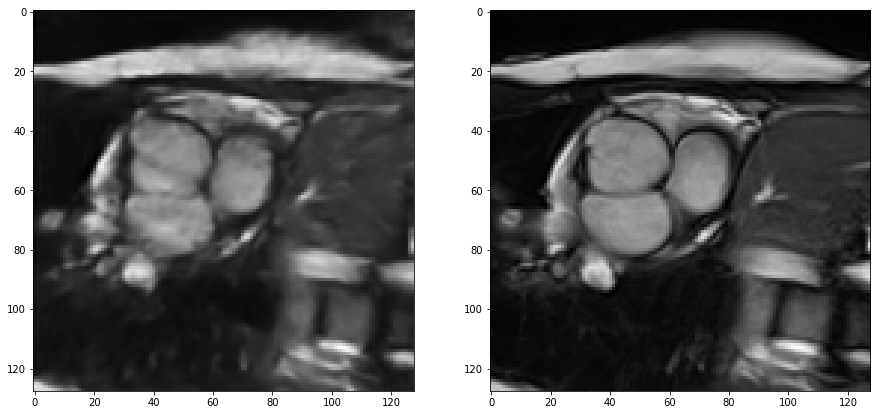

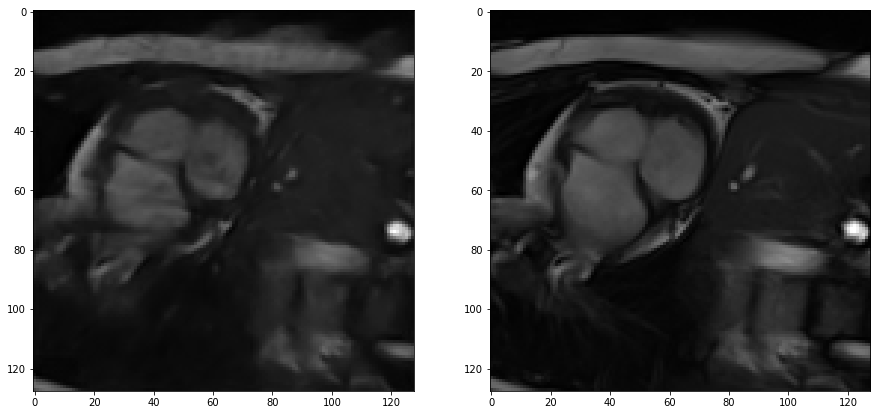

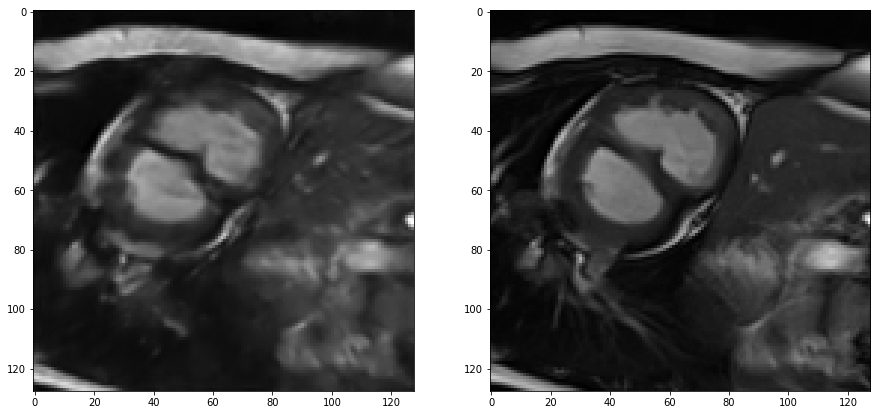

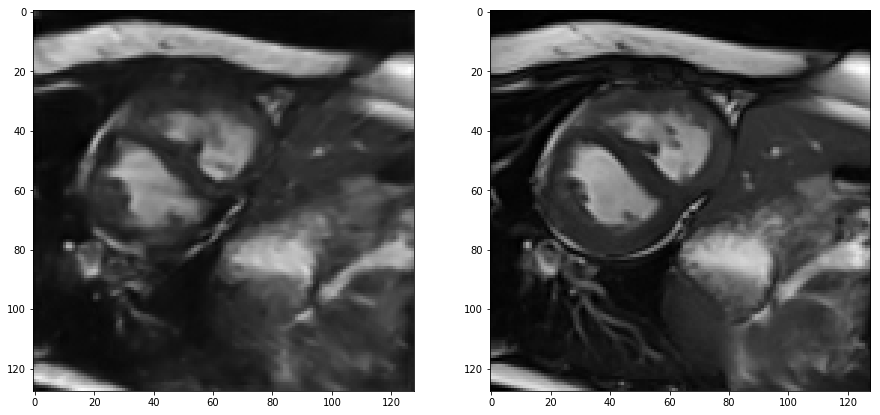

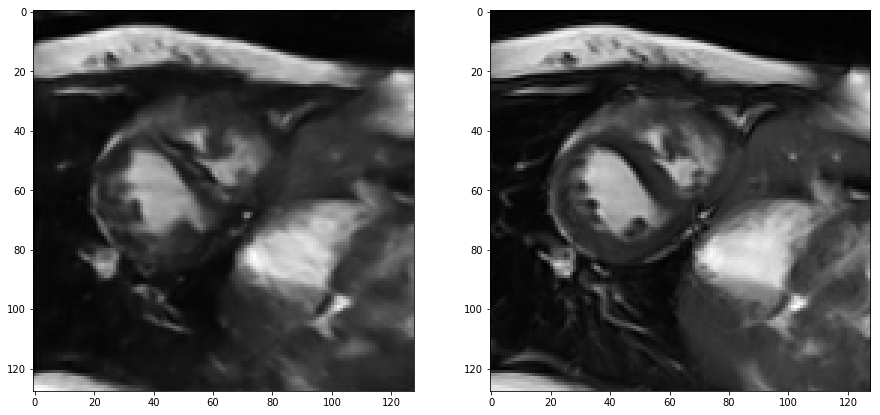

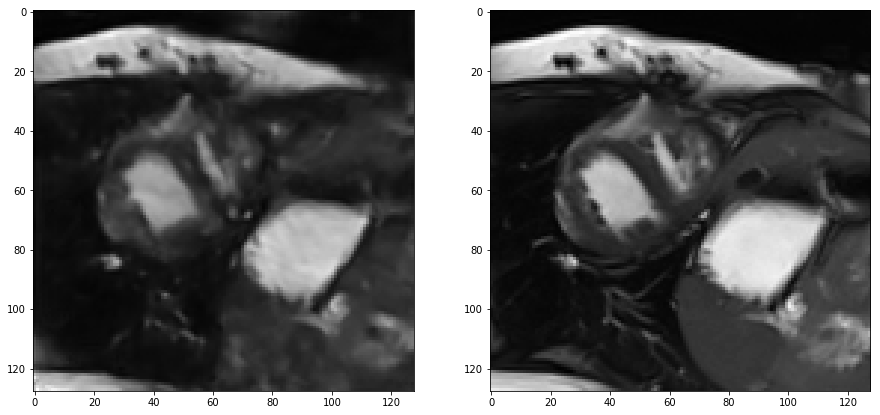

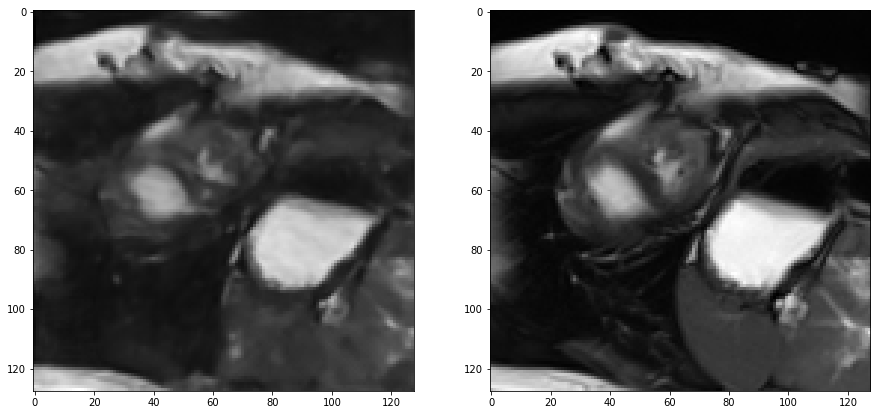

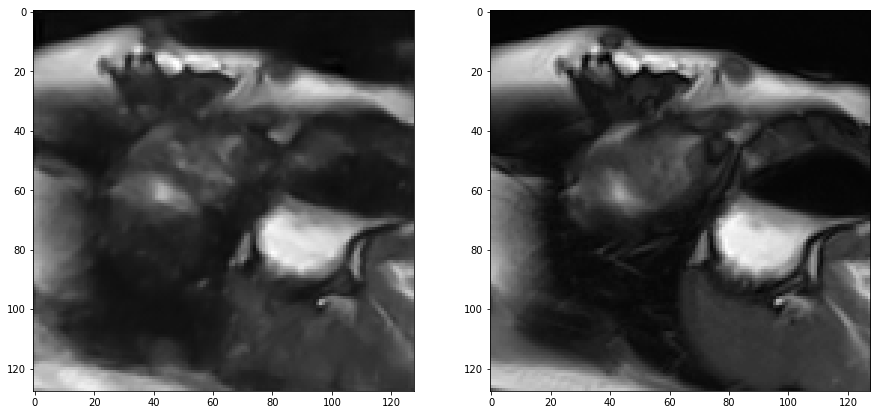

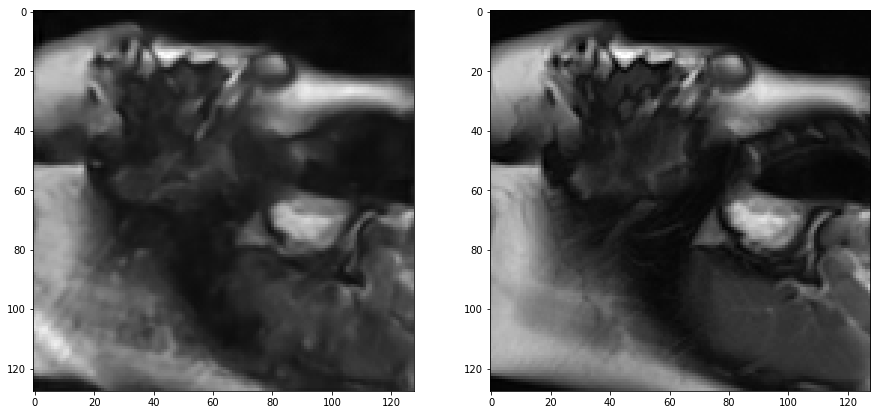

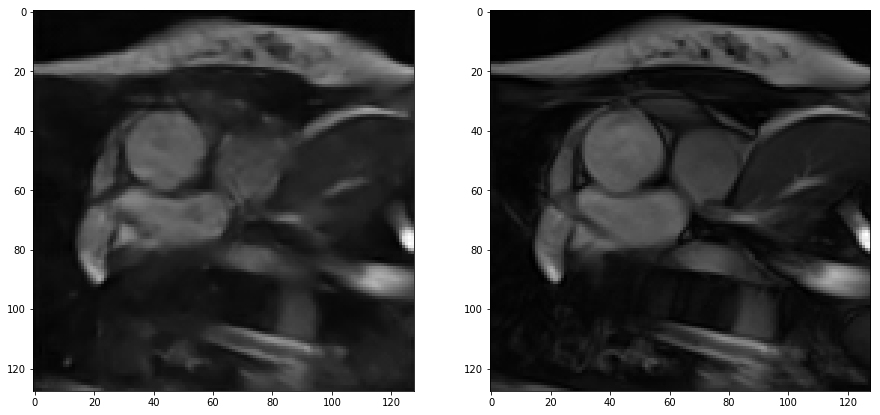

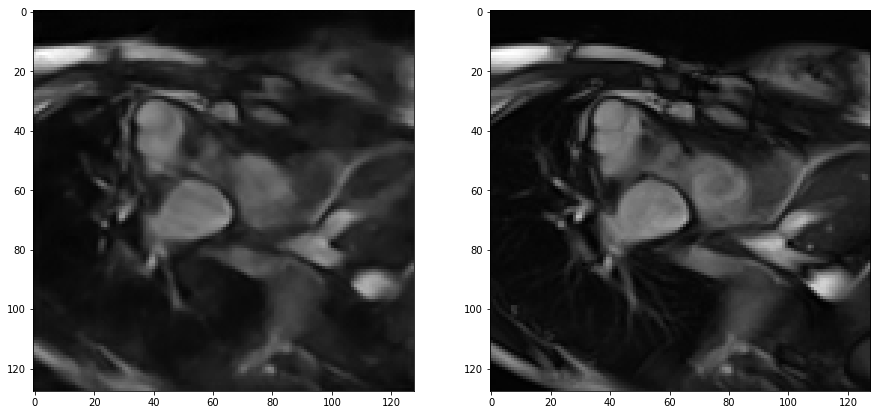

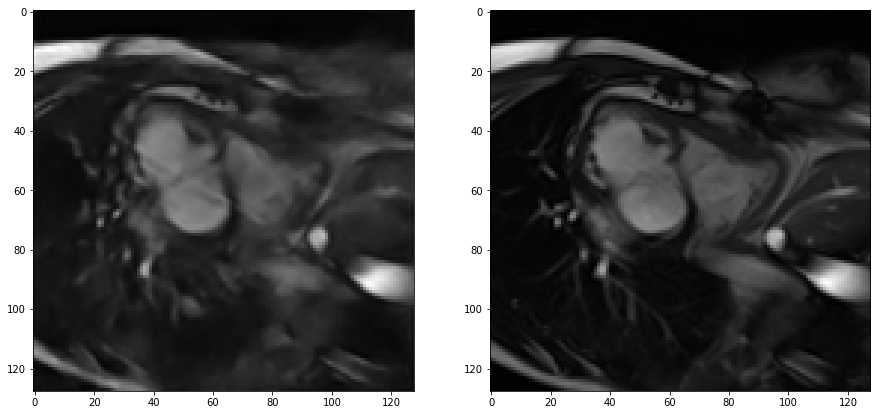

In [75]:
for k in range(20):
    f, arr = plt.subplots(1,2,figsize=(15,15))
    arr[0].imshow(b[k,:,:,10], cmap='gray')
    arr[1].imshow(test_truth[k,0,:,:,10], cmap='gray')
    